# Self-Driving Car Engineer Nanodegree


## Project: **Advanced Lane Finding** 
***

---

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
from pylab import rcParams
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


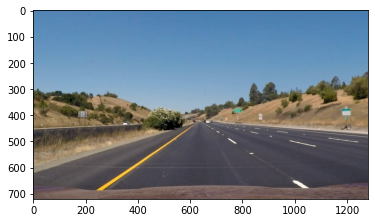

In [2]:
#reading in an image
exampleImage = mpimg.imread('test_images/straight_lines1.jpg')

#printing out some stats and plotting
print('This image is:', type(exampleImage), 'with dimensions:', exampleImage.shape)
plt.imshow(exampleImage)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Helper Functions

In [3]:
import math

def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1:], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

def grayscale(img):
    """Convert intial RGB image to grayscale"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

lastLeftLine = None
lastRightLine = None
def draw_lines(img, lines, color=[0, 255, 0], thickness=4, ):
    global lastLeftLine
    global lastRightLine
    leftX = []
    leftY = []
    rightX = []
    rightY = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            lineSlope = (y2 - y1)/(x2 - x1)
            if abs(lineSlope) < 0.5:
                continue
            if lineSlope < 0:
                leftX.extend([x1, x2])
                leftY.extend([y1, y2])
            else:
                rightX.extend([x1, x2])
                rightY.extend([y1, y2])
                
    if len(leftX) == 0:
        leftLine = lastLeftLine
    else:
        leftParameters = np.polyfit( leftY, leftX, 1)
        leftLine = np.poly1d(leftParameters)
        lastLeftLine = leftLine
    if len(rightX) == 0:
        rightLine = lastRightLine
    else:
        rightParameters = np.polyfit( rightY, rightX, 1)
        rightLine = np.poly1d(rightParameters)
        lastRightLine = rightLine
    
    maxY = img.shape[0]
    minY = int(img.shape[0]* 345 / 540)
    
    leftXStart = int(leftLine(maxY))
    leftXEnd = int(leftLine(minY))
    rightXStart = int(rightLine(maxY))
    rightXEnd = int(rightLine(minY))
    
    cv2.line(img, (leftXStart, maxY), (leftXEnd, minY), color, thickness)
    cv2.line(img, (rightXStart, maxY), (rightXEnd, minY), color, thickness)
    
def draw_lines_not_averaged(img, lines, color=[0, 255, 0], thickness=2):
    """
    This is an initial version of draw_lines that doesn't calculate average lines.
    This version is not currently used in the pipeline
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """  
    Returns start/end points of 2 averaged lines
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    leftX = []
    leftY = []
    rightX = []
    rightY = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            lineSlope = (y2 - y1)/(x2 - x1)
            if abs(lineSlope) < 0.5:
                continue
            if lineSlope < 0:
                leftX.extend([x1, x2])
                leftY.extend([y1, y2])
            else:
                rightX.extend([x1, x2])
                rightY.extend([y1, y2])
                

    leftParameters = np.polyfit( leftY, leftX, 1)
    leftLine = np.poly1d(leftParameters)
    rightParameters = np.polyfit( rightY, rightX, 1)
    rightLine = np.poly1d(rightParameters)

    maxY = img.shape[0]
    minY = int(img.shape[0]* 345 / 540)
    
    leftXStart = int(leftLine(maxY))
    leftXEnd = int(leftLine(minY))
    rightXStart = int(rightLine(maxY))
    rightXEnd = int(rightLine(minY))
    return minY, maxY, leftXStart, leftXEnd, rightXStart, rightXEnd

# Calibration Pipeline



In [39]:
def find_image_distortion(imgs):
    objpoints = []
    imgpoints = []

    nx = 9 #number of inside corners in x
    ny = 6 #number of inside corners in y
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    
    mtxList = []
    distList = []
    rvecsList = []
    tvecsList = []
    for img in imgs:
    # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    
            ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
            mtxList.append(mtx)
            distList.append(dist)
            
    mtx = np.mean(mtxList, axis=0)
    dist = np.mean(distList, axis=0) 

    return mtx, dist, rvecs, tvecs
    

In [40]:
cal_images = [cv2.imread(file) for file in glob.glob("camera_cal/*.jpg")]

mtx, dist, rvecs, tvecs = find_image_distortion(cal_images)

undis_cal_images = [cv2.undistort(image, mtx, dist, None, mtx) for image in cal_images]
outNameList = map(lambda x: "out_" + x , os.listdir("camera_cal/"))
[cv2.imwrite(os.path.join("camera_cal_output/", name), image) for name, image in zip(outNameList,undis_cal_images)]

test_images = [cv2.imread(file) for file in glob.glob("test_images/*.jpg")]
#test_images_changed = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in test_images]
test_images_undistorted = [cv2.undistort(testimg, mtx, dist, None, mtx) for testimg in test_images]
outNameList = map(lambda x: "out_undis_" + x , os.listdir("test_images/"))
[cv2.imwrite(os.path.join("output_images/test_calibrated_output/", name), image) for name, image in zip(outNameList,test_images_undistorted)]

[True, True, True, True, True, True, True, True]

# Binary Pipeline


In [7]:
#def binary_pipeline(img, s_thresh=(120, 255), sx_thresh=(20, 100)):
def binary_pipeline(img, l_thresh=(210, 255), b_thresh=(144, 255)):
    img = np.copy(img)
    # Convert to HLS and Lab color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    # take L channel from HLS and b channel from Lab
    l_channel = hls[:,:,1]  
    b_channel = lab[:,:,2]
        
    # Threshold b channel
    b_binary = np.zeros_like(l_channel)
    b_binary[(b_channel >= b_thresh[0]) & (b_channel <= b_thresh[1])] = 1
    
    # Threshold l channel
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(b_binary), b_binary, l_binary)) * 255
    return color_binary

In [8]:
test_images_binary = [ binary_pipeline(undis_image) for undis_image in test_images_undistorted]
outNameList = map(lambda x: "out_binary_" + x , os.listdir("test_images/"))
[cv2.imwrite(os.path.join("output_images/test_binary_output/", name), image) for name, image in zip(outNameList,test_images_binary)]


[True, True, True, True, True, True, True, True]

# Get Perspective Transform Matrix

In [9]:
def get_transform_matrix(images):
    
    minYL = []
    maxYL = []
    leftXStartL = []
    leftXEndL = []
    rightXStartL = []
    rightXEndL = []
    
    for image in images:
        grayMap = grayscale(image)
        smoothedImage = gaussian_blur(grayMap, 5)

        cannyMap = canny(smoothedImage, 50, 150)

        maxYRegion = image.shape[0]
        #minYRegion = int(image.shape[0]* 330 / 540)
        minYRegion = int(image.shape[0]* 345 / 540)
        leftXRegion1 = int(image.shape[1]* 110 / 960)
        #leftXRegion2 = int(image.shape[1]* 440 / 960)
        leftXRegion2 = int(image.shape[1]* 420 / 960)
        #rightXRegion1 = int(image.shape[1]* 530 / 960)
        rightXRegion1 = int(image.shape[1]* 550 / 960)
        rightXRegion2 = int(image.shape[1]* 880 / 960)
    
        vertices = np.array([[
            (leftXRegion2, minYRegion),
            (rightXRegion1, minYRegion), 
            (rightXRegion2, maxYRegion), 
            (leftXRegion1, maxYRegion)
        ]], dtype=np.int32)
        
        cannyRegionMap = region_of_interest(cannyMap, vertices)

        minY, maxY, leftXStart, leftXEnd, rightXStart, rightXEnd = hough_lines(cannyRegionMap, 1, 0.034, 15, 25, 35)
        minYL.append(minY)
        maxYL.append(maxY)
        leftXStartL.append(leftXStart)
        leftXEndL.append(leftXEnd)
        rightXStartL.append(rightXStart)
        rightXEndL.append(rightXEnd)
            
    minY = np.mean(minYL)
    maxY = np.mean(maxYL)
    leftXStart = np.mean(leftXStartL)
    leftXEnd = np.mean(leftXEndL)
    rightXStart = np.mean(rightXStartL)
    rightXEnd = np.mean(rightXEndL)
    
    src = np.float32([[leftXEnd,minY],[rightXEnd,minY],[rightXStart,maxY],[leftXStart,maxY]])
    
    imageY = images[0].shape[0]
    imageX = images[0].shape[1]
    
    minXSrc = imageX * 240 / 1300
    maxXSrc = imageX * 860 / 1300
    minYSrc = imageY * 0 / 1000
    maxYSrc = imageY * 1000 / 1000
    
    dst = np.float32([[minXSrc,minYSrc],[maxXSrc,minYSrc],[maxXSrc,maxYSrc],[minXSrc,maxYSrc]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    return M, Minv

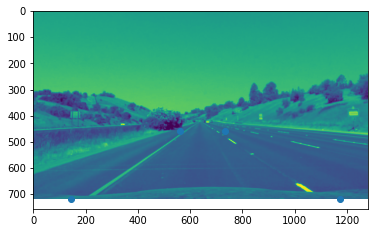

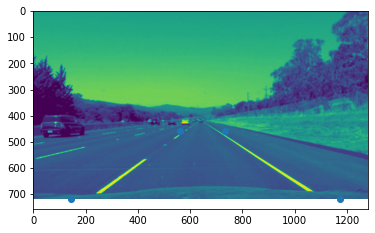

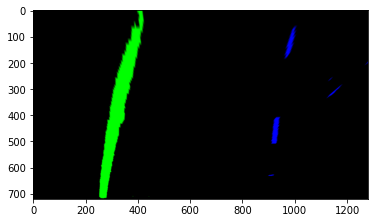

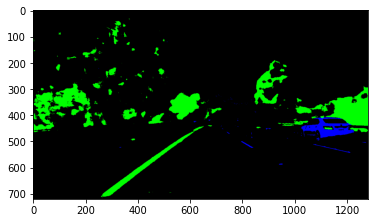

In [10]:
test_images_straight_list = [test_images_undistorted[0], test_images_undistorted[1]]
M, Minv = get_transform_matrix(test_images_straight_list)

test_images_perspective = [ 
    cv2.warpPerspective(binary_image, M, (binary_image.shape[1],binary_image.shape[0]), flags=cv2.INTER_LINEAR) for binary_image in test_images_binary
]
outNameList = map(lambda x: "out_perspective_" + x , os.listdir("test_images/"))
[cv2.imwrite(os.path.join("output_images/test_perspective_output/", name), image) for name, image in zip(outNameList,test_images_perspective)]


# Finding lines

In [11]:



def hist(img):
    # Load our image
    # image will load .jpg as 0-255, so normalize back to 0-1

    img_norm = img/255
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img_norm[img_norm.shape[0]//2:,:]

    # TO-DO: Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

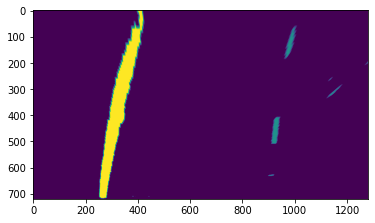

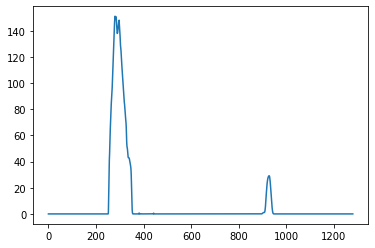

In [12]:
test_gray_perspective = [grayscale(img) for img in test_images_perspective]
plt.imshow(test_gray_perspective[7])
histograms = [hist(img) for img in test_gray_perspective]

# Visualize the resulting histogram
plt.figure()
plt.plot(histograms[7])

In [35]:
def find_lanes(binary_warped, hist):
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = int(hist.shape[0]//2)
    leftx_base = np.argmax(hist[:midpoint])
    rightx_base = np.argmax(hist[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 15
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 30

    # Set height of windows - based on nwindows above and image shape
    window_height = int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    last_leftx_change = 0
    last_rightx_change = 0

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    
# Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        

        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]

        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        #if you don't find min pixels, windows will have a X traslation equal to the previous one
        if len(good_left_inds) > minpix:
            last_leftx_change = int(np.mean(nonzerox[good_left_inds])) - leftx_current
            leftx_current = leftx_current + last_leftx_change
        else:
            leftx_current = leftx_current + last_leftx_change
            
        if len(good_right_inds) > minpix:
            last_rightx_change = int(np.mean(nonzerox[good_right_inds])) - rightx_current
            rightx_current = rightx_current + last_rightx_change
        else:
            rightx_current = rightx_current + last_rightx_change

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img
    
def fit_polynomial(binary_warped, hist):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lanes(binary_warped, hist)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.figure()
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fit, right_fit

[array([-3.18771464e-05,  1.07360774e-02,  2.40859972e+02]), array([-3.35263803e-06,  8.94677674e-03,  2.33454924e+02]), array([ 2.41790027e-04, -2.87698195e-01,  3.42306981e+02]), array([-2.33756096e-04,  3.06858155e-01,  1.87346822e+02]), array([ 1.15318802e-04, -2.87146736e-01,  3.96143687e+02]), array([ 1.07703612e-04, -1.46353228e-01,  3.23836786e+02]), array([ 2.58456974e-04, -3.45315451e-01,  3.22735565e+02]), array([ 1.22685267e-04, -3.03720310e-01,  4.18611019e+02])]
[array([ 1.80151918e-05, -1.21161007e-03,  8.40785292e+02]), array([-3.72727944e-05,  3.83197333e-03,  8.59968070e+02]), array([ 1.10931412e-04, -2.03820888e-01,  9.74038414e+02]), array([-7.98886107e-05,  2.40119259e-01,  7.96754790e+02]), array([ 1.64730758e-04, -2.76617883e-01,  9.88572850e+02]), array([ 1.90624120e-04, -2.48554019e-01,  9.86237902e+02]), array([ 1.60125930e-05, -1.22019794e-01,  9.46980357e+02]), array([ 2.13944272e-04, -2.97335041e-01,  1.01695240e+03])]


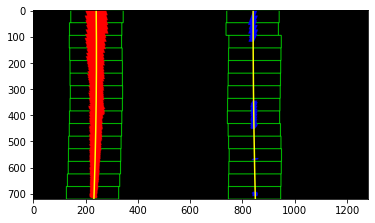

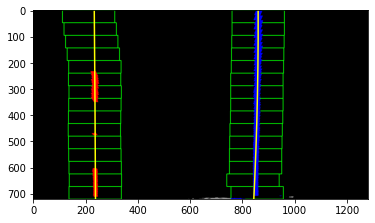

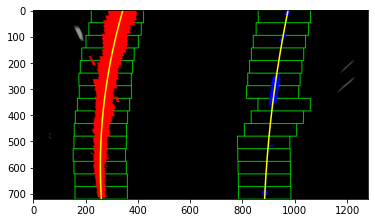

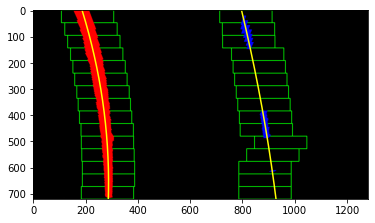

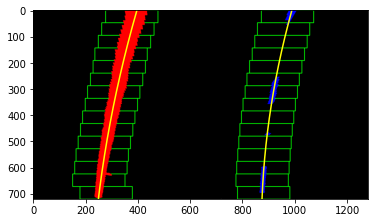

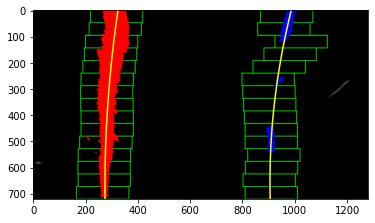

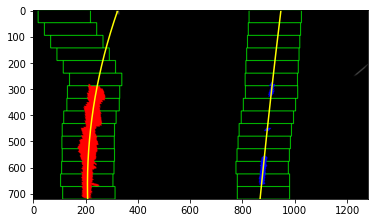

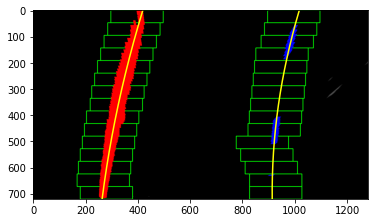

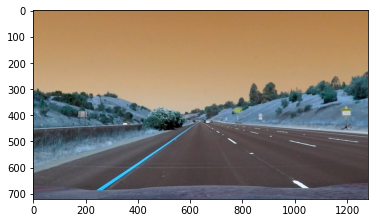

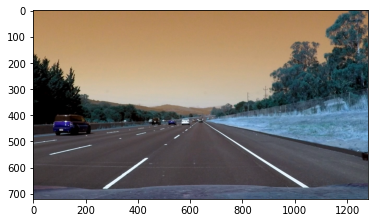

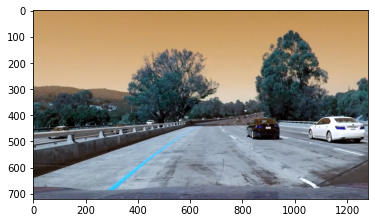

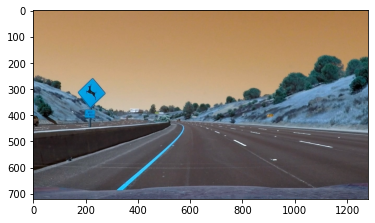

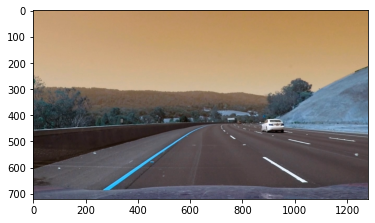

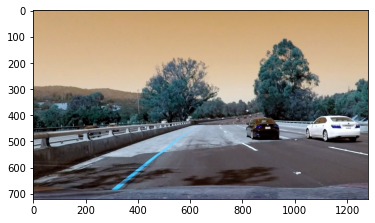

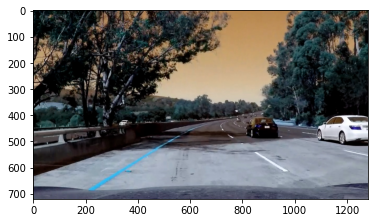

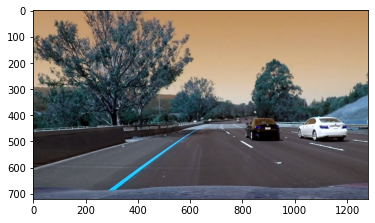

In [36]:
found_lanes, left_fits, right_fits = map(list,zip(*[fit_polynomial(img, hist) for img, hist in zip(test_gray_perspective,histograms)]))


In [37]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return left_fit, right_fit, left_fitx, right_fitx, ploty

def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    margin = 25

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    
    # extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit new polynomials
    left_fit, right_fit, left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    return result, left_fit, right_fit, left_fitx, right_fitx, ploty

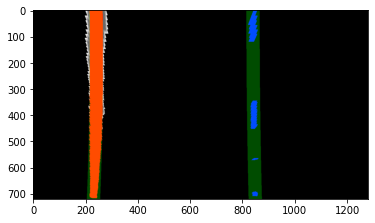

In [38]:
result, left_fit, right_fit, left_fits, right_fits, ploty = map(list,zip(*[search_around_poly(im, lf, rf) for im,lf,rf in zip(test_gray_perspective, left_fits, right_fits)]))
plt.imshow(result[0])

# Inverse Transform

In [17]:
def inv_transform (undis, warped, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    #print('LOL')
    #print(left_fitx)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    #print(right_fitx)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    #print(pts.shape)
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undis.shape[1], undis.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undis, 1, newwarp, 0.3, 0)
    return result

In [18]:
inversed_lines = [inv_transform(u,w,lf,rf,pl) for u,w,lf,rf,pl in zip(test_images_undistorted, test_gray_perspective, left_fits, right_fits, ploty)]

# Calculate curvature

In [19]:
def measure_curvature_real(ploty, left_fit, right_fit):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    print(y_eval)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 15/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/620 # meters per pixel in x dimension
    
    ##### calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad

def paint_curvature(image, curvature1, curvature2):
    img = np.copy(image)
    font = cv2.FONT_HERSHEY_SIMPLEX

    cv2.putText(img, 'Left Lane Curvature: {:.0f} m'.format(curvature1), (10,40), font, 1,(255,255,255),2)
    cv2.putText(img, 'Left Lane Curvature: {:.0f} m'.format(curvature2), (10,100), font, 1,(255,255,255),2)
    return img

719.0
[ 9.51627204e-05 -1.38871291e-01  3.23168627e+02]
5400.6457641965735 2858.3761869109053


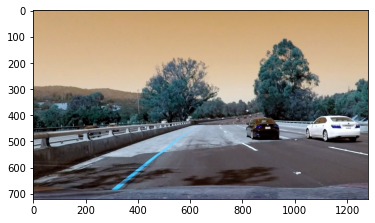

In [20]:
indxvar = 5
left_curvetest, right_curvetest = measure_curvature_real(ploty[indxvar], left_fit[indxvar], right_fit[indxvar])
image_w_curvature = paint_curvature(inversed_lines[indxvar],left_curvetest, right_curvetest)

# Calculate offset

In [21]:
def measure_and_paint_offset_real(image, left_fits, right_fits):
    img = np.copy(image)
    image_center = image.shape[1]/2
    car_center = np.mean([left_fits[-1],right_fits[-1]])
    
    xm_per_pix = 3.7/620 # meters per pixel in x dimension
    offset = (image_center - car_center) * xm_per_pix
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img, 'Offset: {:.2f} m'.format(offset), (10,150), font, 1,(255,255,255),2)
    return img

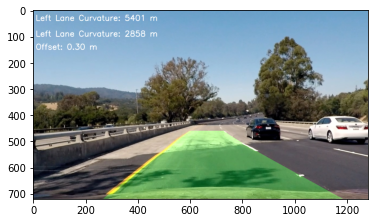

In [22]:
image_w_offset = measure_and_paint_offset_real(image_w_curvature, left_fits[indxvar], right_fits[indxvar])
plt.imshow(image_w_offset)

In [23]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
counter = 0
v_left_fit = None
v_right_fit = None
v_ploty = None


In [24]:
def process_image (img):
    global counter
    global mtx
    global dist
    global M
    global Minv
    global v_left_fit
    global v_right_fit
    global v_ploty
    global v_left_fitx
    global v_right_fitx
    
    undis_image = cv2.undistort(img, mtx, dist, None, mtx)
    binary_image = binary_pipeline(undis_image)
    perspective_image = cv2.warpPerspective(binary_image, M, (binary_image.shape[1],binary_image.shape[0]), flags=cv2.INTER_LINEAR)
    perspective_gray = grayscale(perspective_image)
    
    if counter < 1:
        counter = 1
        histogram = hist(perspective_gray)
        found_lanes, v_left_fit, v_right_fit = fit_polynomial(perspective_gray, histogram)
        non_used_var, v_left_fit, v_right_fit, v_left_fitx, v_right_fitx, v_ploty = search_around_poly(perspective_gray, v_left_fit, v_right_fit) 
    else:
        non_used_var, v_left_fit, v_right_fit, v_left_fitx, v_right_fitx, v_ploty = search_around_poly(perspective_gray, v_left_fit, v_right_fit)
    
    inversed = inv_transform(undis_image,perspective_gray,v_left_fitx,v_right_fitx,v_ploty)
    left_meters, right_meters = measure_curvature_real(v_ploty, v_left_fit, v_right_fit)
    img_printed_curv = paint_curvature(inversed, left_meters, right_meters)
    img_printed_off = measure_and_paint_offset_real(img_printed_curv, v_left_fitx, v_right_fitx)

    return img_printed_off


t:   0%|                                                                            | 0/1260 [00:00<?, ?it/s, now=None]

719.0
[-2.17742762e-04  2.81476241e-01  1.92878335e+02]
Moviepy - Building video videos_output/video1_output.mp4.
Moviepy - Writing video videos_output/video1_output.mp4

719.0
[-2.14074533e-04  2.78680946e-01  1.93207108e+02]


t:   0%|▏                                                                   | 3/1260 [00:01<07:02,  2.97it/s, now=None]

719.0
[-2.19753169e-04  2.84706633e-01  1.92647238e+02]


t:   0%|▏                                                                   | 4/1260 [00:01<06:26,  3.25it/s, now=None]

719.0
[-2.24280879e-04  2.89245296e-01  1.92190375e+02]


t:   0%|▎                                                                   | 5/1260 [00:01<06:17,  3.32it/s, now=None]

719.0
[-2.26579646e-04  2.93254335e-01  1.91700731e+02]


t:   0%|▎                                                                   | 6/1260 [00:01<05:44,  3.64it/s, now=None]

719.0
[-2.28538395e-04  2.95882919e-01  1.91386924e+02]


t:   1%|▍                                                                   | 7/1260 [00:02<05:24,  3.86it/s, now=None]

719.0
[-2.28896864e-04  2.99825801e-01  1.90432428e+02]


t:   1%|▍                                                                   | 8/1260 [00:02<05:12,  4.01it/s, now=None]

719.0
[-2.26721548e-04  3.01222016e-01  1.88883111e+02]


t:   1%|▍                                                                   | 9/1260 [00:02<04:56,  4.22it/s, now=None]

719.0
[-2.19787796e-04  3.02830389e-01  1.87112997e+02]
719.0

t:   1%|▌                                                                  | 10/1260 [00:02<04:38,  4.49it/s, now=None]


[-2.20385262e-04  3.05064312e-01  1.84848909e+02]
719.0

t:   1%|▌                                                                  | 11/1260 [00:02<04:27,  4.67it/s, now=None]


[-2.17590305e-04  3.07390163e-01  1.81847869e+02]


t:   1%|▋                                                                  | 12/1260 [00:03<04:36,  4.52it/s, now=None]

719.0
[-2.08078594e-04  3.03843359e-01  1.80557578e+02]


t:   1%|▋                                                                  | 13/1260 [00:03<04:32,  4.57it/s, now=None]

719.0
[-2.03339167e-04  3.02707918e-01  1.76429091e+02]
719.0

t:   1%|▋                                                                  | 14/1260 [00:03<04:27,  4.67it/s, now=None]


[-1.87927047e-04  2.96907564e-01  1.74326953e+02]
719.0

t:   1%|▊                                                                  | 15/1260 [00:03<04:21,  4.76it/s, now=None]


[-1.75887669e-04  2.91082400e-01  1.73405731e+02]


t:   1%|▊                                                                  | 16/1260 [00:03<04:29,  4.62it/s, now=None]

719.0
[-1.81176309e-04  2.97066686e-01  1.72565336e+02]


t:   1%|▉                                                                  | 17/1260 [00:04<04:38,  4.47it/s, now=None]

719.0
[-1.86621014e-04  3.02136535e-01  1.71993926e+02]
719.0

t:   1%|▉                                                                  | 18/1260 [00:04<04:28,  4.63it/s, now=None]


[-1.82264696e-04  2.96987742e-01  1.72363509e+02]
719.0

t:   2%|█                                                                  | 19/1260 [00:04<04:19,  4.78it/s, now=None]


[-1.81517895e-04  2.95977672e-01  1.72395727e+02]
719.0

t:   2%|█                                                                  | 20/1260 [00:04<04:13,  4.89it/s, now=None]


[-1.64921661e-04  2.81487247e-01  1.73293533e+02]
719.0


t:   2%|█                                                                  | 21/1260 [00:04<04:09,  4.96it/s, now=None]

[-1.50424176e-04  2.69571952e-01  1.73537999e+02]


t:   2%|█▏                                                                 | 22/1260 [00:05<04:08,  4.97it/s, now=None]

719.0
[-1.35431404e-04  2.57222762e-01  1.73499510e+02]
719.0

t:   2%|█▏                                                                 | 23/1260 [00:05<04:06,  5.02it/s, now=None]


[-1.27574709e-04  2.51658129e-01  1.71620388e+02]


t:   2%|█▎                                                                 | 24/1260 [00:05<04:05,  5.04it/s, now=None]

719.0
[-1.17917798e-04  2.42355511e-01  1.70935439e+02]


t:   2%|█▎                                                                 | 25/1260 [00:05<04:04,  5.05it/s, now=None]

719.0
[-1.14397344e-04  2.38990719e-01  1.71004601e+02]
719.0

t:   2%|█▍                                                                 | 26/1260 [00:05<04:00,  5.13it/s, now=None]


[-1.22426530e-04  2.42940458e-01  1.70931278e+02]
719.0

t:   2%|█▍                                                                 | 27/1260 [00:06<04:07,  4.99it/s, now=None]


[-1.22270612e-04  2.38124288e-01  1.71347855e+02]
719.0

t:   2%|█▍                                                                 | 28/1260 [00:06<04:03,  5.05it/s, now=None]


[-1.25241074e-04  2.37783499e-01  1.71031229e+02]
719.0

t:   2%|█▌                                                                 | 29/1260 [00:06<04:00,  5.11it/s, now=None]


[-1.31943730e-04  2.39261254e-01  1.70088005e+02]
719.0

t:   2%|█▌                                                                 | 30/1260 [00:06<03:58,  5.17it/s, now=None]


[-1.40273051e-04  2.46074278e-01  1.69495372e+02]
719.0


t:   2%|█▋                                                                 | 31/1260 [00:06<03:58,  5.16it/s, now=None]

[-1.66220565e-04  2.64955759e-01  1.68394909e+02]
719.0
[-1.99050869e-04  2.89401168e-01  1.67394192e+02]

t:   3%|█▋                                                                 | 32/1260 [00:07<03:55,  5.22it/s, now=None]


719.0
[-2.24511519e-04  3.07632459e-01  1.67762105e+02]

t:   3%|█▊                                                                 | 33/1260 [00:07<03:54,  5.23it/s, now=None]


719.0
[-2.35826635e-04  3.12674055e-01  1.68018506e+02]

t:   3%|█▊                                                                 | 34/1260 [00:07<03:55,  5.20it/s, now=None]


719.0
[-2.37360344e-04  3.15309046e-01  1.68613736e+02]

t:   3%|█▊                                                                 | 35/1260 [00:07<03:56,  5.19it/s, now=None]


719.0
[-2.42142902e-04  3.19943926e-01  1.68716652e+02]

t:   3%|█▉                                                                 | 36/1260 [00:07<03:55,  5.19it/s, now=None]


719.0
[-2.53571598e-04  3.31297974e-01  1.68340564e+02]


t:   3%|██                                                                 | 38/1260 [00:08<03:54,  5.22it/s, now=None]

719.0
[-2.69640374e-04  3.44917758e-01  1.66882026e+02]
719.0

t:   3%|██                                                                 | 39/1260 [00:08<03:51,  5.27it/s, now=None]


[-2.74808766e-04  3.51197471e-01  1.66560251e+02]
719.0

t:   3%|██▏                                                                | 40/1260 [00:08<03:51,  5.28it/s, now=None]


[-2.88259894e-04  3.63056681e-01  1.65555678e+02]


t:   3%|██▏                                                                | 41/1260 [00:08<03:53,  5.22it/s, now=None]

719.0
[-2.88420723e-04  3.64809992e-01  1.64432955e+02]
719.0

t:   3%|██▏                                                                | 42/1260 [00:09<03:53,  5.21it/s, now=None]


[-2.85541712e-04  3.65764704e-01  1.63493292e+02]
719.0

t:   3%|██▎                                                                | 43/1260 [00:09<03:52,  5.24it/s, now=None]


[-2.93097437e-04  3.75737303e-01  1.61026939e+02]


t:   3%|██▎                                                                | 44/1260 [00:09<03:54,  5.19it/s, now=None]

719.0
[-2.88008893e-04  3.76191918e-01  1.59000654e+02]
719.0

t:   4%|██▍                                                                | 45/1260 [00:09<04:03,  4.99it/s, now=None]


[-2.83446425e-04  3.75485197e-01  1.56935527e+02]
719.0

t:   4%|██▍                                                                | 46/1260 [00:09<04:02,  5.00it/s, now=None]


[-2.72442214e-04  3.71387443e-01  1.55315348e+02]
719.0

t:   4%|██▍                                                                | 47/1260 [00:10<04:00,  5.05it/s, now=None]


[-2.61974923e-04  3.65886029e-01  1.54392332e+02]
719.0

t:   4%|██▌                                                                | 48/1260 [00:10<04:01,  5.03it/s, now=None]


[-2.51878081e-04  3.60823286e-01  1.53176735e+02]


t:   4%|██▌                                                                | 49/1260 [00:10<04:23,  4.60it/s, now=None]

719.0
[-2.46535620e-04  3.59848829e-01  1.52047621e+02]


t:   4%|██▋                                                                | 50/1260 [00:10<04:19,  4.66it/s, now=None]

719.0
[-2.28734967e-04  3.47891212e-01  1.51350598e+02]
719.0

t:   4%|██▋                                                                | 51/1260 [00:10<04:12,  4.78it/s, now=None]


[-2.14821390e-04  3.40293953e-01  1.51018287e+02]
719.0

t:   4%|██▊                                                                | 52/1260 [00:11<04:10,  4.83it/s, now=None]


[-2.03115055e-04  3.33863914e-01  1.50317787e+02]


t:   4%|██▊                                                                | 53/1260 [00:11<04:10,  4.82it/s, now=None]

719.0
[-2.02403164e-04  3.34864282e-01  1.49934789e+02]
719.0

t:   4%|██▊                                                                | 54/1260 [00:11<04:09,  4.83it/s, now=None]


[-1.97632461e-04  3.31782458e-01  1.50046898e+02]


t:   4%|██▉                                                                | 55/1260 [00:11<04:30,  4.46it/s, now=None]

719.0
[-1.92726388e-04  3.27339018e-01  1.50468632e+02]


t:   4%|██▉                                                                | 56/1260 [00:12<04:24,  4.56it/s, now=None]

719.0
[-1.80065240e-04  3.16405738e-01  1.51146770e+02]


t:   5%|███                                                                | 57/1260 [00:12<04:47,  4.19it/s, now=None]

719.0
[-1.68005737e-04  3.06283096e-01  1.51604712e+02]


t:   5%|███                                                                | 58/1260 [00:12<04:40,  4.29it/s, now=None]

719.0
[-1.60688742e-04  3.00452429e-01  1.52123689e+02]


t:   5%|███▏                                                               | 59/1260 [00:12<04:53,  4.09it/s, now=None]

719.0
[-1.54622168e-04  2.93382265e-01  1.52890926e+02]


t:   5%|███▏                                                               | 60/1260 [00:12<04:41,  4.26it/s, now=None]

719.0
[-1.59319588e-04  2.95872983e-01  1.53843490e+02]


t:   5%|███▏                                                               | 61/1260 [00:13<04:47,  4.17it/s, now=None]

719.0
[-1.60673321e-04  2.92236926e-01  1.56830819e+02]


t:   5%|███▎                                                               | 62/1260 [00:13<04:47,  4.16it/s, now=None]

719.0
[-1.66908433e-04  2.89762680e-01  1.59925862e+02]
719.0

t:   5%|███▎                                                               | 63/1260 [00:13<04:38,  4.30it/s, now=None]


[-1.73184144e-04  2.89499245e-01  1.62180011e+02]
719.0

t:   5%|███▍                                                               | 64/1260 [00:13<04:28,  4.46it/s, now=None]


[-1.76350191e-04  2.86341227e-01  1.63599486e+02]


t:   5%|███▍                                                               | 65/1260 [00:14<04:21,  4.57it/s, now=None]

719.0
[-1.84835725e-04  2.88917078e-01  1.64731625e+02]


t:   5%|███▌                                                               | 66/1260 [00:14<04:18,  4.62it/s, now=None]

719.0
[-1.93175664e-04  2.89857210e-01  1.65217143e+02]


t:   5%|███▌                                                               | 67/1260 [00:14<04:15,  4.66it/s, now=None]

719.0
[-2.05543764e-04  2.96863665e-01  1.65485705e+02]
719.0

t:   5%|███▌                                                               | 68/1260 [00:14<04:16,  4.66it/s, now=None]


[-2.05980062e-04  2.93485750e-01  1.66536781e+02]


t:   5%|███▋                                                               | 69/1260 [00:14<04:16,  4.64it/s, now=None]

719.0
[-2.06788546e-04  2.90242448e-01  1.67210334e+02]


t:   6%|███▋                                                               | 70/1260 [00:15<04:44,  4.19it/s, now=None]

719.0
[-2.09113312e-04  2.92236672e-01  1.67358195e+02]


t:   6%|███▊                                                               | 71/1260 [00:15<04:38,  4.27it/s, now=None]

719.0
[-2.06319738e-04  2.86934905e-01  1.67808866e+02]


t:   6%|███▊                                                               | 72/1260 [00:15<04:33,  4.35it/s, now=None]

719.0
[-2.04485143e-04  2.86069575e-01  1.67826219e+02]


t:   6%|███▉                                                               | 73/1260 [00:15<04:28,  4.42it/s, now=None]

719.0
[-1.92957345e-04  2.76758225e-01  1.68114877e+02]


t:   6%|███▉                                                               | 74/1260 [00:16<04:41,  4.22it/s, now=None]

719.0
[-1.77985207e-04  2.66232155e-01  1.68347278e+02]
719.0

t:   6%|███▉                                                               | 75/1260 [00:16<04:34,  4.32it/s, now=None]


[-1.62664853e-04  2.55903612e-01  1.68741958e+02]
719.0
[-1.45496682e-04  2.41269677e-01  1.69387838e+02]

t:   6%|████                                                               | 76/1260 [00:16<04:28,  4.41it/s, now=None]


719.0

t:   6%|████                                                               | 77/1260 [00:16<04:27,  4.43it/s, now=None]


[-1.29994110e-04  2.31432839e-01  1.69833665e+02]


t:   6%|████▏                                                              | 78/1260 [00:17<04:27,  4.43it/s, now=None]

719.0
[-1.15586045e-04  2.18463143e-01  1.69482742e+02]


t:   6%|████▏                                                              | 79/1260 [00:17<04:20,  4.53it/s, now=None]

719.0
[-9.33948096e-05  2.00979817e-01  1.70373682e+02]
719.0

t:   6%|████▎                                                              | 80/1260 [00:17<04:15,  4.62it/s, now=None]


[-7.69114843e-05  1.85968637e-01  1.71041574e+02]


t:   6%|████▎                                                              | 81/1260 [00:17<04:15,  4.62it/s, now=None]

719.0
[-6.20116670e-05  1.73772405e-01  1.71592281e+02]


t:   7%|████▎                                                              | 82/1260 [00:17<04:18,  4.56it/s, now=None]

719.0
[-6.20050560e-05  1.71639518e-01  1.71750674e+02]


t:   7%|████▍                                                              | 83/1260 [00:18<04:18,  4.55it/s, now=None]

719.0
[-6.94172935e-05  1.73392827e-01  1.71286887e+02]


t:   7%|████▍                                                              | 84/1260 [00:18<04:13,  4.64it/s, now=None]

719.0
[-7.49870386e-05  1.74762906e-01  1.70822648e+02]


t:   7%|████▌                                                              | 85/1260 [00:18<04:15,  4.60it/s, now=None]

719.0
[-7.49501177e-05  1.69386833e-01  1.70568144e+02]


t:   7%|████▌                                                              | 86/1260 [00:18<04:14,  4.61it/s, now=None]

719.0
[-7.09434172e-05  1.65819822e-01  1.70222953e+02]


t:   7%|████▋                                                              | 87/1260 [00:18<04:13,  4.63it/s, now=None]

719.0
[-7.52821198e-05  1.69242502e-01  1.69556673e+02]


t:   7%|████▋                                                              | 88/1260 [00:19<04:13,  4.63it/s, now=None]

719.0
[-1.00698013e-04  1.90495808e-01  1.68585410e+02]


t:   7%|████▋                                                              | 89/1260 [00:19<04:10,  4.68it/s, now=None]

719.0
[-1.42704310e-04  2.20520055e-01  1.67900125e+02]


t:   7%|████▊                                                              | 90/1260 [00:19<04:09,  4.68it/s, now=None]

719.0
[-1.72926143e-04  2.38944207e-01  1.69514506e+02]


t:   7%|████▊                                                              | 91/1260 [00:19<04:06,  4.74it/s, now=None]

719.0
[-1.94546002e-04  2.50258684e-01  1.73668847e+02]


t:   7%|████▉                                                              | 92/1260 [00:20<04:12,  4.63it/s, now=None]

719.0
[-2.13881359e-04  2.60666628e-01  1.74374368e+02]


t:   7%|████▉                                                              | 93/1260 [00:20<04:16,  4.56it/s, now=None]

719.0
[-2.16268589e-04  2.62049312e-01  1.75022820e+02]


t:   7%|████▉                                                              | 94/1260 [00:20<04:18,  4.51it/s, now=None]

719.0
[-2.19609579e-04  2.64986070e-01  1.76395099e+02]


t:   8%|█████                                                              | 95/1260 [00:20<04:19,  4.48it/s, now=None]

719.0
[-2.21858713e-04  2.66672250e-01  1.77708364e+02]


t:   8%|█████                                                              | 96/1260 [00:20<04:18,  4.50it/s, now=None]

719.0
[-2.22461807e-04  2.64929872e-01  1.78246700e+02]


t:   8%|█████▏                                                             | 97/1260 [00:21<04:15,  4.55it/s, now=None]

719.0
[-2.18931027e-04  2.62814133e-01  1.78511156e+02]
719.0

t:   8%|█████▏                                                             | 98/1260 [00:21<04:12,  4.59it/s, now=None]


[-2.11487582e-04  2.59422717e-01  1.78933631e+02]


t:   8%|█████▎                                                             | 99/1260 [00:21<04:11,  4.62it/s, now=None]

719.0
[-2.07247018e-04  2.56070378e-01  1.78754840e+02]
719.0

t:   8%|█████▏                                                            | 100/1260 [00:21<04:07,  4.69it/s, now=None]


[-2.02295387e-04  2.56287155e-01  1.78599282e+02]


t:   8%|█████▎                                                            | 101/1260 [00:22<04:07,  4.69it/s, now=None]

719.0
[-1.96172185e-04  2.52287802e-01  1.78720779e+02]


t:   8%|█████▎                                                            | 102/1260 [00:22<04:10,  4.63it/s, now=None]

719.0
[-1.93134763e-04  2.52926363e-01  1.78589561e+02]


t:   8%|█████▍                                                            | 103/1260 [00:22<04:07,  4.68it/s, now=None]

719.0
[-1.94279239e-04  2.56060042e-01  1.78482390e+02]
719.0

t:   8%|█████▍                                                            | 104/1260 [00:22<04:05,  4.71it/s, now=None]


[-1.97417280e-04  2.58500224e-01  1.78543147e+02]


t:   8%|█████▌                                                            | 105/1260 [00:22<04:11,  4.60it/s, now=None]

719.0
[-1.97824514e-04  2.60113274e-01  1.78689175e+02]


t:   8%|█████▌                                                            | 106/1260 [00:23<04:10,  4.60it/s, now=None]

719.0
[-1.87793806e-04  2.50761320e-01  1.79558937e+02]


t:   8%|█████▌                                                            | 107/1260 [00:23<04:16,  4.50it/s, now=None]

719.0
[-1.79463026e-04  2.44436400e-01  1.80079566e+02]


t:   9%|█████▋                                                            | 108/1260 [00:23<04:15,  4.51it/s, now=None]

719.0
[-1.78097652e-04  2.43828589e-01  1.79689183e+02]


t:   9%|█████▋                                                            | 109/1260 [00:23<04:18,  4.46it/s, now=None]

719.0
[-1.84387004e-04  2.52730915e-01  1.79212874e+02]


t:   9%|█████▊                                                            | 110/1260 [00:24<04:18,  4.45it/s, now=None]

719.0
[-1.96121160e-04  2.61339256e-01  1.78812282e+02]


t:   9%|█████▊                                                            | 111/1260 [00:24<04:14,  4.51it/s, now=None]

719.0
[-2.01759879e-04  2.65842186e-01  1.78630431e+02]


t:   9%|█████▊                                                            | 112/1260 [00:24<04:21,  4.39it/s, now=None]

719.0
[-2.09071481e-04  2.73105207e-01  1.78162856e+02]


t:   9%|█████▉                                                            | 113/1260 [00:24<04:24,  4.33it/s, now=None]

719.0
[-2.06489263e-04  2.67773098e-01  1.78681962e+02]


t:   9%|█████▉                                                            | 114/1260 [00:24<04:29,  4.25it/s, now=None]

719.0
[-2.07150193e-04  2.72439833e-01  1.78399256e+02]


t:   9%|██████                                                            | 115/1260 [00:25<04:24,  4.33it/s, now=None]

719.0
[-2.14832592e-04  2.79419775e-01  1.78060608e+02]


t:   9%|██████                                                            | 116/1260 [00:25<04:17,  4.44it/s, now=None]

719.0
[-2.31303712e-04  2.92986838e-01  1.78201684e+02]


t:   9%|██████▏                                                           | 117/1260 [00:25<04:14,  4.49it/s, now=None]

719.0
[-2.39954585e-04  2.98687834e-01  1.78855368e+02]
719.0

t:   9%|██████▏                                                           | 118/1260 [00:25<04:10,  4.56it/s, now=None]


[-2.42608557e-04  2.99732003e-01  1.79304565e+02]


t:   9%|██████▏                                                           | 119/1260 [00:26<04:17,  4.43it/s, now=None]

719.0
[-2.42830395e-04  3.01455720e-01  1.79272032e+02]


t:  10%|██████▎                                                           | 120/1260 [00:26<04:13,  4.50it/s, now=None]

719.0
[-2.43522682e-04  3.03756153e-01  1.79039243e+02]


t:  10%|██████▎                                                           | 121/1260 [00:26<04:25,  4.30it/s, now=None]

719.0
[-2.44863940e-04  3.08647743e-01  1.78918738e+02]


t:  10%|██████▍                                                           | 122/1260 [00:26<04:23,  4.32it/s, now=None]

719.0
[-2.48675105e-04  3.11887089e-01  1.78819430e+02]
719.0

t:  10%|██████▍                                                           | 123/1260 [00:26<04:16,  4.44it/s, now=None]


[-2.48961268e-04  3.14551822e-01  1.78655793e+02]


t:  10%|██████▍                                                           | 124/1260 [00:27<04:11,  4.51it/s, now=None]

719.0
[-2.60629334e-04  3.25605254e-01  1.78129188e+02]


t:  10%|██████▌                                                           | 125/1260 [00:27<04:10,  4.53it/s, now=None]

719.0
[-2.62596699e-04  3.27932355e-01  1.78220679e+02]


t:  10%|██████▌                                                           | 126/1260 [00:27<04:09,  4.55it/s, now=None]

719.0
[-2.62033165e-04  3.29662743e-01  1.78069341e+02]
719.0

t:  10%|██████▋                                                           | 127/1260 [00:27<04:10,  4.52it/s, now=None]


[-2.46833986e-04  3.18331955e-01  1.78346043e+02]


t:  10%|██████▋                                                           | 128/1260 [00:28<04:09,  4.54it/s, now=None]

719.0
[-2.40554474e-04  3.16965382e-01  1.77848418e+02]


t:  10%|██████▊                                                           | 129/1260 [00:28<04:17,  4.39it/s, now=None]

719.0
[-2.33477992e-04  3.13959568e-01  1.77159258e+02]


t:  10%|██████▊                                                           | 130/1260 [00:28<04:17,  4.39it/s, now=None]

719.0
[-2.37827607e-04  3.21868329e-01  1.76396844e+02]


t:  10%|██████▊                                                           | 131/1260 [00:28<04:15,  4.42it/s, now=None]

719.0
[-2.41603443e-04  3.23793493e-01  1.76070071e+02]


t:  10%|██████▉                                                           | 132/1260 [00:28<04:14,  4.43it/s, now=None]

719.0
[-2.44739217e-04  3.27289753e-01  1.75671870e+02]


t:  11%|██████▉                                                           | 133/1260 [00:29<04:12,  4.46it/s, now=None]

719.0
[-2.46104621e-04  3.30974390e-01  1.75629918e+02]


t:  11%|███████                                                           | 134/1260 [00:29<04:08,  4.53it/s, now=None]

719.0
[-2.41453557e-04  3.27872026e-01  1.75997931e+02]


t:  11%|███████                                                           | 135/1260 [00:29<04:08,  4.53it/s, now=None]

719.0
[-2.37098285e-04  3.26527589e-01  1.76330266e+02]


t:  11%|███████                                                           | 136/1260 [00:29<04:02,  4.63it/s, now=None]

719.0
[-2.31799882e-04  3.23066104e-01  1.76919855e+02]
719.0

t:  11%|███████▏                                                          | 137/1260 [00:30<04:06,  4.56it/s, now=None]


[-2.19974893e-04  3.13810224e-01  1.78084901e+02]


t:  11%|███████▏                                                          | 138/1260 [00:30<04:05,  4.56it/s, now=None]

719.0
[-2.08743024e-04  3.03928582e-01  1.79140926e+02]


t:  11%|███████▎                                                          | 139/1260 [00:30<04:03,  4.60it/s, now=None]

719.0
[-1.94290734e-04  2.90898085e-01  1.80262115e+02]


t:  11%|███████▎                                                          | 140/1260 [00:30<04:00,  4.65it/s, now=None]

719.0
[-1.84417720e-04  2.81699328e-01  1.81144658e+02]


t:  11%|███████▍                                                          | 141/1260 [00:30<04:03,  4.60it/s, now=None]

719.0
[-1.72164884e-04  2.68871568e-01  1.82189870e+02]


t:  11%|███████▍                                                          | 142/1260 [00:31<04:05,  4.55it/s, now=None]

719.0
[-1.65699678e-04  2.63442515e-01  1.82687091e+02]


t:  11%|███████▍                                                          | 143/1260 [00:31<04:04,  4.57it/s, now=None]

719.0
[-1.68576598e-04  2.64281580e-01  1.82748438e+02]
719.0

t:  11%|███████▌                                                          | 144/1260 [00:31<04:04,  4.57it/s, now=None]


[-1.77818872e-04  2.71491687e-01  1.82274315e+02]


t:  12%|███████▌                                                          | 145/1260 [00:31<04:12,  4.42it/s, now=None]

719.0
[-1.87431292e-04  2.76679595e-01  1.81990434e+02]


t:  12%|███████▋                                                          | 146/1260 [00:32<04:14,  4.37it/s, now=None]

719.0
[-1.88600666e-04  2.76389175e-01  1.82046066e+02]


t:  12%|███████▋                                                          | 147/1260 [00:32<04:09,  4.46it/s, now=None]

719.0
[-1.92302220e-04  2.80024181e-01  1.82088662e+02]


t:  12%|███████▊                                                          | 148/1260 [00:32<04:08,  4.47it/s, now=None]

719.0
[-1.88388884e-04  2.75864160e-01  1.82868700e+02]


t:  12%|███████▊                                                          | 149/1260 [00:32<04:12,  4.40it/s, now=None]

719.0
[-1.92426023e-04  2.78985135e-01  1.85544465e+02]


t:  12%|███████▊                                                          | 150/1260 [00:32<04:12,  4.40it/s, now=None]

719.0
[-1.98959151e-04  2.80310655e-01  1.87279693e+02]


t:  12%|███████▉                                                          | 151/1260 [00:33<04:09,  4.44it/s, now=None]

719.0
[-1.93838092e-04  2.74289940e-01  1.88289037e+02]


t:  12%|███████▉                                                          | 152/1260 [00:33<04:04,  4.53it/s, now=None]

719.0
[-1.78223832e-04  2.60238319e-01  1.90006376e+02]


t:  12%|████████                                                          | 153/1260 [00:33<04:02,  4.56it/s, now=None]

719.0
[-1.62923654e-04  2.45988635e-01  1.91185134e+02]


t:  12%|████████                                                          | 154/1260 [00:33<04:01,  4.58it/s, now=None]

719.0
[-1.53178543e-04  2.40027760e-01  1.91716715e+02]


t:  12%|████████                                                          | 155/1260 [00:34<04:02,  4.56it/s, now=None]

719.0
[-1.43230793e-04  2.29277067e-01  1.92424891e+02]


t:  12%|████████▏                                                         | 156/1260 [00:34<03:58,  4.62it/s, now=None]

719.0
[-1.38746293e-04  2.24234398e-01  1.91542687e+02]


t:  12%|████████▏                                                         | 157/1260 [00:34<04:05,  4.50it/s, now=None]

719.0
[-1.39063432e-04  2.25273819e-01  1.89985175e+02]


t:  13%|████████▎                                                         | 158/1260 [00:34<04:06,  4.47it/s, now=None]

719.0
[-1.42333543e-04  2.29127125e-01  1.87737412e+02]


t:  13%|████████▎                                                         | 159/1260 [00:34<04:06,  4.48it/s, now=None]

719.0
[-1.57459660e-04  2.42802816e-01  1.85483417e+02]
719.0

t:  13%|████████▍                                                         | 160/1260 [00:35<04:04,  4.50it/s, now=None]


[-1.71433344e-04  2.51954673e-01  1.82987078e+02]


t:  13%|████████▍                                                         | 161/1260 [00:35<04:07,  4.45it/s, now=None]

719.0
[-1.83996741e-04  2.62978005e-01  1.80300865e+02]


t:  13%|████████▍                                                         | 162/1260 [00:35<04:07,  4.44it/s, now=None]

719.0
[-1.83900840e-04  2.64728056e-01  1.77587389e+02]


t:  13%|████████▌                                                         | 163/1260 [00:35<04:05,  4.47it/s, now=None]

719.0
[-1.84417434e-04  2.67649526e-01  1.74765274e+02]


t:  13%|████████▌                                                         | 164/1260 [00:36<04:05,  4.47it/s, now=None]

719.0
[-1.90324086e-04  2.74738487e-01  1.71063848e+02]


t:  13%|████████▋                                                         | 165/1260 [00:36<04:03,  4.50it/s, now=None]

719.0
[-1.87224533e-04  2.76111953e-01  1.69685319e+02]


t:  13%|████████▋                                                         | 166/1260 [00:36<04:02,  4.51it/s, now=None]

719.0
[-1.89696691e-04  2.80524958e-01  1.69149326e+02]


t:  13%|████████▋                                                         | 167/1260 [00:36<04:03,  4.49it/s, now=None]

719.0
[-1.91445292e-04  2.80569552e-01  1.68625662e+02]


t:  13%|████████▊                                                         | 168/1260 [00:36<04:01,  4.51it/s, now=None]

719.0
[-1.93892605e-04  2.84092701e-01  1.68189210e+02]


t:  13%|████████▊                                                         | 169/1260 [00:37<04:02,  4.50it/s, now=None]

719.0
[-1.83959562e-04  2.76455308e-01  1.67290721e+02]


t:  13%|████████▉                                                         | 170/1260 [00:37<04:03,  4.48it/s, now=None]

719.0
[-1.69688466e-04  2.66454861e-01  1.66703029e+02]


t:  14%|████████▉                                                         | 171/1260 [00:37<04:01,  4.51it/s, now=None]

719.0
[-1.55730030e-04  2.56426996e-01  1.65083681e+02]


t:  14%|█████████                                                         | 172/1260 [00:37<03:59,  4.55it/s, now=None]

719.0
[-1.47820176e-04  2.52375758e-01  1.63381983e+02]


t:  14%|█████████                                                         | 173/1260 [00:38<03:56,  4.59it/s, now=None]

719.0
[-1.47388364e-04  2.54685759e-01  1.61039942e+02]


t:  14%|█████████                                                         | 174/1260 [00:38<03:54,  4.63it/s, now=None]

719.0
[-1.48179938e-04  2.56607118e-01  1.59810398e+02]


t:  14%|█████████▏                                                        | 175/1260 [00:38<03:54,  4.63it/s, now=None]

719.0
[-1.55724980e-04  2.64181414e-01  1.58757449e+02]


t:  14%|█████████▏                                                        | 176/1260 [00:38<03:58,  4.54it/s, now=None]

719.0
[-1.62297615e-04  2.68960820e-01  1.58330290e+02]


t:  14%|█████████▎                                                        | 177/1260 [00:38<04:01,  4.48it/s, now=None]

719.0
[-1.71694801e-04  2.74429948e-01  1.57664303e+02]


t:  14%|█████████▎                                                        | 178/1260 [00:39<04:00,  4.50it/s, now=None]

719.0
[-1.68185793e-04  2.69514100e-01  1.56999443e+02]


t:  14%|█████████▍                                                        | 179/1260 [00:39<03:58,  4.54it/s, now=None]

719.0
[-1.65147492e-04  2.67544451e-01  1.56244295e+02]
719.0


t:  14%|█████████▍                                                        | 180/1260 [00:39<03:55,  4.59it/s, now=None]

[-1.62283728e-04  2.65071020e-01  1.56102517e+02]
719.0

t:  14%|█████████▍                                                        | 181/1260 [00:39<03:55,  4.59it/s, now=None]


[-1.69721760e-04  2.69743378e-01  1.54977149e+02]
719.0

t:  14%|█████████▌                                                        | 182/1260 [00:40<03:52,  4.64it/s, now=None]


[-1.87615133e-04  2.82835318e-01  1.54794416e+02]


t:  15%|█████████▌                                                        | 183/1260 [00:40<03:54,  4.59it/s, now=None]

719.0
[-2.06019538e-04  2.91803293e-01  1.54398784e+02]


t:  15%|█████████▋                                                        | 184/1260 [00:40<03:59,  4.50it/s, now=None]

719.0
[-2.17855998e-04  2.99959296e-01  1.54781784e+02]


t:  15%|█████████▋                                                        | 185/1260 [00:40<03:57,  4.53it/s, now=None]

719.0
[-2.41512486e-04  3.15071497e-01  1.55390523e+02]


t:  15%|█████████▋                                                        | 186/1260 [00:40<03:59,  4.49it/s, now=None]

719.0
[-2.64973736e-04  3.30353262e-01  1.56005481e+02]
719.0

t:  15%|█████████▊                                                        | 187/1260 [00:41<03:56,  4.53it/s, now=None]


[-2.90748197e-04  3.48456963e-01  1.57899178e+02]


t:  15%|█████████▊                                                        | 188/1260 [00:41<03:59,  4.48it/s, now=None]

719.0
[-3.11638088e-04  3.62242947e-01  1.58754587e+02]


t:  15%|█████████▉                                                        | 189/1260 [00:41<04:01,  4.43it/s, now=None]

719.0
[-3.21773005e-04  3.71347947e-01  1.59366786e+02]


t:  15%|█████████▉                                                        | 190/1260 [00:41<03:59,  4.47it/s, now=None]

719.0
[-3.23523663e-04  3.73681956e-01  1.60005802e+02]


t:  15%|██████████                                                        | 191/1260 [00:42<04:00,  4.44it/s, now=None]

719.0
[-3.20411015e-04  3.74508972e-01  1.60448981e+02]


t:  15%|██████████                                                        | 192/1260 [00:42<04:02,  4.41it/s, now=None]

719.0
[-3.26632319e-04  3.82453696e-01  1.60582605e+02]


t:  15%|██████████                                                        | 193/1260 [00:42<04:03,  4.38it/s, now=None]

719.0
[-3.08705416e-04  3.72145071e-01  1.61335907e+02]
719.0

t:  15%|██████████▏                                                       | 194/1260 [00:42<03:58,  4.47it/s, now=None]


[-3.03062923e-04  3.72774569e-01  1.61672128e+02]


t:  15%|██████████▏                                                       | 195/1260 [00:42<03:59,  4.45it/s, now=None]

719.0
[-2.89457103e-04  3.64241517e-01  1.62918778e+02]


t:  16%|██████████▎                                                       | 196/1260 [00:43<03:57,  4.48it/s, now=None]

719.0
[-2.80338974e-04  3.57840903e-01  1.63730767e+02]


t:  16%|██████████▎                                                       | 197/1260 [00:43<04:06,  4.30it/s, now=None]

719.0
[-2.54054640e-04  3.35553537e-01  1.63929755e+02]


t:  16%|██████████▎                                                       | 198/1260 [00:43<04:09,  4.26it/s, now=None]

719.0
[-2.27562877e-04  3.16187330e-01  1.62155228e+02]


t:  16%|██████████▍                                                       | 199/1260 [00:43<04:09,  4.25it/s, now=None]

719.0
[-2.08089294e-04  3.04342445e-01  1.58088059e+02]


t:  16%|██████████▍                                                       | 200/1260 [00:44<04:07,  4.29it/s, now=None]

719.0
[-1.95387733e-04  2.97880763e-01  1.53382238e+02]


t:  16%|██████████▌                                                       | 201/1260 [00:44<04:01,  4.38it/s, now=None]

719.0
[-1.79283597e-04  2.89627015e-01  1.51100032e+02]
719.0

t:  16%|██████████▌                                                       | 202/1260 [00:44<03:58,  4.43it/s, now=None]


[-1.62448399e-04  2.75404085e-01  1.51227288e+02]


t:  16%|██████████▋                                                       | 203/1260 [00:44<04:04,  4.32it/s, now=None]

719.0
[-1.60928011e-04  2.74789367e-01  1.50852248e+02]


t:  16%|██████████▋                                                       | 204/1260 [00:45<04:02,  4.36it/s, now=None]

719.0
[-1.64014364e-04  2.77075210e-01  1.50596175e+02]


t:  16%|██████████▋                                                       | 205/1260 [00:45<04:04,  4.32it/s, now=None]

719.0
[-1.71885049e-04  2.80787399e-01  1.50094994e+02]


t:  16%|██████████▊                                                       | 206/1260 [00:45<04:04,  4.32it/s, now=None]

719.0
[-1.76664835e-04  2.87369266e-01  1.49456916e+02]


t:  16%|██████████▊                                                       | 207/1260 [00:45<04:05,  4.30it/s, now=None]

719.0
[-1.88216985e-04  2.96842552e-01  1.48844107e+02]


t:  17%|██████████▉                                                       | 208/1260 [00:45<04:00,  4.37it/s, now=None]

719.0
[-2.10840707e-04  3.15055055e-01  1.49059659e+02]


t:  17%|██████████▉                                                       | 209/1260 [00:46<03:59,  4.39it/s, now=None]

719.0
[-2.29360729e-04  3.27294220e-01  1.50007550e+02]


t:  17%|███████████                                                       | 210/1260 [00:46<04:02,  4.33it/s, now=None]

719.0
[-2.30576968e-04  3.26543544e-01  1.50494344e+02]


t:  17%|███████████                                                       | 211/1260 [00:46<03:59,  4.37it/s, now=None]

719.0
[-2.24374752e-04  3.20091993e-01  1.51222090e+02]
719.0

t:  17%|███████████                                                       | 212/1260 [00:46<03:57,  4.41it/s, now=None]


[-2.15421010e-04  3.11767152e-01  1.50671304e+02]


t:  17%|███████████▏                                                      | 213/1260 [00:47<04:11,  4.16it/s, now=None]

719.0
[-2.07139499e-04  3.07063425e-01  1.50775929e+02]


t:  17%|███████████▏                                                      | 214/1260 [00:47<04:11,  4.15it/s, now=None]

719.0
[-2.10568326e-04  3.09724652e-01  1.49868796e+02]


t:  17%|███████████▎                                                      | 215/1260 [00:47<04:03,  4.30it/s, now=None]

719.0
[-2.15031544e-04  3.13872830e-01  1.49091243e+02]
719.0

t:  17%|███████████▎                                                      | 216/1260 [00:47<03:57,  4.39it/s, now=None]


[-2.17436324e-04  3.14936616e-01  1.48621758e+02]


t:  17%|███████████▎                                                      | 217/1260 [00:48<03:57,  4.40it/s, now=None]

719.0
[-2.27491587e-04  3.23321220e-01  1.46430194e+02]


t:  17%|███████████▍                                                      | 218/1260 [00:48<04:00,  4.33it/s, now=None]

719.0
[-2.36698536e-04  3.32475195e-01  1.43967757e+02]


t:  17%|███████████▍                                                      | 219/1260 [00:48<04:00,  4.32it/s, now=None]

719.0
[-2.34908481e-04  3.32459560e-01  1.41727324e+02]


t:  17%|███████████▌                                                      | 220/1260 [00:48<03:59,  4.34it/s, now=None]

719.0
[-2.29867417e-04  3.33284513e-01  1.40613955e+02]


t:  18%|███████████▌                                                      | 221/1260 [00:48<04:01,  4.30it/s, now=None]

719.0
[-2.27427561e-04  3.32114299e-01  1.38644793e+02]


t:  18%|███████████▋                                                      | 222/1260 [00:49<04:00,  4.32it/s, now=None]

719.0
[-2.14062833e-04  3.26138735e-01  1.37459572e+02]


t:  18%|███████████▋                                                      | 223/1260 [00:49<03:57,  4.37it/s, now=None]

719.0
[-2.02407481e-04  3.19033991e-01  1.37183324e+02]


t:  18%|███████████▋                                                      | 224/1260 [00:49<04:01,  4.29it/s, now=None]

719.0
[-1.86444169e-04  3.07390270e-01  1.37619118e+02]


t:  18%|███████████▊                                                      | 225/1260 [00:49<03:58,  4.34it/s, now=None]

719.0
[-1.86446247e-04  3.11172621e-01  1.37224358e+02]


t:  18%|███████████▊                                                      | 226/1260 [00:50<03:57,  4.35it/s, now=None]

719.0
[-1.88336153e-04  3.10208503e-01  1.37265198e+02]


t:  18%|███████████▉                                                      | 227/1260 [00:50<03:58,  4.34it/s, now=None]

719.0
[-1.89846954e-04  3.12130332e-01  1.37039497e+02]


t:  18%|███████████▉                                                      | 228/1260 [00:50<03:52,  4.44it/s, now=None]

719.0
[-1.88848941e-04  3.08949685e-01  1.37141714e+02]


t:  18%|███████████▉                                                      | 229/1260 [00:50<03:51,  4.46it/s, now=None]

719.0
[-1.79720851e-04  2.99153124e-01  1.37682840e+02]


t:  18%|████████████                                                      | 230/1260 [00:51<03:51,  4.45it/s, now=None]

719.0
[-1.73244491e-04  2.93276336e-01  1.37837623e+02]


t:  18%|████████████                                                      | 231/1260 [00:51<03:51,  4.44it/s, now=None]

719.0
[-1.60256805e-04  2.80480720e-01  1.38036948e+02]


t:  18%|████████████▏                                                     | 232/1260 [00:51<03:51,  4.44it/s, now=None]

719.0
[-1.48807920e-04  2.72647586e-01  1.37986392e+02]


t:  18%|████████████▏                                                     | 233/1260 [00:51<03:54,  4.38it/s, now=None]

719.0
[-1.39553253e-04  2.63773604e-01  1.37076678e+02]


t:  19%|████████████▎                                                     | 234/1260 [00:51<03:54,  4.37it/s, now=None]

719.0
[-1.31357664e-04  2.58212932e-01  1.35989022e+02]


t:  19%|████████████▎                                                     | 235/1260 [00:52<03:53,  4.39it/s, now=None]

719.0
[-1.30611813e-04  2.57746123e-01  1.34566434e+02]


t:  19%|████████████▎                                                     | 236/1260 [00:52<03:50,  4.45it/s, now=None]

719.0
[-1.31171988e-04  2.56075263e-01  1.34068650e+02]


t:  19%|████████████▍                                                     | 237/1260 [00:52<03:48,  4.48it/s, now=None]

719.0
[-1.32512344e-04  2.59006118e-01  1.33688278e+02]


t:  19%|████████████▍                                                     | 238/1260 [00:52<03:46,  4.51it/s, now=None]

719.0
[-1.38681706e-04  2.61043569e-01  1.33520442e+02]


t:  19%|████████████▌                                                     | 239/1260 [00:53<03:43,  4.56it/s, now=None]

719.0
[-1.44149544e-04  2.64279713e-01  1.33272094e+02]


t:  19%|████████████▌                                                     | 240/1260 [00:53<03:42,  4.58it/s, now=None]

719.0
[-1.54375016e-04  2.69710384e-01  1.33176991e+02]


t:  19%|████████████▌                                                     | 241/1260 [00:53<03:49,  4.45it/s, now=None]

719.0
[-1.58276413e-04  2.69830988e-01  1.33349001e+02]


t:  19%|████████████▋                                                     | 242/1260 [00:53<03:53,  4.35it/s, now=None]

719.0
[-1.64581994e-04  2.73552176e-01  1.32872973e+02]


t:  19%|████████████▋                                                     | 243/1260 [00:53<04:05,  4.14it/s, now=None]

719.0
[-1.70988484e-04  2.74018119e-01  1.32267215e+02]


t:  19%|████████████▊                                                     | 244/1260 [00:54<04:01,  4.21it/s, now=None]

719.0
[-1.73346243e-04  2.78095480e-01  1.31937099e+02]


t:  19%|████████████▊                                                     | 245/1260 [00:54<04:13,  4.01it/s, now=None]

719.0
[-1.79639654e-04  2.80539193e-01  1.31539236e+02]


t:  20%|████████████▉                                                     | 246/1260 [00:54<04:09,  4.06it/s, now=None]

719.0
[-1.88905219e-04  2.87048583e-01  1.31233259e+02]


t:  20%|████████████▉                                                     | 247/1260 [00:54<04:01,  4.19it/s, now=None]

719.0
[-2.00470371e-04  2.94600938e-01  1.30975701e+02]


t:  20%|████████████▉                                                     | 248/1260 [00:55<04:01,  4.18it/s, now=None]

719.0
[-2.06510812e-04  2.96068351e-01  1.31059661e+02]


t:  20%|█████████████                                                     | 249/1260 [00:55<03:59,  4.22it/s, now=None]

719.0
[-2.16410237e-04  3.05634915e-01  1.30790549e+02]


t:  20%|█████████████                                                     | 250/1260 [00:55<03:56,  4.27it/s, now=None]

719.0
[-2.18114435e-04  3.03871855e-01  1.31131845e+02]


t:  20%|█████████████▏                                                    | 251/1260 [00:55<04:24,  3.82it/s, now=None]

719.0
[-2.18386759e-04  3.04550017e-01  1.31252832e+02]


t:  20%|█████████████▏                                                    | 252/1260 [00:56<04:15,  3.95it/s, now=None]

719.0
[-2.17476017e-04  3.01881017e-01  1.31640587e+02]
719.0
[-2.09173995e-04  2.95074840e-01  1.32232279e+02]


t:  20%|█████████████▎                                                    | 253/1260 [00:56<04:55,  3.41it/s, now=None]

719.0
[-2.08189625e-04  2.94499769e-01  1.32313847e+02]


t:  20%|█████████████▎                                                    | 255/1260 [00:57<05:18,  3.16it/s, now=None]

719.0
[-2.02177668e-04  2.88310317e-01  1.32935592e+02]


t:  20%|█████████████▍                                                    | 256/1260 [00:57<05:00,  3.34it/s, now=None]

719.0
[-2.02668692e-04  2.90906354e-01  1.33290215e+02]


t:  20%|█████████████▍                                                    | 257/1260 [00:57<04:48,  3.47it/s, now=None]

719.0
[-2.14795403e-04  2.98528575e-01  1.33294868e+02]


t:  20%|█████████████▌                                                    | 258/1260 [00:58<04:32,  3.68it/s, now=None]

719.0
[-2.25293779e-04  3.06114059e-01  1.33777008e+02]


t:  21%|█████████████▌                                                    | 259/1260 [00:58<04:20,  3.84it/s, now=None]

719.0
[-2.26524148e-04  3.02885243e-01  1.37336921e+02]


t:  21%|█████████████▌                                                    | 260/1260 [00:58<04:16,  3.90it/s, now=None]

719.0
[-2.27767042e-04  3.00677915e-01  1.39192189e+02]


t:  21%|█████████████▋                                                    | 261/1260 [00:58<04:16,  3.89it/s, now=None]

719.0
[-2.17594211e-04  2.90566910e-01  1.43620356e+02]


t:  21%|█████████████▋                                                    | 262/1260 [00:59<04:15,  3.91it/s, now=None]

719.0
[-2.03982006e-04  2.76385888e-01  1.46355583e+02]


t:  21%|█████████████▊                                                    | 263/1260 [00:59<04:13,  3.93it/s, now=None]

719.0
[-1.90081770e-04  2.64677439e-01  1.49665921e+02]


t:  21%|█████████████▊                                                    | 264/1260 [00:59<04:11,  3.95it/s, now=None]

719.0
[-1.76791654e-04  2.50397686e-01  1.53518955e+02]


t:  21%|█████████████▉                                                    | 265/1260 [00:59<04:10,  3.97it/s, now=None]

719.0
[-1.70516269e-04  2.41104904e-01  1.56348800e+02]


t:  21%|█████████████▉                                                    | 266/1260 [01:00<04:08,  3.99it/s, now=None]

719.0
[-1.74326695e-04  2.41658501e-01  1.57137507e+02]


t:  21%|█████████████▉                                                    | 267/1260 [01:00<04:04,  4.06it/s, now=None]

719.0
[-1.80131297e-04  2.41619277e-01  1.57318920e+02]


t:  21%|██████████████                                                    | 268/1260 [01:00<04:07,  4.01it/s, now=None]

719.0
[-1.73534820e-04  2.38133830e-01  1.58334934e+02]


t:  21%|██████████████                                                    | 269/1260 [01:00<04:05,  4.04it/s, now=None]

719.0
[-1.80008515e-04  2.41022340e-01  1.58594733e+02]


t:  21%|██████████████▏                                                   | 270/1260 [01:01<04:04,  4.04it/s, now=None]

719.0
[-1.85323315e-04  2.41560416e-01  1.58741816e+02]


t:  22%|██████████████▏                                                   | 271/1260 [01:01<04:01,  4.10it/s, now=None]

719.0
[-1.85656131e-04  2.41943258e-01  1.58930065e+02]


t:  22%|██████████████▏                                                   | 272/1260 [01:01<03:59,  4.12it/s, now=None]

719.0
[-1.85991305e-04  2.41440429e-01  1.60924734e+02]


t:  22%|██████████████▎                                                   | 273/1260 [01:01<04:02,  4.08it/s, now=None]

719.0
[-1.90179737e-04  2.43090350e-01  1.64520573e+02]


t:  22%|██████████████▎                                                   | 274/1260 [01:02<04:08,  3.97it/s, now=None]

719.0
[-1.94388292e-04  2.44355441e-01  1.66798086e+02]


t:  22%|██████████████▍                                                   | 275/1260 [01:02<04:03,  4.04it/s, now=None]

719.0
[-2.01389992e-04  2.45437783e-01  1.71194289e+02]


t:  22%|██████████████▍                                                   | 276/1260 [01:02<04:03,  4.05it/s, now=None]

719.0
[-2.02353068e-04  2.42252959e-01  1.73897613e+02]


t:  22%|██████████████▌                                                   | 277/1260 [01:02<04:04,  4.02it/s, now=None]

719.0
[-1.94318124e-04  2.34126845e-01  1.75456507e+02]


t:  22%|██████████████▌                                                   | 278/1260 [01:03<04:01,  4.06it/s, now=None]

719.0
[-1.91584126e-04  2.31786733e-01  1.76039564e+02]


t:  22%|██████████████▌                                                   | 279/1260 [01:03<04:00,  4.08it/s, now=None]

719.0
[-1.82683877e-04  2.24700705e-01  1.76788604e+02]


t:  22%|██████████████▋                                                   | 280/1260 [01:03<03:59,  4.09it/s, now=None]

719.0
[-1.81540619e-04  2.26134756e-01  1.77978314e+02]


t:  22%|██████████████▋                                                   | 281/1260 [01:03<04:00,  4.07it/s, now=None]

719.0
[-1.79473320e-04  2.21901057e-01  1.80744322e+02]


t:  22%|██████████████▊                                                   | 282/1260 [01:03<03:58,  4.10it/s, now=None]

719.0
[-1.71648277e-04  2.14409499e-01  1.83548622e+02]


t:  22%|██████████████▊                                                   | 283/1260 [01:04<04:05,  3.98it/s, now=None]

719.0
[-1.69875252e-04  2.10895263e-01  1.87006591e+02]


t:  23%|██████████████▉                                                   | 284/1260 [01:04<04:11,  3.88it/s, now=None]

719.0
[-1.73303461e-04  2.12200087e-01  1.87724036e+02]


t:  23%|██████████████▉                                                   | 285/1260 [01:04<04:09,  3.90it/s, now=None]

719.0
[-1.67257834e-04  2.06977138e-01  1.90515601e+02]


t:  23%|██████████████▉                                                   | 286/1260 [01:05<04:03,  4.00it/s, now=None]

719.0
[-1.67229036e-04  2.06722244e-01  1.91246928e+02]


t:  23%|███████████████                                                   | 287/1260 [01:05<04:00,  4.04it/s, now=None]

719.0
[-1.65832028e-04  2.03814220e-01  1.91820988e+02]


t:  23%|███████████████                                                   | 288/1260 [01:05<04:03,  3.98it/s, now=None]

719.0
[-1.57597483e-04  1.97518167e-01  1.93525412e+02]


t:  23%|███████████████▏                                                  | 289/1260 [01:05<04:03,  3.99it/s, now=None]

719.0
[-1.52068364e-04  1.90808440e-01  1.95203674e+02]


t:  23%|███████████████▏                                                  | 290/1260 [01:06<03:58,  4.07it/s, now=None]

719.0
[-1.39990013e-04  1.81570452e-01  1.99678813e+02]


t:  23%|███████████████▏                                                  | 291/1260 [01:06<03:58,  4.06it/s, now=None]

719.0
[-1.45589149e-04  1.80297451e-01  2.02446825e+02]


t:  23%|███████████████▎                                                  | 292/1260 [01:06<03:57,  4.08it/s, now=None]

719.0
[-1.41846521e-04  1.73179988e-01  2.07908318e+02]


t:  23%|███████████████▎                                                  | 293/1260 [01:06<03:54,  4.13it/s, now=None]

719.0
[-1.43839092e-04  1.69722956e-01  2.12324563e+02]


t:  23%|███████████████▍                                                  | 294/1260 [01:07<04:16,  3.77it/s, now=None]

719.0
[-1.41492484e-04  1.64429990e-01  2.14945094e+02]


t:  23%|███████████████▍                                                  | 295/1260 [01:07<04:15,  3.77it/s, now=None]

719.0
[-1.40113460e-04  1.62475125e-01  2.17204284e+02]


t:  23%|███████████████▌                                                  | 296/1260 [01:07<04:12,  3.82it/s, now=None]

719.0
[-1.39703722e-04  1.61451650e-01  2.17694397e+02]


t:  24%|███████████████▌                                                  | 297/1260 [01:07<04:04,  3.94it/s, now=None]

719.0
[-1.26053551e-04  1.49364347e-01  2.20954102e+02]


t:  24%|███████████████▌                                                  | 298/1260 [01:08<03:58,  4.04it/s, now=None]

719.0
[-1.25123342e-04  1.46245314e-01  2.21721845e+02]


t:  24%|███████████████▋                                                  | 299/1260 [01:08<03:56,  4.06it/s, now=None]

719.0
[-1.15025529e-04  1.37194542e-01  2.22652874e+02]


t:  24%|███████████████▋                                                  | 300/1260 [01:08<03:52,  4.13it/s, now=None]

719.0
[-1.04455783e-04  1.28919108e-01  2.23448415e+02]


t:  24%|███████████████▊                                                  | 301/1260 [01:08<03:49,  4.17it/s, now=None]

719.0
[-9.54137938e-05  1.19739602e-01  2.24302132e+02]


t:  24%|███████████████▊                                                  | 302/1260 [01:08<03:48,  4.19it/s, now=None]

719.0
[-9.21055231e-05  1.17061503e-01  2.24623890e+02]


t:  24%|███████████████▊                                                  | 303/1260 [01:09<03:51,  4.13it/s, now=None]

719.0
[-8.13596276e-05  1.05989284e-01  2.25344349e+02]


t:  24%|███████████████▉                                                  | 304/1260 [01:09<03:51,  4.14it/s, now=None]

719.0
[-6.94773439e-05  9.76743940e-02  2.25764053e+02]


t:  24%|███████████████▉                                                  | 305/1260 [01:09<03:53,  4.09it/s, now=None]

719.0
[-6.62741645e-05  9.57757551e-02  2.25679466e+02]


t:  24%|████████████████                                                  | 306/1260 [01:09<03:57,  4.01it/s, now=None]

719.0
[-5.46854323e-05  8.59532823e-02  2.26139126e+02]


t:  24%|████████████████                                                  | 307/1260 [01:10<03:57,  4.01it/s, now=None]

719.0
[-5.71713946e-05  9.30356748e-02  2.25344655e+02]


t:  24%|████████████████▏                                                 | 308/1260 [01:10<04:04,  3.89it/s, now=None]

719.0
[-6.17860735e-05  9.45116378e-02  2.25190241e+02]


t:  25%|████████████████▏                                                 | 309/1260 [01:10<03:57,  4.00it/s, now=None]

719.0
[-7.76667449e-05  1.10203827e-01  2.25133620e+02]


t:  25%|████████████████▏                                                 | 310/1260 [01:10<03:56,  4.01it/s, now=None]

719.0
[-8.65735981e-05  1.16701529e-01  2.25503219e+02]


t:  25%|████████████████▎                                                 | 311/1260 [01:11<03:53,  4.06it/s, now=None]

719.0
[-9.58795417e-05  1.22794961e-01  2.26621956e+02]


t:  25%|████████████████▎                                                 | 312/1260 [01:11<03:54,  4.04it/s, now=None]

719.0
[-8.49575140e-05  1.09127786e-01  2.33031903e+02]


t:  25%|████████████████▍                                                 | 313/1260 [01:11<03:54,  4.04it/s, now=None]

719.0
[-7.72933293e-05  9.75242948e-02  2.37603889e+02]


t:  25%|████████████████▍                                                 | 314/1260 [01:11<04:00,  3.93it/s, now=None]

719.0
[-7.54594079e-05  8.91077917e-02  2.45056546e+02]


t:  25%|████████████████▌                                                 | 315/1260 [01:12<03:58,  3.96it/s, now=None]

719.0
[-6.54962535e-05  7.44345013e-02  2.50351060e+02]


t:  25%|████████████████▌                                                 | 316/1260 [01:12<03:58,  3.96it/s, now=None]

719.0
[-6.37436294e-05  6.81735668e-02  2.53645865e+02]


t:  25%|████████████████▌                                                 | 317/1260 [01:12<03:53,  4.05it/s, now=None]

719.0
[-5.92381187e-05  6.16095643e-02  2.55581026e+02]


t:  25%|████████████████▋                                                 | 318/1260 [01:12<03:47,  4.14it/s, now=None]

719.0
[-6.13125896e-05  6.20874780e-02  2.55833257e+02]


t:  25%|████████████████▋                                                 | 319/1260 [01:13<03:47,  4.14it/s, now=None]

719.0
[-4.39098532e-05  4.53575079e-02  2.62129655e+02]


t:  25%|████████████████▊                                                 | 320/1260 [01:13<03:46,  4.15it/s, now=None]

719.0
[-5.27567116e-05  4.81412104e-02  2.63686621e+02]


t:  25%|████████████████▊                                                 | 321/1260 [01:13<03:46,  4.14it/s, now=None]

719.0
[-4.64275428e-05  4.01238031e-02  2.67927198e+02]


t:  26%|████████████████▊                                                 | 322/1260 [01:13<03:43,  4.20it/s, now=None]

719.0
[-4.55220525e-05  3.71130713e-02  2.69213911e+02]


t:  26%|████████████████▉                                                 | 323/1260 [01:14<03:45,  4.16it/s, now=None]

719.0
[-3.36277281e-05  2.61550289e-02  2.71558491e+02]


t:  26%|████████████████▉                                                 | 324/1260 [01:14<03:48,  4.10it/s, now=None]

719.0
[-2.74534009e-05  2.06777913e-02  2.73109414e+02]


t:  26%|█████████████████                                                 | 325/1260 [01:14<03:48,  4.09it/s, now=None]

719.0
[-2.28319732e-05  1.27428922e-02  2.74083810e+02]


t:  26%|█████████████████                                                 | 326/1260 [01:14<03:46,  4.12it/s, now=None]

719.0
[-1.39251842e-05  6.06621967e-03  2.75334534e+02]


t:  26%|█████████████████▏                                                | 327/1260 [01:15<03:49,  4.06it/s, now=None]

719.0
[-1.35297245e-05  4.20258430e-03  2.75810514e+02]


t:  26%|█████████████████▏                                                | 328/1260 [01:15<03:49,  4.06it/s, now=None]

719.0
[-1.73254319e-05  2.69323281e-03  2.76231187e+02]


t:  26%|█████████████████▏                                                | 329/1260 [01:15<03:49,  4.06it/s, now=None]

719.0
[-1.41517210e-05 -1.54146476e-03  2.76858121e+02]


t:  26%|█████████████████▎                                                | 330/1260 [01:15<03:48,  4.07it/s, now=None]

719.0
[-7.38143999e-06 -1.11460054e-02  2.77602303e+02]


t:  26%|█████████████████▎                                                | 331/1260 [01:16<03:52,  3.99it/s, now=None]

719.0
[ 2.97302163e-06 -1.61253599e-02  2.78004885e+02]


t:  26%|█████████████████▍                                                | 332/1260 [01:16<03:54,  3.96it/s, now=None]

719.0
[-7.67316190e-06 -7.48458368e-03  2.77573257e+02]


t:  26%|█████████████████▍                                                | 333/1260 [01:16<03:52,  3.98it/s, now=None]

719.0
[-2.61846522e-05  6.76519659e-03  2.78432566e+02]


t:  27%|█████████████████▍                                                | 334/1260 [01:16<04:04,  3.79it/s, now=None]

719.0
[-3.60390430e-05  1.00667772e-02  2.80928381e+02]


t:  27%|█████████████████▌                                                | 335/1260 [01:17<03:57,  3.90it/s, now=None]

719.0
[-4.22824775e-05  1.20615571e-02  2.81998204e+02]


t:  27%|█████████████████▌                                                | 336/1260 [01:17<03:54,  3.95it/s, now=None]

719.0
[-4.40381048e-05  1.26127468e-02  2.82721254e+02]


t:  27%|█████████████████▋                                                | 337/1260 [01:17<03:53,  3.96it/s, now=None]

719.0
[-3.72806405e-05  3.12592693e-03  2.83751351e+02]


t:  27%|█████████████████▋                                                | 338/1260 [01:17<03:51,  3.98it/s, now=None]

719.0
[-2.69263157e-05 -4.80847717e-03  2.84388443e+02]


t:  27%|█████████████████▊                                                | 339/1260 [01:18<03:49,  4.01it/s, now=None]

719.0
[-1.78093306e-05 -1.18602284e-02  2.85125479e+02]


t:  27%|█████████████████▊                                                | 340/1260 [01:18<03:48,  4.03it/s, now=None]

719.0
[-1.36288812e-05 -1.39860374e-02  2.85315797e+02]


t:  27%|█████████████████▊                                                | 341/1260 [01:18<03:46,  4.06it/s, now=None]

719.0
[-1.30627456e-05 -1.10582755e-02  2.85413659e+02]


t:  27%|█████████████████▉                                                | 342/1260 [01:18<03:41,  4.14it/s, now=None]

719.0
[-2.30068575e-05 -3.25775185e-03  2.85060797e+02]


t:  27%|█████████████████▉                                                | 343/1260 [01:19<03:40,  4.16it/s, now=None]

719.0
[-1.77799679e-05 -9.91700296e-03  2.89821536e+02]


t:  27%|██████████████████                                                | 344/1260 [01:19<03:38,  4.19it/s, now=None]

719.0
[-2.74678687e-05 -5.08765885e-03  2.89762055e+02]


t:  27%|██████████████████                                                | 345/1260 [01:19<03:37,  4.20it/s, now=None]

719.0
[-1.88088326e-05 -1.40450349e-02  2.90939939e+02]


t:  27%|██████████████████                                                | 346/1260 [01:19<03:49,  3.98it/s, now=None]

719.0
[-6.04901266e-06 -2.31600249e-02  2.91664349e+02]


t:  28%|██████████████████▏                                               | 347/1260 [01:20<03:47,  4.01it/s, now=None]

719.0
[ 1.00184596e-05 -3.70099811e-02  2.92875086e+02]


t:  28%|██████████████████▏                                               | 348/1260 [01:20<03:44,  4.05it/s, now=None]

719.0
[ 2.26764075e-05 -4.33682764e-02  2.93337421e+02]


t:  28%|██████████████████▎                                               | 349/1260 [01:20<03:42,  4.10it/s, now=None]

719.0
[ 3.06035252e-05 -5.15219047e-02  2.94116115e+02]


t:  28%|██████████████████▎                                               | 350/1260 [01:20<03:40,  4.13it/s, now=None]

719.0
[ 3.47059198e-05 -5.34804019e-02  2.94323490e+02]


t:  28%|██████████████████▍                                               | 351/1260 [01:21<03:39,  4.14it/s, now=None]

719.0
[ 3.32188705e-05 -5.52222330e-02  2.94423395e+02]


t:  28%|██████████████████▍                                               | 352/1260 [01:21<03:39,  4.14it/s, now=None]

719.0
[ 3.58342055e-05 -5.73046279e-02  2.94563238e+02]


t:  28%|██████████████████▍                                               | 353/1260 [01:21<03:39,  4.13it/s, now=None]

719.0
[ 3.13344251e-05 -5.42480924e-02  2.93996990e+02]


t:  28%|██████████████████▌                                               | 354/1260 [01:21<03:35,  4.20it/s, now=None]

719.0
[ 1.22320138e-05 -4.06845397e-02  2.90880640e+02]


t:  28%|██████████████████▌                                               | 355/1260 [01:22<03:43,  4.04it/s, now=None]

719.0
[ 9.77758144e-06 -3.66698673e-02  2.89865572e+02]


t:  28%|██████████████████▋                                               | 356/1260 [01:22<03:42,  4.06it/s, now=None]

719.0
[-4.65094615e-07 -2.97441612e-02  2.88618208e+02]


t:  28%|██████████████████▋                                               | 357/1260 [01:22<03:45,  4.00it/s, now=None]

719.0
[-5.71064661e-06 -2.35284650e-02  2.87368318e+02]


t:  28%|██████████████████▊                                               | 358/1260 [01:22<03:40,  4.08it/s, now=None]

719.0
[-1.62084381e-05 -1.18495800e-02  2.86363427e+02]


t:  28%|██████████████████▊                                               | 359/1260 [01:23<03:43,  4.03it/s, now=None]

719.0
[-2.23447032e-05 -7.32111317e-03  2.85827841e+02]


t:  29%|██████████████████▊                                               | 360/1260 [01:23<03:43,  4.03it/s, now=None]

719.0
[-3.29810652e-05  5.31283953e-03  2.84637394e+02]


t:  29%|██████████████████▉                                               | 361/1260 [01:23<03:41,  4.06it/s, now=None]

719.0
[-4.04782588e-05  1.10125889e-02  2.83812262e+02]


t:  29%|██████████████████▉                                               | 362/1260 [01:23<03:41,  4.06it/s, now=None]

719.0
[-4.07658033e-05  1.26828184e-02  2.83502299e+02]


t:  29%|███████████████████                                               | 363/1260 [01:24<03:39,  4.09it/s, now=None]

719.0
[-3.85334690e-05  1.37558880e-02  2.83648379e+02]


t:  29%|███████████████████                                               | 364/1260 [01:24<03:39,  4.08it/s, now=None]

719.0
[-3.20230215e-05  1.07158408e-02  2.83941267e+02]


t:  29%|███████████████████                                               | 365/1260 [01:24<03:45,  3.97it/s, now=None]

719.0
[-1.02481171e-05 -4.39966007e-03  2.87923735e+02]


t:  29%|███████████████████▏                                              | 366/1260 [01:24<03:43,  4.00it/s, now=None]

719.0
[ 3.29491654e-06 -1.81402227e-02  2.90636746e+02]


t:  29%|███████████████████▏                                              | 367/1260 [01:25<03:45,  3.96it/s, now=None]

719.0
[ 1.69145065e-05 -2.90645185e-02  2.92563266e+02]


t:  29%|███████████████████▎                                              | 368/1260 [01:25<03:42,  4.02it/s, now=None]

719.0
[ 3.07290245e-05 -4.27723050e-02  2.94622571e+02]


t:  29%|███████████████████▎                                              | 369/1260 [01:25<03:41,  4.03it/s, now=None]

719.0
[ 4.69516845e-05 -5.79136390e-02  2.96073423e+02]


t:  29%|███████████████████▍                                              | 370/1260 [01:25<03:36,  4.12it/s, now=None]

719.0
[ 7.05529447e-05 -7.61879734e-02  2.99180384e+02]


t:  29%|███████████████████▍                                              | 371/1260 [01:26<03:36,  4.10it/s, now=None]

719.0
[ 7.39834212e-05 -8.37621614e-02  3.00322265e+02]


t:  30%|███████████████████▍                                              | 372/1260 [01:26<03:38,  4.06it/s, now=None]

719.0
[ 8.14512248e-05 -9.30278592e-02  3.01672445e+02]


t:  30%|███████████████████▌                                              | 373/1260 [01:26<03:41,  4.00it/s, now=None]

719.0
[ 8.51251232e-05 -1.01064481e-01  3.02614584e+02]


t:  30%|███████████████████▌                                              | 374/1260 [01:26<03:43,  3.96it/s, now=None]

719.0
[ 8.85030277e-05 -1.07998348e-01  3.03448719e+02]


t:  30%|███████████████████▋                                              | 375/1260 [01:27<03:43,  3.95it/s, now=None]

719.0
[ 8.99529291e-05 -1.11794286e-01  3.04195575e+02]


t:  30%|███████████████████▋                                              | 376/1260 [01:27<03:50,  3.83it/s, now=None]

719.0
[ 7.63988417e-05 -1.04051964e-01  3.03950200e+02]


t:  30%|███████████████████▋                                              | 377/1260 [01:27<03:48,  3.87it/s, now=None]

719.0
[ 4.21774255e-05 -8.16578397e-02  3.04109398e+02]


t:  30%|███████████████████▊                                              | 378/1260 [01:27<03:46,  3.89it/s, now=None]

719.0
[ 1.53330596e-05 -6.61399070e-02  3.03969018e+02]


t:  30%|███████████████████▊                                              | 379/1260 [01:28<03:45,  3.91it/s, now=None]

719.0
[-6.28359640e-06 -5.31626617e-02  3.04472425e+02]


t:  30%|███████████████████▉                                              | 380/1260 [01:28<03:46,  3.88it/s, now=None]

719.0
[-1.17754359e-05 -5.12328210e-02  3.04657941e+02]


t:  30%|███████████████████▉                                              | 381/1260 [01:28<03:41,  3.97it/s, now=None]

719.0
[-8.66483194e-06 -5.42377657e-02  3.05069515e+02]


t:  30%|████████████████████                                              | 382/1260 [01:28<03:39,  4.00it/s, now=None]

719.0
[-1.71350732e-06 -5.95480447e-02  3.05593423e+02]


t:  30%|████████████████████                                              | 383/1260 [01:29<03:41,  3.97it/s, now=None]

719.0
[ 1.27998130e-06 -6.17825862e-02  3.05784966e+02]


t:  30%|████████████████████                                              | 384/1260 [01:29<03:39,  3.98it/s, now=None]

719.0
[-4.22453716e-06 -5.52518081e-02  3.05197779e+02]


t:  31%|████████████████████▏                                             | 385/1260 [01:29<03:39,  3.98it/s, now=None]

719.0
[-9.75613493e-06 -4.99910461e-02  3.04739420e+02]


t:  31%|████████████████████▏                                             | 386/1260 [01:29<03:38,  3.99it/s, now=None]

719.0
[-1.24130922e-05 -4.71485946e-02  3.04470051e+02]


t:  31%|████████████████████▎                                             | 387/1260 [01:30<03:40,  3.97it/s, now=None]

719.0
[-1.04852160e-05 -4.93058415e-02  3.04177400e+02]


t:  31%|████████████████████▎                                             | 388/1260 [01:30<03:39,  3.97it/s, now=None]

719.0
[ 6.76767579e-07 -5.50983291e-02  3.02640164e+02]


t:  31%|████████████████████▍                                             | 389/1260 [01:30<03:37,  4.01it/s, now=None]

719.0
[ 1.16957516e-05 -5.87236796e-02  3.01904246e+02]


t:  31%|████████████████████▍                                             | 390/1260 [01:30<03:34,  4.06it/s, now=None]

719.0
[ 1.50048189e-05 -5.86803622e-02  2.99852108e+02]


t:  31%|████████████████████▍                                             | 391/1260 [01:31<03:34,  4.04it/s, now=None]

719.0
[ 2.34087399e-05 -6.05157048e-02  2.97078865e+02]


t:  31%|████████████████████▌                                             | 392/1260 [01:31<03:39,  3.95it/s, now=None]

719.0
[ 1.96711800e-05 -4.98923116e-02  2.91764295e+02]


t:  31%|████████████████████▌                                             | 393/1260 [01:31<03:36,  4.01it/s, now=None]

719.0
[ 1.07413178e-05 -3.68884570e-02  2.86131064e+02]


t:  31%|████████████████████▋                                             | 394/1260 [01:31<03:35,  4.01it/s, now=None]

719.0
[ 2.25110564e-05 -4.11325632e-02  2.85902238e+02]


t:  31%|████████████████████▋                                             | 395/1260 [01:32<03:34,  4.02it/s, now=None]

719.0
[ 1.32792550e-05 -3.37581949e-02  2.83065866e+02]


t:  31%|████████████████████▋                                             | 396/1260 [01:32<03:49,  3.77it/s, now=None]

719.0
[ 1.06338597e-05 -2.84475149e-02  2.80498216e+02]


t:  32%|████████████████████▊                                             | 397/1260 [01:32<03:42,  3.87it/s, now=None]

719.0
[ 9.26209685e-06 -2.56944931e-02  2.78406637e+02]


t:  32%|████████████████████▊                                             | 398/1260 [01:32<03:40,  3.91it/s, now=None]

719.0
[ 2.34072990e-06 -1.90310281e-02  2.75418217e+02]


t:  32%|████████████████████▉                                             | 399/1260 [01:33<03:37,  3.95it/s, now=None]

719.0
[ 3.48239951e-06 -1.85149368e-02  2.73742964e+02]


t:  32%|████████████████████▉                                             | 400/1260 [01:33<03:37,  3.96it/s, now=None]

719.0
[ 1.98502556e-06 -1.68989079e-02  2.72036811e+02]


t:  32%|█████████████████████                                             | 401/1260 [01:33<03:34,  4.00it/s, now=None]

719.0
[ 4.07484192e-06 -1.68427768e-02  2.71049674e+02]


t:  32%|█████████████████████                                             | 402/1260 [01:33<03:33,  4.03it/s, now=None]

719.0
[-8.98213711e-06 -4.93045437e-03  2.67675616e+02]


t:  32%|█████████████████████                                             | 403/1260 [01:34<03:33,  4.01it/s, now=None]

719.0
[-1.50131468e-05  2.51548091e-03  2.65102535e+02]


t:  32%|█████████████████████▏                                            | 404/1260 [01:34<03:32,  4.02it/s, now=None]

719.0
[-8.56694572e-06  2.53444339e-04  2.64960130e+02]


t:  32%|█████████████████████▏                                            | 405/1260 [01:34<03:30,  4.06it/s, now=None]

719.0
[-7.49473766e-06  2.78426545e-04  2.63117615e+02]


t:  32%|█████████████████████▎                                            | 406/1260 [01:34<03:26,  4.14it/s, now=None]

719.0
[-9.75049733e-08 -3.92560962e-03  2.63511023e+02]


t:  32%|█████████████████████▎                                            | 407/1260 [01:35<03:26,  4.13it/s, now=None]

719.0
[ 8.43808459e-06 -1.19632506e-02  2.63851497e+02]


t:  32%|█████████████████████▎                                            | 408/1260 [01:35<03:24,  4.17it/s, now=None]

719.0
[ 2.08566909e-05 -2.18655511e-02  2.64027852e+02]


t:  32%|█████████████████████▍                                            | 409/1260 [01:35<03:28,  4.09it/s, now=None]

719.0
[ 3.04790783e-05 -2.91287904e-02  2.64231061e+02]


t:  33%|█████████████████████▍                                            | 410/1260 [01:35<03:26,  4.11it/s, now=None]

719.0
[ 3.74226897e-05 -3.46154624e-02  2.64269293e+02]


t:  33%|█████████████████████▌                                            | 411/1260 [01:36<03:26,  4.11it/s, now=None]

719.0
[ 3.88412123e-05 -3.59205377e-02  2.64185574e+02]


t:  33%|█████████████████████▌                                            | 412/1260 [01:36<03:24,  4.14it/s, now=None]

719.0
[ 4.05363975e-05 -3.94599139e-02  2.64372355e+02]


t:  33%|█████████████████████▋                                            | 413/1260 [01:36<03:23,  4.17it/s, now=None]

719.0
[ 4.21644632e-05 -4.14317299e-02  2.64378879e+02]


t:  33%|█████████████████████▋                                            | 414/1260 [01:36<03:22,  4.18it/s, now=None]

719.0
[ 4.50057036e-05 -4.54124050e-02  2.64620717e+02]


t:  33%|█████████████████████▋                                            | 415/1260 [01:37<03:25,  4.11it/s, now=None]

719.0
[ 4.47910828e-05 -4.58613911e-02  2.64524203e+02]


t:  33%|█████████████████████▊                                            | 416/1260 [01:37<03:25,  4.10it/s, now=None]

719.0
[ 3.47095747e-05 -3.70130325e-02  2.63761995e+02]


t:  33%|█████████████████████▊                                            | 417/1260 [01:37<03:22,  4.17it/s, now=None]

719.0
[ 2.44336941e-05 -3.47102843e-02  2.63432625e+02]


t:  33%|█████████████████████▉                                            | 418/1260 [01:37<03:23,  4.13it/s, now=None]

719.0
[ 2.34984291e-05 -3.37274310e-02  2.63224089e+02]


t:  33%|█████████████████████▉                                            | 419/1260 [01:37<03:24,  4.12it/s, now=None]

719.0
[ 1.40320041e-05 -2.79540004e-02  2.62197959e+02]


t:  33%|██████████████████████                                            | 420/1260 [01:38<03:24,  4.11it/s, now=None]

719.0
[ 8.34601508e-06 -2.37168072e-02  2.61075656e+02]


t:  33%|██████████████████████                                            | 421/1260 [01:38<03:22,  4.13it/s, now=None]

719.0
[ 1.05514686e-05 -2.20857277e-02  2.60764995e+02]


t:  33%|██████████████████████                                            | 422/1260 [01:38<03:20,  4.17it/s, now=None]

719.0
[ 5.13980124e-06 -1.77786713e-02  2.60193235e+02]


t:  34%|██████████████████████▏                                           | 423/1260 [01:38<03:23,  4.12it/s, now=None]

719.0
[-4.61865085e-06 -8.48759383e-03  2.59314897e+02]


t:  34%|██████████████████████▏                                           | 424/1260 [01:39<03:22,  4.14it/s, now=None]

719.0
[-1.73559611e-05 -3.59027866e-03  2.58918033e+02]


t:  34%|██████████████████████▎                                           | 425/1260 [01:39<03:21,  4.14it/s, now=None]

719.0
[-1.77543681e-05 -4.46186456e-03  2.58696196e+02]


t:  34%|██████████████████████▎                                           | 426/1260 [01:39<03:22,  4.12it/s, now=None]

719.0
[-1.86579481e-05 -3.55751868e-03  2.58045964e+02]


t:  34%|██████████████████████▎                                           | 427/1260 [01:39<03:22,  4.11it/s, now=None]

719.0
[-2.19246087e-05  4.33790165e-04  2.54522168e+02]


t:  34%|██████████████████████▍                                           | 428/1260 [01:40<03:24,  4.07it/s, now=None]

719.0
[-1.37230952e-05 -2.38127578e-03  2.53354593e+02]


t:  34%|██████████████████████▍                                           | 429/1260 [01:40<03:21,  4.12it/s, now=None]

719.0
[-5.41455492e-06 -7.46678899e-03  2.52793023e+02]


t:  34%|██████████████████████▌                                           | 430/1260 [01:40<03:21,  4.12it/s, now=None]

719.0
[-1.20357068e-06 -9.80244503e-03  2.52675906e+02]


t:  34%|██████████████████████▌                                           | 431/1260 [01:40<03:22,  4.10it/s, now=None]

719.0
[ 3.17406935e-06 -1.36260206e-02  2.52628682e+02]


t:  34%|██████████████████████▋                                           | 432/1260 [01:41<03:21,  4.12it/s, now=None]

719.0
[-8.93815200e-06 -2.12969070e-03  2.47743549e+02]


t:  34%|██████████████████████▋                                           | 433/1260 [01:41<03:29,  3.94it/s, now=None]

719.0
[ 1.47737356e-06 -9.02824647e-03  2.47587610e+02]


t:  34%|██████████████████████▋                                           | 434/1260 [01:41<03:26,  4.01it/s, now=None]

719.0
[ 3.65241954e-06 -8.07963927e-03  2.43637049e+02]


t:  35%|██████████████████████▊                                           | 435/1260 [01:41<03:28,  3.97it/s, now=None]

719.0
[ 1.04390009e-05 -1.16867496e-02  2.42897606e+02]


t:  35%|██████████████████████▊                                           | 436/1260 [01:42<03:26,  3.99it/s, now=None]

719.0
[ 1.45057704e-05 -1.44018637e-02  2.42522574e+02]


t:  35%|██████████████████████▉                                           | 437/1260 [01:42<03:23,  4.04it/s, now=None]

719.0
[ 1.71210894e-05 -1.56953762e-02  2.42585547e+02]


t:  35%|██████████████████████▉                                           | 438/1260 [01:42<03:22,  4.07it/s, now=None]

719.0
[ 1.73438990e-05 -1.21375701e-02  2.42147058e+02]


t:  35%|██████████████████████▉                                           | 439/1260 [01:42<03:21,  4.07it/s, now=None]

719.0
[ 2.87553357e-06 -5.88561423e-03  2.41752205e+02]


t:  35%|███████████████████████                                           | 440/1260 [01:43<03:19,  4.12it/s, now=None]

719.0
[ 4.81431218e-06 -3.94245277e-03  2.41565979e+02]


t:  35%|███████████████████████                                           | 441/1260 [01:43<03:32,  3.86it/s, now=None]

719.0
[ 1.06071431e-05 -7.78027117e-03  2.43497695e+02]


t:  35%|███████████████████████▏                                          | 442/1260 [01:43<03:32,  3.84it/s, now=None]

719.0
[-3.42087201e-06 -8.19882219e-04  2.43279533e+02]


t:  35%|███████████████████████▏                                          | 443/1260 [01:43<03:31,  3.87it/s, now=None]

719.0
[-3.20967496e-06 -3.18880041e-03  2.43805659e+02]


t:  35%|███████████████████████▎                                          | 444/1260 [01:44<03:27,  3.92it/s, now=None]

719.0
[-4.94845718e-07 -1.32733486e-02  2.44794566e+02]


t:  35%|███████████████████████▎                                          | 445/1260 [01:44<03:22,  4.03it/s, now=None]

719.0
[ 1.17419358e-05 -2.42020586e-02  2.45799123e+02]


t:  35%|███████████████████████▎                                          | 446/1260 [01:44<03:21,  4.05it/s, now=None]

719.0
[ 2.27720268e-05 -3.64692716e-02  2.46971727e+02]


t:  35%|███████████████████████▍                                          | 447/1260 [01:44<03:21,  4.03it/s, now=None]

719.0
[ 3.13367235e-05 -4.38653612e-02  2.47651765e+02]


t:  36%|███████████████████████▍                                          | 448/1260 [01:45<03:20,  4.05it/s, now=None]

719.0
[ 3.59609419e-05 -4.48518548e-02  2.47724502e+02]


t:  36%|███████████████████████▌                                          | 449/1260 [01:45<03:29,  3.87it/s, now=None]

719.0
[ 2.89864420e-05 -4.27004739e-02  2.47697146e+02]


t:  36%|███████████████████████▌                                          | 450/1260 [01:45<03:28,  3.88it/s, now=None]

719.0
[ 2.12046318e-05 -3.69383432e-02  2.47490966e+02]


t:  36%|███████████████████████▌                                          | 451/1260 [01:46<03:40,  3.67it/s, now=None]

719.0
[ 1.05990459e-05 -3.17020052e-02  2.47401080e+02]


t:  36%|███████████████████████▋                                          | 452/1260 [01:46<03:45,  3.59it/s, now=None]

719.0
[ 5.86613745e-06 -3.06675479e-02  2.48431141e+02]


t:  36%|███████████████████████▋                                          | 453/1260 [01:46<03:46,  3.56it/s, now=None]

719.0
[ 1.72938926e-06 -2.90733987e-02  2.48953702e+02]


t:  36%|███████████████████████▊                                          | 454/1260 [01:46<03:38,  3.70it/s, now=None]

719.0
[-5.00789063e-06 -2.68831399e-02  2.49004326e+02]


t:  36%|███████████████████████▊                                          | 455/1260 [01:47<03:42,  3.61it/s, now=None]

719.0
[-1.15541183e-05 -2.14700351e-02  2.50503218e+02]


t:  36%|███████████████████████▉                                          | 456/1260 [01:47<03:40,  3.65it/s, now=None]

719.0
[-1.77993502e-05 -1.73246207e-02  2.51276509e+02]


t:  36%|███████████████████████▉                                          | 457/1260 [01:47<03:41,  3.62it/s, now=None]

719.0
[-1.72243532e-05 -2.12298595e-02  2.54038329e+02]


t:  36%|███████████████████████▉                                          | 458/1260 [01:47<03:36,  3.70it/s, now=None]

719.0
[-7.71323510e-06 -3.08529640e-02  2.57920468e+02]


t:  36%|████████████████████████                                          | 459/1260 [01:48<03:33,  3.75it/s, now=None]

719.0
[-9.76613885e-06 -3.17745248e-02  2.59922345e+02]


t:  37%|████████████████████████                                          | 460/1260 [01:48<03:27,  3.86it/s, now=None]

719.0
[-8.38712549e-06 -3.66361411e-02  2.65019990e+02]


t:  37%|████████████████████████▏                                         | 461/1260 [01:48<03:26,  3.87it/s, now=None]

719.0
[-2.74546604e-05 -2.54378304e-02  2.64762158e+02]


t:  37%|████████████████████████▏                                         | 462/1260 [01:48<03:35,  3.71it/s, now=None]

719.0
[-3.27273592e-05 -2.20780096e-02  2.65166357e+02]


t:  37%|████████████████████████▎                                         | 463/1260 [01:49<03:40,  3.62it/s, now=None]

719.0
[-3.47079413e-05 -2.29240273e-02  2.65362091e+02]


t:  37%|████████████████████████▎                                         | 464/1260 [01:49<03:35,  3.70it/s, now=None]

719.0
[-3.09409509e-05 -2.81163277e-02  2.65941171e+02]


t:  37%|████████████████████████▎                                         | 465/1260 [01:49<03:30,  3.78it/s, now=None]

719.0
[-2.67887564e-05 -2.61787817e-02  2.65740861e+02]


t:  37%|████████████████████████▍                                         | 466/1260 [01:50<03:26,  3.84it/s, now=None]

719.0
[-3.23003818e-05 -2.19287534e-02  2.65479505e+02]


t:  37%|████████████████████████▍                                         | 467/1260 [01:50<03:26,  3.84it/s, now=None]

719.0
[-4.42553737e-05 -1.08945804e-02  2.64921543e+02]


t:  37%|████████████████████████▌                                         | 468/1260 [01:50<03:24,  3.87it/s, now=None]

719.0
[-5.34926047e-05 -4.47511465e-03  2.64423214e+02]


t:  37%|████████████████████████▌                                         | 469/1260 [01:50<03:33,  3.70it/s, now=None]

719.0
[-5.58754044e-05 -1.20066965e-03  2.64187598e+02]


t:  37%|████████████████████████▌                                         | 470/1260 [01:51<03:48,  3.46it/s, now=None]

719.0
[-5.67445626e-05  1.19049693e-03  2.64021502e+02]


t:  37%|████████████████████████▋                                         | 471/1260 [01:51<03:48,  3.45it/s, now=None]

719.0
[-5.64663323e-05 -2.61385836e-03  2.64405459e+02]


t:  37%|████████████████████████▋                                         | 472/1260 [01:51<03:47,  3.46it/s, now=None]

719.0
[-4.72698854e-05 -5.77040289e-03  2.64632779e+02]


t:  38%|████████████████████████▊                                         | 473/1260 [01:52<03:39,  3.58it/s, now=None]

719.0
[-4.42166383e-05 -8.20437639e-03  2.64784276e+02]


t:  38%|████████████████████████▊                                         | 474/1260 [01:52<03:29,  3.75it/s, now=None]

719.0
[-3.57495601e-05 -1.21214828e-02  2.64973729e+02]


t:  38%|████████████████████████▉                                         | 475/1260 [01:52<03:25,  3.83it/s, now=None]

719.0
[-3.11905413e-05 -1.23465705e-02  2.64838953e+02]


t:  38%|████████████████████████▉                                         | 476/1260 [01:52<03:22,  3.88it/s, now=None]

719.0
[-2.21290434e-05 -2.12421188e-02  2.65248800e+02]


t:  38%|████████████████████████▉                                         | 477/1260 [01:53<03:26,  3.80it/s, now=None]

719.0
[-1.00449779e-05 -2.75888846e-02  2.65627755e+02]


t:  38%|█████████████████████████                                         | 478/1260 [01:53<03:18,  3.93it/s, now=None]

719.0
[-5.94039529e-07 -3.59765936e-02  2.65814262e+02]


t:  38%|█████████████████████████                                         | 479/1260 [01:53<03:17,  3.96it/s, now=None]

719.0
[ 1.57580465e-05 -4.63582965e-02  2.65776762e+02]


t:  38%|█████████████████████████▏                                        | 480/1260 [01:53<03:11,  4.08it/s, now=None]

719.0
[ 2.66390327e-05 -5.15632992e-02  2.64455012e+02]


t:  38%|█████████████████████████▏                                        | 481/1260 [01:53<03:12,  4.06it/s, now=None]

719.0
[ 3.90325931e-05 -6.01472117e-02  2.63529098e+02]


t:  38%|█████████████████████████▏                                        | 482/1260 [01:54<03:13,  4.02it/s, now=None]

719.0
[ 5.11270072e-05 -6.59465011e-02  2.63273331e+02]


t:  38%|█████████████████████████▎                                        | 483/1260 [01:54<03:26,  3.76it/s, now=None]

719.0
[ 5.65381480e-05 -7.19310215e-02  2.62613976e+02]


t:  38%|█████████████████████████▎                                        | 484/1260 [01:54<03:30,  3.69it/s, now=None]

719.0
[ 6.51181418e-05 -7.91529127e-02  2.62308897e+02]


t:  38%|█████████████████████████▍                                        | 485/1260 [01:55<03:26,  3.75it/s, now=None]

719.0
[ 7.03222572e-05 -8.15661043e-02  2.62405445e+02]


t:  39%|█████████████████████████▍                                        | 486/1260 [01:55<03:21,  3.84it/s, now=None]

719.0
[ 6.69122250e-05 -8.04877972e-02  2.62272413e+02]


t:  39%|█████████████████████████▌                                        | 487/1260 [01:55<03:23,  3.80it/s, now=None]

719.0
[ 6.93528416e-05 -7.95599395e-02  2.62135080e+02]


t:  39%|█████████████████████████▌                                        | 488/1260 [01:55<03:20,  3.84it/s, now=None]

719.0
[ 6.24257861e-05 -7.36044918e-02  2.61591275e+02]


t:  39%|█████████████████████████▌                                        | 489/1260 [01:56<03:18,  3.88it/s, now=None]

719.0
[ 4.38817555e-05 -5.72376287e-02  2.60376104e+02]


t:  39%|█████████████████████████▋                                        | 490/1260 [01:56<03:19,  3.86it/s, now=None]

719.0
[ 1.89466085e-05 -3.84202566e-02  2.59695873e+02]


t:  39%|█████████████████████████▋                                        | 491/1260 [01:56<03:19,  3.85it/s, now=None]

719.0
[ 2.43437520e-07 -2.53694462e-02  2.59213030e+02]


t:  39%|█████████████████████████▊                                        | 492/1260 [01:56<03:16,  3.91it/s, now=None]

719.0
[-1.11319906e-05 -1.61936961e-02  2.58982331e+02]


t:  39%|█████████████████████████▊                                        | 493/1260 [01:57<03:10,  4.02it/s, now=None]

719.0
[-1.83511245e-05 -1.31080083e-02  2.58864850e+02]


t:  39%|█████████████████████████▉                                        | 494/1260 [01:57<03:09,  4.04it/s, now=None]

719.0
[-1.91892458e-05 -1.26718526e-02  2.58846789e+02]


t:  39%|█████████████████████████▉                                        | 495/1260 [01:57<03:13,  3.94it/s, now=None]

719.0
[-2.05002677e-05 -1.48852898e-02  2.59169553e+02]


t:  39%|█████████████████████████▉                                        | 496/1260 [01:57<03:11,  3.99it/s, now=None]

719.0
[-1.50440927e-05 -2.04339549e-02  2.59739540e+02]


t:  39%|██████████████████████████                                        | 497/1260 [01:58<03:10,  4.00it/s, now=None]

719.0
[-4.88816823e-06 -2.73750524e-02  2.60372231e+02]


t:  40%|██████████████████████████                                        | 498/1260 [01:58<03:10,  4.00it/s, now=None]

719.0
[ 2.26642290e-06 -3.26638041e-02  2.60860726e+02]


t:  40%|██████████████████████████▏                                       | 499/1260 [01:58<03:08,  4.05it/s, now=None]

719.0
[ 8.03271911e-06 -3.49100926e-02  2.61011989e+02]


t:  40%|██████████████████████████▏                                       | 500/1260 [01:58<03:07,  4.05it/s, now=None]

719.0
[ 3.10884778e-06 -3.47544059e-02  2.61104483e+02]


t:  40%|██████████████████████████▏                                       | 501/1260 [01:59<03:07,  4.05it/s, now=None]

719.0
[ 1.08734388e-05 -4.31903379e-02  2.61510941e+02]


t:  40%|██████████████████████████▎                                       | 502/1260 [01:59<03:15,  3.87it/s, now=None]

719.0
[ 2.04551379e-05 -4.93660797e-02  2.60608308e+02]


t:  40%|██████████████████████████▎                                       | 503/1260 [01:59<03:14,  3.88it/s, now=None]

719.0
[ 2.90293235e-05 -5.23421659e-02  2.57879107e+02]


t:  40%|██████████████████████████▍                                       | 504/1260 [01:59<03:15,  3.87it/s, now=None]

719.0
[ 4.58560731e-05 -6.00049385e-02  2.58383908e+02]


t:  40%|██████████████████████████▍                                       | 505/1260 [02:00<03:12,  3.92it/s, now=None]

719.0
[ 4.61600041e-05 -6.00318210e-02  2.58166730e+02]


t:  40%|██████████████████████████▌                                       | 506/1260 [02:00<03:11,  3.93it/s, now=None]

719.0
[ 4.72775033e-05 -6.02542219e-02  2.57970491e+02]


t:  40%|██████████████████████████▌                                       | 507/1260 [02:00<03:19,  3.78it/s, now=None]

719.0
[ 4.95308062e-05 -6.14772618e-02  2.58003827e+02]


t:  40%|██████████████████████████▌                                       | 508/1260 [02:00<03:22,  3.72it/s, now=None]

719.0
[ 4.52766129e-05 -6.00045414e-02  2.57510984e+02]


t:  40%|██████████████████████████▋                                       | 509/1260 [02:01<03:17,  3.80it/s, now=None]

719.0
[ 4.77331066e-05 -6.09210002e-02  2.57489784e+02]


t:  40%|██████████████████████████▋                                       | 510/1260 [02:01<03:21,  3.72it/s, now=None]

719.0
[ 4.22090286e-05 -5.85060599e-02  2.56576303e+02]


t:  41%|██████████████████████████▊                                       | 511/1260 [02:01<03:18,  3.77it/s, now=None]

719.0
[ 4.03729095e-05 -5.46286645e-02  2.55320854e+02]


t:  41%|██████████████████████████▊                                       | 512/1260 [02:01<03:14,  3.85it/s, now=None]

719.0
[ 2.76073873e-05 -4.16946830e-02  2.52126335e+02]


t:  41%|██████████████████████████▊                                       | 513/1260 [02:02<03:12,  3.87it/s, now=None]

719.0
[ 2.30429924e-05 -3.45409302e-02  2.50352145e+02]


t:  41%|██████████████████████████▉                                       | 514/1260 [02:02<03:12,  3.87it/s, now=None]

719.0
[ 1.48791029e-05 -2.26218397e-02  2.48164280e+02]


t:  41%|██████████████████████████▉                                       | 515/1260 [02:02<03:10,  3.90it/s, now=None]

719.0
[ 4.89992588e-07 -1.09369662e-02  2.45888495e+02]


t:  41%|███████████████████████████                                       | 516/1260 [02:03<03:09,  3.93it/s, now=None]

719.0
[-7.88659712e-06 -1.32526874e-03  2.43653119e+02]


t:  41%|███████████████████████████                                       | 517/1260 [02:03<03:06,  3.98it/s, now=None]

719.0
[-4.21274890e-05  2.87195297e-02  2.37080590e+02]


t:  41%|███████████████████████████▏                                      | 518/1260 [02:03<03:06,  3.97it/s, now=None]

719.0
[-5.66327148e-05  4.50414016e-02  2.31793845e+02]


t:  41%|███████████████████████████▏                                      | 519/1260 [02:03<03:07,  3.95it/s, now=None]

719.0
[-4.19996801e-05  3.66108200e-02  2.32045013e+02]


t:  41%|███████████████████████████▏                                      | 520/1260 [02:04<03:05,  4.00it/s, now=None]

719.0
[-2.93073961e-05  2.65974570e-02  2.32828168e+02]


t:  41%|███████████████████████████▎                                      | 521/1260 [02:04<03:07,  3.94it/s, now=None]

719.0
[-9.00078950e-06  1.21065714e-02  2.35714411e+02]


t:  41%|███████████████████████████▎                                      | 522/1260 [02:04<03:06,  3.97it/s, now=None]

719.0
[-1.05900649e-06  4.20653650e-03  2.37964944e+02]


t:  42%|███████████████████████████▍                                      | 523/1260 [02:04<03:06,  3.95it/s, now=None]

719.0
[ 6.79612603e-07 -4.62899334e-04  2.40447455e+02]


t:  42%|███████████████████████████▍                                      | 524/1260 [02:05<03:05,  3.97it/s, now=None]

719.0
[-8.13496140e-06  2.92325383e-03  2.42563165e+02]


t:  42%|███████████████████████████▌                                      | 525/1260 [02:05<03:06,  3.94it/s, now=None]

719.0
[-3.58795837e-05  2.23161428e-02  2.41879413e+02]


t:  42%|███████████████████████████▌                                      | 526/1260 [02:05<03:04,  3.97it/s, now=None]

719.0
[-5.21798107e-05  3.46792414e-02  2.41778181e+02]


t:  42%|███████████████████████████▌                                      | 527/1260 [02:05<03:05,  3.95it/s, now=None]

719.0
[-5.04250081e-05  2.89113929e-02  2.42465988e+02]


t:  42%|███████████████████████████▋                                      | 528/1260 [02:06<03:09,  3.86it/s, now=None]

719.0
[-3.89577240e-05  1.71989634e-02  2.43580681e+02]


t:  42%|███████████████████████████▋                                      | 529/1260 [02:06<03:07,  3.91it/s, now=None]

719.0
[-2.70620677e-05  7.64645124e-03  2.42889379e+02]


t:  42%|███████████████████████████▊                                      | 530/1260 [02:06<03:05,  3.93it/s, now=None]

719.0
[-1.48933764e-05  5.01649320e-04  2.43511143e+02]


t:  42%|███████████████████████████▊                                      | 531/1260 [02:06<03:04,  3.95it/s, now=None]

719.0
[-2.95669188e-05  1.70292988e-02  2.42695351e+02]


t:  42%|███████████████████████████▊                                      | 532/1260 [02:07<03:06,  3.91it/s, now=None]

719.0
[-5.44539443e-05  3.64511079e-02  2.42455428e+02]


t:  42%|███████████████████████████▉                                      | 533/1260 [02:07<03:05,  3.93it/s, now=None]

719.0
[-9.20149845e-05  6.44762123e-02  2.43060572e+02]


t:  42%|███████████████████████████▉                                      | 534/1260 [02:07<03:02,  3.97it/s, now=None]

719.0
[-1.24284484e-04  8.47740365e-02  2.43754952e+02]


t:  42%|████████████████████████████                                      | 535/1260 [02:07<03:04,  3.93it/s, now=None]

719.0
[-1.27030681e-04  8.78377459e-02  2.43778834e+02]


t:  43%|████████████████████████████                                      | 536/1260 [02:08<03:01,  3.99it/s, now=None]

719.0
[-1.14210324e-04  7.63082084e-02  2.45086503e+02]


t:  43%|████████████████████████████▏                                     | 537/1260 [02:08<03:00,  4.00it/s, now=None]

719.0
[-9.30836676e-05  5.86777074e-02  2.46726177e+02]


t:  43%|████████████████████████████▏                                     | 538/1260 [02:08<02:59,  4.03it/s, now=None]

719.0
[-7.44478831e-05  4.63368067e-02  2.47895105e+02]


t:  43%|████████████████████████████▏                                     | 539/1260 [02:08<03:00,  3.99it/s, now=None]

719.0
[-5.59111151e-05  3.02541749e-02  2.49448452e+02]


t:  43%|████████████████████████████▎                                     | 540/1260 [02:09<02:57,  4.05it/s, now=None]

719.0
[-4.61681712e-05  2.53094568e-02  2.49938340e+02]


t:  43%|████████████████████████████▎                                     | 541/1260 [02:09<03:06,  3.86it/s, now=None]

719.0
[-4.21531396e-05  2.07515168e-02  2.50517839e+02]


t:  43%|████████████████████████████▍                                     | 542/1260 [02:09<03:02,  3.93it/s, now=None]

719.0
[-4.21767145e-05  2.26983255e-02  2.50433137e+02]


t:  43%|████████████████████████████▍                                     | 543/1260 [02:09<03:00,  3.96it/s, now=None]

719.0
[-4.57488495e-05  2.71890164e-02  2.50028263e+02]


t:  43%|████████████████████████████▍                                     | 544/1260 [02:10<03:00,  3.96it/s, now=None]

719.0
[-4.98729749e-05  2.96262617e-02  2.49855105e+02]


t:  43%|████████████████████████████▌                                     | 545/1260 [02:10<03:00,  3.96it/s, now=None]

719.0
[-4.95224136e-05  3.20386482e-02  2.49574743e+02]


t:  43%|████████████████████████████▌                                     | 546/1260 [02:10<02:58,  4.01it/s, now=None]

719.0
[-5.91818928e-05  3.66378597e-02  2.49237384e+02]


t:  43%|████████████████████████████▋                                     | 547/1260 [02:10<02:58,  4.00it/s, now=None]

719.0
[-5.70192909e-05  3.59112824e-02  2.49256961e+02]


t:  43%|████████████████████████████▋                                     | 548/1260 [02:11<02:56,  4.03it/s, now=None]

719.0
[-5.79111876e-05  3.52843572e-02  2.49318457e+02]


t:  44%|████████████████████████████▊                                     | 549/1260 [02:11<02:58,  3.99it/s, now=None]

719.0
[-5.40590584e-05  3.24166110e-02  2.49589605e+02]


t:  44%|████████████████████████████▊                                     | 550/1260 [02:11<02:57,  4.00it/s, now=None]

719.0
[-4.80609924e-05  2.76910063e-02  2.50051263e+02]


t:  44%|████████████████████████████▊                                     | 551/1260 [02:11<02:54,  4.06it/s, now=None]

719.0
[-3.75229062e-05  1.52310782e-02  2.50954065e+02]


t:  44%|████████████████████████████▉                                     | 552/1260 [02:12<02:53,  4.07it/s, now=None]

719.0
[-2.36459921e-05  4.18122544e-03  2.51597653e+02]


t:  44%|████████████████████████████▉                                     | 553/1260 [02:12<02:54,  4.05it/s, now=None]

719.0
[-1.33399356e-05 -5.88367377e-03  2.52087403e+02]


t:  44%|█████████████████████████████                                     | 554/1260 [02:12<02:53,  4.08it/s, now=None]

719.0
[ 5.11279402e-07 -1.47437295e-02  2.52501679e+02]


t:  44%|█████████████████████████████                                     | 555/1260 [02:12<03:01,  3.87it/s, now=None]

719.0
[ 8.34557278e-06 -2.02503930e-02  2.52263278e+02]


t:  44%|█████████████████████████████                                     | 556/1260 [02:13<02:59,  3.93it/s, now=None]

719.0
[ 2.12758672e-05 -2.67643751e-02  2.52280396e+02]


t:  44%|█████████████████████████████▏                                    | 557/1260 [02:13<03:00,  3.90it/s, now=None]

719.0
[ 2.45055573e-05 -2.45410820e-02  2.51338363e+02]


t:  44%|█████████████████████████████▏                                    | 558/1260 [02:13<02:56,  3.97it/s, now=None]

719.0
[ 1.50428758e-05 -1.61981037e-02  2.50196111e+02]


t:  44%|█████████████████████████████▎                                    | 559/1260 [02:13<02:54,  4.03it/s, now=None]

719.0
[-2.00387992e-05  8.53342593e-03  2.45864078e+02]


t:  44%|█████████████████████████████▎                                    | 560/1260 [02:14<02:56,  3.97it/s, now=None]

719.0
[-3.45680018e-05  1.92355632e-02  2.39409464e+02]


t:  45%|█████████████████████████████▍                                    | 561/1260 [02:14<02:53,  4.02it/s, now=None]

719.0
[-1.48481325e-05  2.43896029e-02  2.21039631e+02]


t:  45%|█████████████████████████████▍                                    | 562/1260 [02:14<02:58,  3.92it/s, now=None]

719.0
[1.89128644e-05 9.40034883e-03 2.11186758e+02]


t:  45%|█████████████████████████████▍                                    | 563/1260 [02:14<02:55,  3.97it/s, now=None]

719.0
[8.70552314e-06 3.39208315e-02 1.94899473e+02]


t:  45%|█████████████████████████████▌                                    | 564/1260 [02:15<02:54,  3.99it/s, now=None]

719.0
[1.84495210e-06 4.58587071e-02 1.93188315e+02]


t:  45%|█████████████████████████████▌                                    | 565/1260 [02:15<02:54,  3.98it/s, now=None]

719.0
[-1.01509059e-05  4.65672603e-02  2.03520302e+02]


t:  45%|█████████████████████████████▋                                    | 566/1260 [02:15<02:51,  4.04it/s, now=None]

719.0
[-2.39263364e-05  4.23548968e-02  2.16412857e+02]


t:  45%|█████████████████████████████▋                                    | 567/1260 [02:15<02:49,  4.09it/s, now=None]

719.0
[-3.31368812e-05  3.09755580e-02  2.32486963e+02]


t:  45%|█████████████████████████████▊                                    | 568/1260 [02:16<02:50,  4.07it/s, now=None]

719.0
[-4.03295979e-05  2.37553215e-02  2.43421552e+02]


t:  45%|█████████████████████████████▊                                    | 569/1260 [02:16<02:54,  3.96it/s, now=None]

719.0
[-1.78319212e-05 -1.69631680e-03  2.53443629e+02]


t:  45%|█████████████████████████████▊                                    | 570/1260 [02:16<02:53,  3.97it/s, now=None]

719.0
[-7.35136930e-05  5.07110252e-02  2.39988077e+02]


t:  45%|█████████████████████████████▉                                    | 571/1260 [02:16<02:51,  4.02it/s, now=None]

719.0
[-6.30737970e-05  4.64525780e-02  2.37853658e+02]


t:  45%|█████████████████████████████▉                                    | 572/1260 [02:17<02:50,  4.03it/s, now=None]

719.0
[-3.95349414e-05  2.89837445e-02  2.36332615e+02]


t:  45%|██████████████████████████████                                    | 573/1260 [02:17<02:49,  4.04it/s, now=None]

719.0
[ 1.80931666e-05 -1.84033323e-02  2.44907230e+02]


t:  46%|██████████████████████████████                                    | 574/1260 [02:17<02:50,  4.03it/s, now=None]

719.0
[ 4.60310217e-06 -6.65401978e-03  2.40644906e+02]


t:  46%|██████████████████████████████                                    | 575/1260 [02:17<02:47,  4.08it/s, now=None]

719.0
[1.17937980e-08 8.14608903e-04 2.39820707e+02]


t:  46%|██████████████████████████████▏                                   | 576/1260 [02:18<02:47,  4.07it/s, now=None]

719.0
[ 8.67132868e-06 -1.15911908e-02  2.45016102e+02]


t:  46%|██████████████████████████████▏                                   | 577/1260 [02:18<02:48,  4.06it/s, now=None]

719.0
[ 4.25868331e-05 -4.97939579e-02  2.56975145e+02]


t:  46%|██████████████████████████████▎                                   | 578/1260 [02:18<02:48,  4.05it/s, now=None]

719.0
[ 1.33301142e-05 -3.00967122e-02  2.56617662e+02]


t:  46%|██████████████████████████████▎                                   | 579/1260 [02:18<02:44,  4.15it/s, now=None]

719.0
[-5.00889954e-06 -1.61424972e-02  2.56414453e+02]


t:  46%|██████████████████████████████▍                                   | 580/1260 [02:19<02:42,  4.17it/s, now=None]

719.0
[-6.82179816e-07 -2.45115507e-02  2.61087652e+02]


t:  46%|██████████████████████████████▍                                   | 581/1260 [02:19<02:45,  4.10it/s, now=None]

719.0
[-3.02726455e-05  4.92659051e-03  2.54149841e+02]


t:  46%|██████████████████████████████▍                                   | 582/1260 [02:19<02:44,  4.12it/s, now=None]

719.0
[-5.34652338e-05  3.26296331e-02  2.46283829e+02]


t:  46%|██████████████████████████████▌                                   | 583/1260 [02:19<02:42,  4.17it/s, now=None]

719.0
[-5.52492735e-05  3.32195183e-02  2.45257918e+02]


t:  46%|██████████████████████████████▌                                   | 584/1260 [02:19<02:40,  4.21it/s, now=None]

719.0
[-1.07097428e-04  8.10116826e-02  2.34994720e+02]


t:  46%|██████████████████████████████▋                                   | 585/1260 [02:20<02:43,  4.13it/s, now=None]

719.0
[-9.26232184e-05  6.68198133e-02  2.40057264e+02]


t:  47%|██████████████████████████████▋                                   | 586/1260 [02:20<02:41,  4.18it/s, now=None]

719.0
[-1.03785462e-04  8.16746115e-02  2.31436080e+02]


t:  47%|██████████████████████████████▋                                   | 587/1260 [02:20<02:38,  4.25it/s, now=None]

719.0
[-1.10473743e-04  9.33933272e-02  2.30216898e+02]


t:  47%|██████████████████████████████▊                                   | 588/1260 [02:20<02:36,  4.30it/s, now=None]

719.0
[-9.07243818e-05  7.67377224e-02  2.30884244e+02]


t:  47%|██████████████████████████████▊                                   | 589/1260 [02:21<02:35,  4.31it/s, now=None]

719.0
[-7.68066041e-05  6.47863469e-02  2.34510245e+02]


t:  47%|██████████████████████████████▉                                   | 590/1260 [02:21<02:35,  4.31it/s, now=None]

719.0
[-6.69046068e-05  5.77866878e-02  2.33880883e+02]


t:  47%|██████████████████████████████▉                                   | 591/1260 [02:21<02:37,  4.24it/s, now=None]

719.0
[-8.46232588e-05  8.16902118e-02  2.22569568e+02]


t:  47%|███████████████████████████████                                   | 592/1260 [02:21<02:36,  4.26it/s, now=None]

719.0
[-1.07077415e-04  1.10229580e-01  2.09796645e+02]


t:  47%|███████████████████████████████                                   | 593/1260 [02:22<02:38,  4.21it/s, now=None]

719.0
[-1.03975431e-04  1.15483052e-01  2.05194016e+02]


t:  47%|███████████████████████████████                                   | 594/1260 [02:22<02:36,  4.24it/s, now=None]

719.0
[-9.69929259e-05  1.11346094e-01  2.02973166e+02]


t:  47%|███████████████████████████████▏                                  | 595/1260 [02:22<02:35,  4.28it/s, now=None]

719.0
[-1.85524958e-05  4.48181569e-02  2.12458625e+02]


t:  47%|███████████████████████████████▏                                  | 596/1260 [02:22<02:37,  4.22it/s, now=None]

719.0
[2.44948252e-05 7.10609204e-03 2.19792306e+02]


t:  47%|███████████████████████████████▎                                  | 597/1260 [02:23<02:38,  4.19it/s, now=None]

719.0
[ 4.93236005e-05 -1.42420525e-02  2.21189579e+02]


t:  47%|███████████████████████████████▎                                  | 598/1260 [02:23<02:39,  4.16it/s, now=None]

719.0
[ 6.85954732e-05 -3.10427514e-02  2.22454637e+02]


t:  48%|███████████████████████████████▍                                  | 599/1260 [02:23<02:39,  4.14it/s, now=None]

719.0
[ 7.20747602e-05 -3.80606439e-02  2.23135713e+02]


t:  48%|███████████████████████████████▍                                  | 600/1260 [02:23<02:40,  4.12it/s, now=None]

719.0
[ 6.82943515e-05 -3.65808313e-02  2.21591251e+02]


t:  48%|███████████████████████████████▍                                  | 601/1260 [02:24<02:43,  4.03it/s, now=None]

719.0
[ 6.46082563e-05 -3.49163266e-02  2.20789273e+02]


t:  48%|███████████████████████████████▌                                  | 602/1260 [02:24<02:41,  4.07it/s, now=None]

719.0
[ 8.96375827e-05 -5.71202493e-02  2.20950333e+02]


t:  48%|███████████████████████████████▌                                  | 603/1260 [02:24<02:40,  4.09it/s, now=None]

719.0
[ 9.18628000e-05 -5.71834976e-02  2.17762626e+02]


t:  48%|███████████████████████████████▋                                  | 604/1260 [02:24<02:38,  4.13it/s, now=None]

719.0
[ 7.99714828e-05 -4.85676880e-02  2.15613823e+02]


t:  48%|███████████████████████████████▋                                  | 605/1260 [02:24<02:37,  4.16it/s, now=None]

719.0
[ 4.93259071e-05 -2.48574604e-02  2.11912146e+02]


t:  48%|███████████████████████████████▋                                  | 606/1260 [02:25<02:36,  4.18it/s, now=None]

719.0
[ 4.65026839e-05 -2.62120414e-02  2.16514758e+02]


t:  48%|███████████████████████████████▊                                  | 607/1260 [02:25<02:37,  4.16it/s, now=None]

719.0
[ 5.68858707e-05 -5.23604979e-02  2.30922213e+02]


t:  48%|███████████████████████████████▊                                  | 608/1260 [02:25<02:37,  4.14it/s, now=None]

719.0
[ 8.84592515e-05 -9.74542996e-02  2.47659998e+02]


t:  48%|███████████████████████████████▉                                  | 609/1260 [02:25<02:38,  4.12it/s, now=None]

719.0
[ 9.13108245e-05 -1.11899426e-01  2.51683270e+02]


t:  48%|███████████████████████████████▉                                  | 610/1260 [02:26<02:38,  4.10it/s, now=None]

719.0
[ 9.26268606e-05 -1.18326403e-01  2.52316048e+02]


t:  48%|████████████████████████████████                                  | 611/1260 [02:26<02:38,  4.10it/s, now=None]

719.0
[ 1.06835246e-04 -1.31667684e-01  2.53197312e+02]


t:  49%|████████████████████████████████                                  | 612/1260 [02:26<02:38,  4.10it/s, now=None]

719.0
[ 1.27703336e-04 -1.51590723e-01  2.54888445e+02]


t:  49%|████████████████████████████████                                  | 613/1260 [02:26<02:37,  4.10it/s, now=None]

719.0
[ 1.57702757e-04 -1.73267532e-01  2.59122085e+02]


t:  49%|████████████████████████████████▏                                 | 614/1260 [02:27<02:36,  4.14it/s, now=None]

719.0
[ 1.45517771e-04 -1.67757389e-01  2.59086376e+02]


t:  49%|████████████████████████████████▏                                 | 615/1260 [02:27<02:35,  4.16it/s, now=None]

719.0
[ 1.38740421e-04 -1.67071330e-01  2.60924103e+02]


t:  49%|████████████████████████████████▎                                 | 616/1260 [02:27<02:36,  4.12it/s, now=None]

719.0
[ 1.49333908e-04 -1.83155477e-01  2.65166096e+02]


t:  49%|████████████████████████████████▎                                 | 617/1260 [02:27<02:35,  4.13it/s, now=None]

719.0
[ 1.72806009e-04 -2.13293991e-01  2.74999882e+02]


t:  49%|████████████████████████████████▎                                 | 618/1260 [02:28<02:38,  4.05it/s, now=None]

719.0
[ 2.27067321e-04 -2.79419836e-01  2.95715076e+02]


t:  49%|████████████████████████████████▍                                 | 619/1260 [02:28<02:37,  4.07it/s, now=None]

719.0
[ 2.37609345e-04 -2.99451728e-01  3.03663516e+02]


t:  49%|████████████████████████████████▍                                 | 620/1260 [02:28<02:35,  4.12it/s, now=None]

719.0
[ 2.61037842e-04 -3.41838302e-01  3.23015408e+02]


t:  49%|████████████████████████████████▌                                 | 621/1260 [02:28<02:36,  4.09it/s, now=None]

719.0
[ 2.59886676e-04 -3.57388709e-01  3.32632357e+02]


t:  49%|████████████████████████████████▌                                 | 622/1260 [02:29<02:35,  4.11it/s, now=None]

719.0
[ 2.68938594e-04 -3.82835885e-01  3.45805288e+02]


t:  49%|████████████████████████████████▋                                 | 623/1260 [02:29<02:35,  4.09it/s, now=None]

719.0
[ 2.40721957e-04 -3.65539460e-01  3.45674678e+02]


t:  50%|████████████████████████████████▋                                 | 624/1260 [02:29<02:38,  4.02it/s, now=None]

719.0
[ 2.21505484e-04 -3.50836738e-01  3.46498647e+02]


t:  50%|████████████████████████████████▋                                 | 625/1260 [02:29<02:42,  3.90it/s, now=None]

719.0
[ 2.26003179e-04 -3.56651415e-01  3.51303074e+02]


t:  50%|████████████████████████████████▊                                 | 626/1260 [02:30<02:40,  3.94it/s, now=None]

719.0
[ 2.41570859e-04 -3.90538727e-01  3.74314003e+02]


t:  50%|████████████████████████████████▊                                 | 627/1260 [02:30<02:37,  4.03it/s, now=None]

719.0
[ 2.76454516e-04 -4.36947544e-01  3.95716233e+02]


t:  50%|████████████████████████████████▉                                 | 628/1260 [02:30<02:37,  4.01it/s, now=None]

719.0
[ 2.92180482e-04 -4.64483654e-01  4.09317668e+02]


t:  50%|████████████████████████████████▉                                 | 629/1260 [02:30<02:35,  4.05it/s, now=None]

719.0
[ 2.98950480e-04 -4.87795025e-01  4.26735759e+02]


t:  50%|█████████████████████████████████                                 | 630/1260 [02:31<02:33,  4.11it/s, now=None]

719.0
[ 2.61303124e-04 -4.69090377e-01  4.29250977e+02]


t:  50%|█████████████████████████████████                                 | 631/1260 [02:31<02:33,  4.11it/s, now=None]

719.0
[ 2.45902049e-04 -4.65028690e-01  4.27256984e+02]


t:  50%|█████████████████████████████████                                 | 632/1260 [02:31<02:31,  4.13it/s, now=None]

719.0
[ 2.28003110e-04 -4.40484186e-01  4.12935529e+02]


t:  50%|█████████████████████████████████▏                                | 633/1260 [02:31<02:33,  4.07it/s, now=None]

719.0
[ 2.04168549e-04 -4.03967261e-01  3.95245390e+02]


t:  50%|█████████████████████████████████▏                                | 634/1260 [02:32<02:34,  4.05it/s, now=None]

719.0
[ 1.93747441e-04 -3.86824048e-01  3.86699912e+02]


t:  50%|█████████████████████████████████▎                                | 635/1260 [02:32<02:33,  4.07it/s, now=None]

719.0
[ 2.07625561e-04 -3.90922473e-01  3.86674767e+02]


t:  50%|█████████████████████████████████▎                                | 636/1260 [02:32<02:34,  4.05it/s, now=None]

719.0
[ 2.01888237e-04 -3.78225242e-01  3.87211171e+02]


t:  51%|█████████████████████████████████▎                                | 637/1260 [02:32<02:36,  3.97it/s, now=None]

719.0
[ 1.91338191e-04 -3.83126348e-01  4.01529987e+02]


t:  51%|█████████████████████████████████▍                                | 638/1260 [02:33<02:34,  4.03it/s, now=None]

719.0
[ 1.82729962e-04 -3.98040038e-01  4.22913984e+02]


t:  51%|█████████████████████████████████▍                                | 639/1260 [02:33<02:34,  4.02it/s, now=None]

719.0
[ 1.85576836e-04 -4.13918915e-01  4.37138555e+02]


t:  51%|█████████████████████████████████▌                                | 640/1260 [02:33<02:36,  3.96it/s, now=None]

719.0
[ 1.71460888e-04 -4.04270236e-01  4.37115592e+02]


t:  51%|█████████████████████████████████▌                                | 641/1260 [02:33<02:34,  4.01it/s, now=None]

719.0
[ 1.58628706e-04 -3.99012899e-01  4.35246722e+02]


t:  51%|█████████████████████████████████▋                                | 642/1260 [02:34<02:32,  4.05it/s, now=None]

719.0
[ 1.61533823e-04 -3.86975538e-01  4.23320974e+02]


t:  51%|█████████████████████████████████▋                                | 643/1260 [02:34<02:30,  4.10it/s, now=None]

719.0
[ 1.58772822e-04 -3.67692252e-01  4.11894054e+02]


t:  51%|█████████████████████████████████▋                                | 644/1260 [02:34<02:32,  4.05it/s, now=None]

719.0
[ 1.58576305e-04 -3.56160349e-01  4.08052507e+02]


t:  51%|█████████████████████████████████▊                                | 645/1260 [02:34<02:32,  4.04it/s, now=None]

719.0
[ 1.76423464e-04 -3.59607138e-01  4.08015465e+02]


t:  51%|█████████████████████████████████▊                                | 646/1260 [02:35<02:32,  4.03it/s, now=None]

719.0
[ 1.71523297e-04 -3.50140510e-01  4.06921954e+02]


t:  51%|█████████████████████████████████▉                                | 647/1260 [02:35<02:30,  4.07it/s, now=None]

719.0
[ 1.53705415e-04 -3.32453269e-01  4.06679661e+02]


t:  51%|█████████████████████████████████▉                                | 648/1260 [02:35<02:38,  3.86it/s, now=None]

719.0
[ 1.39365515e-04 -3.20182516e-01  4.05940738e+02]


t:  52%|█████████████████████████████████▉                                | 649/1260 [02:35<02:35,  3.92it/s, now=None]

719.0
[ 1.30221713e-04 -3.12656277e-01  4.05542819e+02]


t:  52%|██████████████████████████████████                                | 650/1260 [02:36<02:34,  3.94it/s, now=None]

719.0
[ 1.19128107e-04 -3.02409555e-01  4.04680387e+02]


t:  52%|██████████████████████████████████                                | 651/1260 [02:36<02:35,  3.92it/s, now=None]

719.0
[ 1.18489793e-04 -3.03165255e-01  4.04608465e+02]


t:  52%|██████████████████████████████████▏                               | 652/1260 [02:36<02:32,  3.97it/s, now=None]

719.0
[ 1.25609686e-04 -3.05771367e-01  4.04636485e+02]


t:  52%|██████████████████████████████████▏                               | 653/1260 [02:36<02:32,  3.99it/s, now=None]

719.0
[ 1.32740437e-04 -3.09527430e-01  4.04731107e+02]


t:  52%|██████████████████████████████████▎                               | 654/1260 [02:37<02:30,  4.04it/s, now=None]

719.0
[ 1.38772726e-04 -3.09407783e-01  4.04524600e+02]


t:  52%|██████████████████████████████████▎                               | 655/1260 [02:37<02:29,  4.04it/s, now=None]

719.0
[ 1.46213329e-04 -3.10814928e-01  4.04410957e+02]


t:  52%|██████████████████████████████████▎                               | 656/1260 [02:37<02:28,  4.06it/s, now=None]

719.0
[ 1.53334462e-04 -3.11992240e-01  4.04343811e+02]


t:  52%|██████████████████████████████████▍                               | 657/1260 [02:37<02:27,  4.07it/s, now=None]

719.0
[ 1.61666672e-04 -3.15909669e-01  4.04627531e+02]


t:  52%|██████████████████████████████████▍                               | 658/1260 [02:38<02:26,  4.12it/s, now=None]

719.0
[ 1.69183085e-04 -3.19230874e-01  4.04806906e+02]


t:  52%|██████████████████████████████████▌                               | 659/1260 [02:38<02:24,  4.16it/s, now=None]

719.0
[ 1.85074025e-04 -3.28989410e-01  4.06660598e+02]


t:  52%|██████████████████████████████████▌                               | 660/1260 [02:38<02:26,  4.09it/s, now=None]

719.0
[ 1.86044850e-04 -3.32658231e-01  4.07178322e+02]


t:  52%|██████████████████████████████████▌                               | 661/1260 [02:38<02:29,  4.00it/s, now=None]

719.0
[ 1.91448683e-04 -3.36218732e-01  4.07619193e+02]


t:  53%|██████████████████████████████████▋                               | 662/1260 [02:39<02:28,  4.03it/s, now=None]

719.0
[ 1.96750398e-04 -3.42406620e-01  4.08192752e+02]


t:  53%|██████████████████████████████████▋                               | 663/1260 [02:39<02:26,  4.08it/s, now=None]

719.0
[ 2.10738108e-04 -3.54987808e-01  4.09269690e+02]


t:  53%|██████████████████████████████████▊                               | 664/1260 [02:39<02:25,  4.10it/s, now=None]

719.0
[ 2.21385939e-04 -3.64034237e-01  4.09985794e+02]


t:  53%|██████████████████████████████████▊                               | 665/1260 [02:39<02:24,  4.12it/s, now=None]

719.0
[ 2.24421972e-04 -3.66831598e-01  4.09909874e+02]


t:  53%|██████████████████████████████████▉                               | 666/1260 [02:40<02:24,  4.10it/s, now=None]

719.0
[ 2.27700286e-04 -3.66991056e-01  4.09761565e+02]


t:  53%|██████████████████████████████████▉                               | 667/1260 [02:40<02:24,  4.11it/s, now=None]

719.0
[ 2.20076424e-04 -3.60192516e-01  4.09244097e+02]


t:  53%|██████████████████████████████████▉                               | 668/1260 [02:40<02:23,  4.12it/s, now=None]

719.0
[ 2.09632884e-04 -3.51822580e-01  4.08792078e+02]


t:  53%|███████████████████████████████████                               | 669/1260 [02:40<02:26,  4.03it/s, now=None]

719.0
[ 2.01814760e-04 -3.48883858e-01  4.08651819e+02]


t:  53%|███████████████████████████████████                               | 670/1260 [02:41<02:27,  4.01it/s, now=None]

719.0
[ 1.95817651e-04 -3.45876646e-01  4.08463936e+02]


t:  53%|███████████████████████████████████▏                              | 671/1260 [02:41<02:30,  3.93it/s, now=None]

719.0
[ 1.93420211e-04 -3.44014920e-01  4.08108271e+02]


t:  53%|███████████████████████████████████▏                              | 672/1260 [02:41<02:27,  4.00it/s, now=None]

719.0
[ 1.91127499e-04 -3.42079527e-01  4.07618104e+02]


t:  53%|███████████████████████████████████▎                              | 673/1260 [02:41<02:26,  4.01it/s, now=None]

719.0
[ 1.89480822e-04 -3.37834164e-01  4.07226254e+02]


t:  53%|███████████████████████████████████▎                              | 674/1260 [02:42<02:24,  4.06it/s, now=None]

719.0
[ 1.80750367e-04 -3.31967528e-01  4.06742108e+02]


t:  54%|███████████████████████████████████▎                              | 675/1260 [02:42<02:23,  4.08it/s, now=None]

719.0
[ 1.74694843e-04 -3.25596990e-01  4.06152081e+02]


t:  54%|███████████████████████████████████▍                              | 676/1260 [02:42<02:21,  4.13it/s, now=None]

719.0
[ 1.62712048e-04 -3.15788548e-01  4.05372492e+02]


t:  54%|███████████████████████████████████▍                              | 677/1260 [02:42<02:23,  4.07it/s, now=None]

719.0
[ 1.52239421e-04 -3.06001775e-01  4.04551716e+02]


t:  54%|███████████████████████████████████▌                              | 678/1260 [02:43<02:22,  4.08it/s, now=None]

719.0
[ 1.40666639e-04 -2.96473972e-01  4.03767162e+02]


t:  54%|███████████████████████████████████▌                              | 679/1260 [02:43<02:24,  4.02it/s, now=None]

719.0
[ 1.32508937e-04 -2.90587132e-01  4.03250985e+02]


t:  54%|███████████████████████████████████▌                              | 680/1260 [02:43<02:21,  4.10it/s, now=None]

719.0
[ 1.29281489e-04 -2.85434294e-01  4.02706934e+02]


t:  54%|███████████████████████████████████▋                              | 681/1260 [02:43<02:21,  4.09it/s, now=None]

719.0
[ 1.23073710e-04 -2.80612706e-01  4.02275210e+02]


t:  54%|███████████████████████████████████▋                              | 682/1260 [02:43<02:21,  4.08it/s, now=None]

719.0
[ 1.21759862e-04 -2.77944856e-01  4.01974442e+02]


t:  54%|███████████████████████████████████▊                              | 683/1260 [02:44<02:22,  4.06it/s, now=None]

719.0
[ 1.18608317e-04 -2.75811437e-01  4.01784894e+02]


t:  54%|███████████████████████████████████▊                              | 684/1260 [02:44<02:21,  4.07it/s, now=None]

719.0
[ 1.21993428e-04 -2.77408434e-01  4.01857228e+02]


t:  54%|███████████████████████████████████▉                              | 685/1260 [02:44<02:22,  4.05it/s, now=None]

719.0
[ 1.30614780e-04 -2.84226769e-01  4.02278239e+02]


t:  54%|███████████████████████████████████▉                              | 686/1260 [02:44<02:21,  4.04it/s, now=None]

719.0
[ 1.38985194e-04 -2.88391663e-01  4.02309880e+02]


t:  55%|███████████████████████████████████▉                              | 687/1260 [02:45<02:22,  4.03it/s, now=None]

719.0
[ 1.43189654e-04 -2.88457659e-01  4.02062448e+02]


t:  55%|████████████████████████████████████                              | 688/1260 [02:45<02:20,  4.08it/s, now=None]

719.0
[ 1.44064080e-04 -2.89379464e-01  4.02101776e+02]


t:  55%|████████████████████████████████████                              | 689/1260 [02:45<02:20,  4.07it/s, now=None]

719.0
[ 1.52200867e-04 -2.96155220e-01  4.02517160e+02]


t:  55%|████████████████████████████████████▏                             | 690/1260 [02:45<02:20,  4.06it/s, now=None]

719.0
[ 1.62542337e-04 -3.02295218e-01  4.00745502e+02]


t:  55%|████████████████████████████████████▏                             | 691/1260 [02:46<02:18,  4.10it/s, now=None]

719.0
[ 1.77292825e-04 -3.10396593e-01  4.00451691e+02]


t:  55%|████████████████████████████████████▏                             | 692/1260 [02:46<02:18,  4.09it/s, now=None]

719.0
[ 1.79735675e-04 -3.10586538e-01  3.99874486e+02]


t:  55%|████████████████████████████████████▎                             | 693/1260 [02:46<02:18,  4.09it/s, now=None]

719.0
[ 1.75704421e-04 -3.05365095e-01  3.99304953e+02]


t:  55%|████████████████████████████████████▎                             | 694/1260 [02:46<02:19,  4.05it/s, now=None]

719.0
[ 1.76103953e-04 -3.05945704e-01  3.99238699e+02]


t:  55%|████████████████████████████████████▍                             | 695/1260 [02:47<02:18,  4.07it/s, now=None]

719.0
[ 1.78603460e-04 -3.09160195e-01  3.99419164e+02]


t:  55%|████████████████████████████████████▍                             | 696/1260 [02:47<02:17,  4.10it/s, now=None]

719.0
[ 1.86166718e-04 -3.14466496e-01  3.99754452e+02]


t:  55%|████████████████████████████████████▌                             | 697/1260 [02:47<02:18,  4.07it/s, now=None]

719.0
[ 1.91655314e-04 -3.19628527e-01  4.00107079e+02]


t:  55%|████████████████████████████████████▌                             | 698/1260 [02:47<02:16,  4.11it/s, now=None]

719.0
[ 1.96409231e-04 -3.21388627e-01  4.00154791e+02]


t:  55%|████████████████████████████████████▌                             | 699/1260 [02:48<02:15,  4.15it/s, now=None]

719.0
[ 1.99141810e-04 -3.22485097e-01  4.00251263e+02]


t:  56%|████████████████████████████████████▋                             | 700/1260 [02:48<02:13,  4.21it/s, now=None]

719.0
[ 1.97098962e-04 -3.20173524e-01  4.00136607e+02]


t:  56%|████████████████████████████████████▋                             | 701/1260 [02:48<02:14,  4.15it/s, now=None]

719.0
[ 1.95592844e-04 -3.20816830e-01  4.01811160e+02]


t:  56%|████████████████████████████████████▊                             | 702/1260 [02:48<02:14,  4.15it/s, now=None]

719.0
[ 1.90731608e-04 -3.20826484e-01  4.03597815e+02]


t:  56%|████████████████████████████████████▊                             | 703/1260 [02:49<02:13,  4.17it/s, now=None]

719.0
[ 1.85519575e-04 -3.20606593e-01  4.04016270e+02]


t:  56%|████████████████████████████████████▉                             | 704/1260 [02:49<02:12,  4.18it/s, now=None]

719.0
[ 1.81187671e-04 -3.19622715e-01  4.04272853e+02]


t:  56%|████████████████████████████████████▉                             | 705/1260 [02:49<02:13,  4.16it/s, now=None]

719.0
[ 1.76813437e-04 -3.17445365e-01  4.04296994e+02]


t:  56%|████████████████████████████████████▉                             | 706/1260 [02:49<02:13,  4.15it/s, now=None]

719.0
[ 1.71195410e-04 -3.15688893e-01  4.05103609e+02]


t:  56%|█████████████████████████████████████                             | 707/1260 [02:50<02:15,  4.08it/s, now=None]

719.0
[ 1.59648957e-04 -3.10170068e-01  4.04918953e+02]


t:  56%|█████████████████████████████████████                             | 708/1260 [02:50<02:13,  4.13it/s, now=None]

719.0
[ 1.5291244e-04 -3.0753144e-01  4.0484526e+02]


t:  56%|█████████████████████████████████████▏                            | 709/1260 [02:50<02:14,  4.10it/s, now=None]

719.0
[ 1.50057373e-04 -3.06493209e-01  4.04838415e+02]


t:  56%|█████████████████████████████████████▏                            | 710/1260 [02:50<02:14,  4.09it/s, now=None]

719.0
[ 1.48147025e-04 -3.04549498e-01  4.04752960e+02]


t:  56%|█████████████████████████████████████▏                            | 711/1260 [02:51<02:13,  4.12it/s, now=None]

719.0
[ 1.43369725e-04 -3.00892644e-01  4.04594313e+02]


t:  57%|█████████████████████████████████████▎                            | 712/1260 [02:51<02:14,  4.09it/s, now=None]

719.0
[ 1.41636586e-04 -2.99442956e-01  4.04512579e+02]


t:  57%|█████████████████████████████████████▎                            | 713/1260 [02:51<02:14,  4.08it/s, now=None]

719.0
[ 1.43840087e-04 -3.02956338e-01  4.04881515e+02]


t:  57%|█████████████████████████████████████▍                            | 714/1260 [02:51<02:12,  4.12it/s, now=None]

719.0
[ 1.49872755e-04 -3.08429395e-01  4.05409224e+02]


t:  57%|█████████████████████████████████████▍                            | 715/1260 [02:52<02:12,  4.12it/s, now=None]

719.0
[ 1.57355467e-04 -3.10179466e-01  4.05444278e+02]


t:  57%|█████████████████████████████████████▌                            | 716/1260 [02:52<02:11,  4.13it/s, now=None]

719.0
[ 1.52068997e-04 -3.04454758e-01  4.05259084e+02]


t:  57%|█████████████████████████████████████▌                            | 717/1260 [02:52<02:11,  4.14it/s, now=None]

719.0
[ 1.47389409e-04 -2.99879415e-01  4.05081914e+02]


t:  57%|█████████████████████████████████████▌                            | 718/1260 [02:52<02:09,  4.18it/s, now=None]

719.0
[ 1.44974961e-04 -2.99723626e-01  4.05148977e+02]


t:  57%|█████████████████████████████████████▋                            | 719/1260 [02:52<02:08,  4.21it/s, now=None]

719.0
[ 1.44513444e-04 -3.00856673e-01  4.05317604e+02]


t:  57%|█████████████████████████████████████▋                            | 720/1260 [02:53<02:06,  4.27it/s, now=None]

719.0
[ 1.48610337e-04 -3.02357224e-01  4.05425045e+02]


t:  57%|█████████████████████████████████████▊                            | 721/1260 [02:53<02:08,  4.20it/s, now=None]

719.0
[ 1.44959869e-04 -2.99556393e-01  4.05178113e+02]


t:  57%|█████████████████████████████████████▊                            | 722/1260 [02:53<02:07,  4.21it/s, now=None]

719.0
[ 1.39730024e-04 -2.95173219e-01  4.04784263e+02]


t:  57%|█████████████████████████████████████▊                            | 723/1260 [02:53<02:07,  4.22it/s, now=None]

719.0
[ 1.37259361e-04 -2.93385741e-01  4.04634539e+02]


t:  57%|█████████████████████████████████████▉                            | 724/1260 [02:54<02:06,  4.24it/s, now=None]

719.0
[ 1.37521657e-04 -2.91673763e-01  4.04417641e+02]


t:  58%|█████████████████████████████████████▉                            | 725/1260 [02:54<02:06,  4.21it/s, now=None]

719.0
[ 1.34466765e-04 -2.88788690e-01  4.04154606e+02]


t:  58%|██████████████████████████████████████                            | 726/1260 [02:54<02:07,  4.18it/s, now=None]

719.0
[ 1.39199610e-04 -2.93427907e-01  4.04596931e+02]


t:  58%|██████████████████████████████████████                            | 727/1260 [02:54<02:06,  4.21it/s, now=None]

719.0
[ 1.46456447e-04 -2.95460324e-01  4.04751487e+02]


t:  58%|██████████████████████████████████████▏                           | 728/1260 [02:55<02:05,  4.23it/s, now=None]

719.0
[ 1.44647284e-04 -2.92310275e-01  4.04633374e+02]


t:  58%|██████████████████████████████████████▏                           | 729/1260 [02:55<02:08,  4.15it/s, now=None]

719.0
[ 1.41779945e-04 -2.87875407e-01  4.04621478e+02]


t:  58%|██████████████████████████████████████▏                           | 730/1260 [02:55<02:08,  4.14it/s, now=None]

719.0
[ 1.37206433e-04 -2.84445138e-01  4.05289946e+02]


t:  58%|██████████████████████████████████████▎                           | 731/1260 [02:55<02:06,  4.18it/s, now=None]

719.0
[ 1.33385209e-04 -2.80990619e-01  4.05866424e+02]


t:  58%|██████████████████████████████████████▎                           | 732/1260 [02:56<02:06,  4.16it/s, now=None]

719.0
[ 1.45732678e-04 -2.92112969e-01  4.09928028e+02]


t:  58%|██████████████████████████████████████▍                           | 733/1260 [02:56<02:09,  4.08it/s, now=None]

719.0
[ 1.53004796e-04 -3.03288729e-01  4.15813588e+02]


t:  58%|██████████████████████████████████████▍                           | 734/1260 [02:56<02:11,  4.01it/s, now=None]

719.0
[ 1.59922673e-04 -3.17229107e-01  4.23565803e+02]


t:  58%|██████████████████████████████████████▌                           | 735/1260 [02:56<02:11,  4.00it/s, now=None]

719.0
[ 1.61998556e-04 -3.25051902e-01  4.28031898e+02]


t:  58%|██████████████████████████████████████▌                           | 736/1260 [02:57<02:10,  4.03it/s, now=None]

719.0
[ 1.65247292e-04 -3.31233148e-01  4.30839928e+02]


t:  58%|██████████████████████████████████████▌                           | 737/1260 [02:57<02:10,  4.02it/s, now=None]

719.0
[ 1.78679524e-04 -3.44443174e-01  4.34696889e+02]


t:  59%|██████████████████████████████████████▋                           | 738/1260 [02:57<02:08,  4.06it/s, now=None]

719.0
[ 1.79820553e-04 -3.48545177e-01  4.36848624e+02]


t:  59%|██████████████████████████████████████▋                           | 739/1260 [02:57<02:07,  4.08it/s, now=None]

719.0
[ 1.78314139e-04 -3.47972295e-01  4.38323644e+02]


t:  59%|██████████████████████████████████████▊                           | 740/1260 [02:58<02:07,  4.08it/s, now=None]

719.0
[ 1.76089817e-04 -3.47721662e-01  4.39018770e+02]


t:  59%|██████████████████████████████████████▊                           | 741/1260 [02:58<02:08,  4.05it/s, now=None]

719.0
[ 1.70669949e-04 -3.43016356e-01  4.40271499e+02]


t:  59%|██████████████████████████████████████▊                           | 742/1260 [02:58<02:08,  4.04it/s, now=None]

719.0
[ 1.60952358e-04 -3.37593511e-01  4.41235569e+02]


t:  59%|██████████████████████████████████████▉                           | 743/1260 [02:58<02:06,  4.09it/s, now=None]

719.0
[ 1.48292216e-04 -3.29235733e-01  4.42369038e+02]


t:  59%|██████████████████████████████████████▉                           | 744/1260 [02:59<02:05,  4.10it/s, now=None]

719.0
[ 1.45732451e-04 -3.28224664e-01  4.43866427e+02]


t:  59%|███████████████████████████████████████                           | 745/1260 [02:59<02:03,  4.17it/s, now=None]

719.0
[ 1.50247118e-04 -3.33404294e-01  4.46482556e+02]


t:  59%|███████████████████████████████████████                           | 746/1260 [02:59<02:02,  4.20it/s, now=None]

719.0
[ 1.46167554e-04 -3.29897324e-01  4.46659815e+02]


t:  59%|███████████████████████████████████████▏                          | 747/1260 [02:59<02:02,  4.20it/s, now=None]

719.0
[ 1.44281310e-04 -3.28618821e-01  4.46755259e+02]


t:  59%|███████████████████████████████████████▏                          | 748/1260 [02:59<02:02,  4.19it/s, now=None]

719.0
[ 1.47282095e-04 -3.28416767e-01  4.46722844e+02]


t:  59%|███████████████████████████████████████▏                          | 749/1260 [03:00<02:01,  4.20it/s, now=None]

719.0
[ 1.49595737e-04 -3.29474842e-01  4.46889801e+02]


t:  60%|███████████████████████████████████████▎                          | 750/1260 [03:00<02:02,  4.15it/s, now=None]

719.0
[ 1.50720929e-04 -3.28986842e-01  4.46831682e+02]


t:  60%|███████████████████████████████████████▎                          | 751/1260 [03:00<02:01,  4.20it/s, now=None]

719.0
[ 1.51659889e-04 -3.26768100e-01  4.46728926e+02]


t:  60%|███████████████████████████████████████▍                          | 752/1260 [03:00<02:00,  4.23it/s, now=None]

719.0
[ 1.46169028e-04 -3.21630275e-01  4.47059685e+02]


t:  60%|███████████████████████████████████████▍                          | 753/1260 [03:01<02:01,  4.17it/s, now=None]

719.0
[ 1.42129767e-04 -3.17240151e-01  4.46855666e+02]


t:  60%|███████████████████████████████████████▍                          | 754/1260 [03:01<02:01,  4.17it/s, now=None]

719.0
[ 1.33511526e-04 -3.08408456e-01  4.46651816e+02]


t:  60%|███████████████████████████████████████▌                          | 755/1260 [03:01<02:02,  4.12it/s, now=None]

719.0
[ 1.17674070e-04 -2.95442144e-01  4.47678680e+02]


t:  60%|███████████████████████████████████████▌                          | 756/1260 [03:01<02:00,  4.18it/s, now=None]

719.0
[ 1.06529080e-04 -2.87735455e-01  4.49555792e+02]


t:  60%|███████████████████████████████████████▋                          | 757/1260 [03:02<02:00,  4.16it/s, now=None]

719.0
[ 1.03162793e-04 -2.84471436e-01  4.49463160e+02]


t:  60%|███████████████████████████████████████▋                          | 758/1260 [03:02<02:00,  4.17it/s, now=None]

719.0
[ 1.04574408e-04 -2.83974079e-01  4.49521653e+02]


t:  60%|███████████████████████████████████████▊                          | 759/1260 [03:02<02:01,  4.13it/s, now=None]

719.0
[ 1.09670977e-04 -2.86944835e-01  4.49791915e+02]


t:  60%|███████████████████████████████████████▊                          | 760/1260 [03:02<02:06,  3.96it/s, now=None]

719.0
[ 1.18448350e-04 -2.91499190e-01  4.50165621e+02]


t:  60%|███████████████████████████████████████▊                          | 761/1260 [03:03<02:06,  3.94it/s, now=None]

719.0
[ 1.22535200e-04 -2.92933377e-01  4.50297938e+02]


t:  60%|███████████████████████████████████████▉                          | 762/1260 [03:03<02:05,  3.98it/s, now=None]

719.0
[ 1.28287222e-04 -2.96479829e-01  4.50661482e+02]


t:  61%|███████████████████████████████████████▉                          | 763/1260 [03:03<02:04,  3.98it/s, now=None]

719.0
[ 1.34628044e-04 -3.02538730e-01  4.51240196e+02]


t:  61%|████████████████████████████████████████                          | 764/1260 [03:03<02:01,  4.07it/s, now=None]

719.0
[ 1.42056592e-04 -3.07953136e-01  4.51726744e+02]


t:  61%|████████████████████████████████████████                          | 765/1260 [03:04<02:03,  4.00it/s, now=None]

719.0
[ 1.51032270e-04 -3.13927797e-01  4.52172397e+02]


t:  61%|████████████████████████████████████████                          | 766/1260 [03:04<02:04,  3.98it/s, now=None]

719.0
[ 1.60090581e-04 -3.19760254e-01  4.52522031e+02]


t:  61%|████████████████████████████████████████▏                         | 767/1260 [03:04<02:12,  3.71it/s, now=None]

719.0
[ 1.67510451e-04 -3.23326538e-01  4.52742675e+02]


t:  61%|████████████████████████████████████████▏                         | 768/1260 [03:04<02:10,  3.78it/s, now=None]

719.0
[ 1.75116324e-04 -3.28590282e-01  4.53109258e+02]


t:  61%|████████████████████████████████████████▎                         | 769/1260 [03:05<02:08,  3.82it/s, now=None]

719.0
[ 1.82086576e-04 -3.32267151e-01  4.53370857e+02]


t:  61%|████████████████████████████████████████▎                         | 770/1260 [03:05<02:04,  3.93it/s, now=None]

719.0
[ 1.91042054e-04 -3.35249636e-01  4.53552142e+02]


t:  61%|████████████████████████████████████████▍                         | 771/1260 [03:05<02:03,  3.97it/s, now=None]

719.0
[ 1.94080958e-04 -3.36294449e-01  4.53871425e+02]


t:  61%|████████████████████████████████████████▍                         | 772/1260 [03:06<02:07,  3.83it/s, now=None]

719.0
[ 1.93154721e-04 -3.36369399e-01  4.54038332e+02]


t:  61%|████████████████████████████████████████▍                         | 773/1260 [03:06<02:19,  3.48it/s, now=None]

719.0
[ 1.93391283e-04 -3.39056976e-01  4.54394831e+02]


t:  61%|████████████████████████████████████████▌                         | 774/1260 [03:06<02:15,  3.60it/s, now=None]

719.0
[ 1.95106566e-04 -3.44119538e-01  4.55021790e+02]


t:  62%|████████████████████████████████████████▌                         | 775/1260 [03:06<02:10,  3.71it/s, now=None]

719.0
[ 2.01384449e-04 -3.48997012e-01  4.55479172e+02]


t:  62%|████████████████████████████████████████▋                         | 776/1260 [03:07<02:08,  3.78it/s, now=None]

719.0
[ 2.03420166e-04 -3.51873890e-01  4.55812417e+02]


t:  62%|████████████████████████████████████████▋                         | 777/1260 [03:07<02:06,  3.83it/s, now=None]

719.0
[ 2.06038651e-04 -3.51892949e-01  4.55823127e+02]


t:  62%|████████████████████████████████████████▊                         | 778/1260 [03:07<02:07,  3.77it/s, now=None]

719.0
[ 2.01463102e-04 -3.47618323e-01  4.55483637e+02]


t:  62%|████████████████████████████████████████▊                         | 779/1260 [03:07<02:02,  3.92it/s, now=None]

719.0
[ 1.86799603e-04 -3.36576113e-01  4.55018357e+02]


t:  62%|████████████████████████████████████████▊                         | 780/1260 [03:08<02:00,  4.00it/s, now=None]

719.0
[ 1.72348649e-04 -3.26851070e-01  4.54720360e+02]


t:  62%|████████████████████████████████████████▉                         | 781/1260 [03:08<01:58,  4.04it/s, now=None]

719.0
[ 1.62905634e-04 -3.20416498e-01  4.54221289e+02]


t:  62%|████████████████████████████████████████▉                         | 782/1260 [03:08<02:05,  3.81it/s, now=None]

719.0
[ 1.58400333e-04 -3.18474319e-01  4.54128574e+02]


t:  62%|█████████████████████████████████████████                         | 783/1260 [03:08<02:02,  3.90it/s, now=None]

719.0
[ 1.62654099e-04 -3.25060154e-01  4.54506277e+02]


t:  62%|█████████████████████████████████████████                         | 784/1260 [03:09<02:01,  3.91it/s, now=None]

719.0
[ 1.72031218e-04 -3.31601903e-01  4.54859267e+02]


t:  62%|█████████████████████████████████████████                         | 785/1260 [03:09<02:01,  3.90it/s, now=None]

719.0
[ 1.77745438e-04 -3.35050155e-01  4.54179821e+02]


t:  62%|█████████████████████████████████████████▏                        | 786/1260 [03:09<02:07,  3.71it/s, now=None]

719.0
[ 1.73382221e-04 -3.27642515e-01  4.50243871e+02]


t:  62%|█████████████████████████████████████████▏                        | 787/1260 [03:09<02:03,  3.84it/s, now=None]

719.0
[ 1.83893471e-04 -3.31952530e-01  4.49898825e+02]


t:  63%|█████████████████████████████████████████▎                        | 788/1260 [03:10<02:01,  3.88it/s, now=None]

719.0
[ 1.88237512e-04 -3.33985799e-01  4.49517351e+02]


t:  63%|█████████████████████████████████████████▎                        | 789/1260 [03:10<02:00,  3.89it/s, now=None]

719.0
[ 1.91510252e-04 -3.34709512e-01  4.49445173e+02]


t:  63%|█████████████████████████████████████████▍                        | 790/1260 [03:10<02:00,  3.92it/s, now=None]

719.0
[ 1.88888116e-04 -3.29906696e-01  4.48875476e+02]


t:  63%|█████████████████████████████████████████▍                        | 791/1260 [03:10<01:59,  3.93it/s, now=None]

719.0
[ 1.83564323e-04 -3.23669353e-01  4.48176232e+02]


t:  63%|█████████████████████████████████████████▍                        | 792/1260 [03:11<01:57,  3.98it/s, now=None]

719.0
[ 1.80490812e-04 -3.20795936e-01  4.47826052e+02]


t:  63%|█████████████████████████████████████████▌                        | 793/1260 [03:11<01:55,  4.06it/s, now=None]

719.0
[ 1.75057536e-04 -3.16345898e-01  4.46364047e+02]


t:  63%|█████████████████████████████████████████▌                        | 794/1260 [03:11<01:55,  4.02it/s, now=None]

719.0
[ 1.72668160e-04 -3.12031523e-01  4.45470765e+02]


t:  63%|█████████████████████████████████████████▋                        | 795/1260 [03:11<01:54,  4.05it/s, now=None]

719.0
[ 1.62078424e-04 -3.02833168e-01  4.43758427e+02]


t:  63%|█████████████████████████████████████████▋                        | 796/1260 [03:12<01:53,  4.07it/s, now=None]

719.0
[ 1.58192858e-04 -2.97404927e-01  4.42688718e+02]


t:  63%|█████████████████████████████████████████▋                        | 797/1260 [03:12<01:52,  4.11it/s, now=None]

719.0
[ 1.55318864e-04 -2.92332976e-01  4.41818804e+02]


t:  63%|█████████████████████████████████████████▊                        | 798/1260 [03:12<01:52,  4.12it/s, now=None]

719.0
[ 1.48578739e-04 -2.87511091e-01  4.40624819e+02]


t:  63%|█████████████████████████████████████████▊                        | 799/1260 [03:12<01:51,  4.13it/s, now=None]

719.0
[ 1.48820995e-04 -2.85992037e-01  4.39459838e+02]


t:  63%|█████████████████████████████████████████▉                        | 800/1260 [03:13<01:48,  4.22it/s, now=None]

719.0
[ 1.43303072e-04 -2.77498908e-01  4.34882632e+02]


t:  64%|█████████████████████████████████████████▉                        | 801/1260 [03:13<01:48,  4.24it/s, now=None]

719.0
[ 1.46300909e-04 -2.74099599e-01  4.30274776e+02]


t:  64%|██████████████████████████████████████████                        | 802/1260 [03:13<01:46,  4.28it/s, now=None]

719.0
[ 1.43270322e-04 -2.66721590e-01  4.25569360e+02]


t:  64%|██████████████████████████████████████████                        | 803/1260 [03:13<01:48,  4.20it/s, now=None]

719.0
[ 1.33635161e-04 -2.52788362e-01  4.19427074e+02]


t:  64%|██████████████████████████████████████████                        | 804/1260 [03:14<01:47,  4.24it/s, now=None]

719.0
[ 1.25944340e-04 -2.43010050e-01  4.15647813e+02]


t:  64%|██████████████████████████████████████████▏                       | 805/1260 [03:14<01:46,  4.29it/s, now=None]

719.0
[ 1.25715834e-04 -2.38690121e-01  4.14936877e+02]


t:  64%|██████████████████████████████████████████▏                       | 806/1260 [03:14<01:44,  4.33it/s, now=None]

719.0
[ 1.18714369e-04 -2.29999841e-01  4.13972544e+02]


t:  64%|██████████████████████████████████████████▎                       | 807/1260 [03:14<01:48,  4.19it/s, now=None]

719.0
[ 1.20698774e-04 -2.31328025e-01  4.13846523e+02]


t:  64%|██████████████████████████████████████████▎                       | 808/1260 [03:15<01:48,  4.15it/s, now=None]

719.0
[ 1.29607158e-04 -2.38402046e-01  4.13941132e+02]


t:  64%|██████████████████████████████████████████▍                       | 809/1260 [03:15<01:47,  4.19it/s, now=None]

719.0
[ 1.46162666e-04 -2.48589646e-01  4.14479090e+02]


t:  64%|██████████████████████████████████████████▍                       | 810/1260 [03:15<01:48,  4.16it/s, now=None]

719.0
[ 1.75794266e-04 -2.70359949e-01  4.14948051e+02]


t:  64%|██████████████████████████████████████████▍                       | 811/1260 [03:15<01:48,  4.16it/s, now=None]

719.0
[ 2.02725749e-04 -2.89104954e-01  4.14312791e+02]


t:  64%|██████████████████████████████████████████▌                       | 812/1260 [03:15<01:48,  4.14it/s, now=None]

719.0
[ 2.13100936e-04 -2.91763994e-01  4.09975130e+02]


t:  65%|██████████████████████████████████████████▌                       | 813/1260 [03:16<01:47,  4.15it/s, now=None]

719.0
[ 2.09996400e-04 -2.82877496e-01  4.02351015e+02]


t:  65%|██████████████████████████████████████████▋                       | 814/1260 [03:16<01:47,  4.14it/s, now=None]

719.0
[ 2.19133768e-04 -2.88270755e-01  3.99688343e+02]


t:  65%|██████████████████████████████████████████▋                       | 815/1260 [03:16<01:47,  4.15it/s, now=None]

719.0
[ 2.14499445e-04 -2.83572195e-01  3.95837513e+02]


t:  65%|██████████████████████████████████████████▋                       | 816/1260 [03:16<01:46,  4.16it/s, now=None]

719.0
[ 2.12265491e-04 -2.82510177e-01  3.93701100e+02]


t:  65%|██████████████████████████████████████████▊                       | 817/1260 [03:17<01:47,  4.12it/s, now=None]

719.0
[ 2.12618137e-04 -2.82280826e-01  3.93582964e+02]


t:  65%|██████████████████████████████████████████▊                       | 818/1260 [03:17<01:46,  4.16it/s, now=None]

719.0
[ 2.06966428e-04 -2.77099610e-01  3.93051341e+02]


t:  65%|██████████████████████████████████████████▉                       | 819/1260 [03:17<01:45,  4.17it/s, now=None]

719.0
[ 1.96275854e-04 -2.71312425e-01  3.92565769e+02]


t:  65%|██████████████████████████████████████████▉                       | 820/1260 [03:17<01:45,  4.18it/s, now=None]

719.0
[ 1.95373991e-04 -2.74191508e-01  3.92915067e+02]


t:  65%|███████████████████████████████████████████                       | 821/1260 [03:18<01:44,  4.19it/s, now=None]

719.0
[ 1.95867691e-04 -2.78134593e-01  3.93335326e+02]


t:  65%|███████████████████████████████████████████                       | 822/1260 [03:18<01:43,  4.23it/s, now=None]

719.0
[ 1.95666900e-04 -2.82101064e-01  3.93476492e+02]


t:  65%|███████████████████████████████████████████                       | 823/1260 [03:18<01:44,  4.19it/s, now=None]

719.0
[ 1.86713123e-04 -2.77570301e-01  3.90449224e+02]


t:  65%|███████████████████████████████████████████▏                      | 824/1260 [03:18<01:44,  4.19it/s, now=None]

719.0
[ 1.87746271e-04 -2.78810211e-01  3.88606599e+02]


t:  65%|███████████████████████████████████████████▏                      | 825/1260 [03:19<01:42,  4.23it/s, now=None]

719.0
[ 1.83670107e-04 -2.76900394e-01  3.87190427e+02]


t:  66%|███████████████████████████████████████████▎                      | 826/1260 [03:19<01:43,  4.21it/s, now=None]

719.0
[ 1.68385120e-04 -2.66076974e-01  3.84993423e+02]


t:  66%|███████████████████████████████████████████▎                      | 827/1260 [03:19<01:43,  4.20it/s, now=None]

719.0
[ 1.67633015e-04 -2.65830842e-01  3.84919414e+02]


t:  66%|███████████████████████████████████████████▎                      | 828/1260 [03:19<01:44,  4.14it/s, now=None]

719.0
[ 1.62673997e-04 -2.63065903e-01  3.84645414e+02]


t:  66%|███████████████████████████████████████████▍                      | 829/1260 [03:20<01:43,  4.15it/s, now=None]

719.0
[ 1.58087428e-04 -2.61067708e-01  3.84446297e+02]


t:  66%|███████████████████████████████████████████▍                      | 830/1260 [03:20<01:41,  4.22it/s, now=None]

719.0
[ 1.55008893e-04 -2.58077129e-01  3.84048968e+02]


t:  66%|███████████████████████████████████████████▌                      | 831/1260 [03:20<01:43,  4.15it/s, now=None]

719.0
[ 1.51138807e-04 -2.57346376e-01  3.83883876e+02]


t:  66%|███████████████████████████████████████████▌                      | 832/1260 [03:20<01:44,  4.09it/s, now=None]

719.0
[ 1.60528209e-04 -2.64296019e-01  3.84131527e+02]


t:  66%|███████████████████████████████████████████▋                      | 833/1260 [03:20<01:41,  4.22it/s, now=None]

719.0
[ 1.72312005e-04 -2.73484140e-01  3.84270254e+02]


t:  66%|███████████████████████████████████████████▋                      | 834/1260 [03:21<01:41,  4.19it/s, now=None]

719.0
[ 1.82186768e-04 -2.80664630e-01  3.84053810e+02]


t:  66%|███████████████████████████████████████████▋                      | 835/1260 [03:21<01:42,  4.16it/s, now=None]

719.0
[ 1.82398365e-04 -2.78222587e-01  3.79970339e+02]


t:  66%|███████████████████████████████████████████▊                      | 836/1260 [03:21<01:40,  4.22it/s, now=None]

719.0
[ 1.91277132e-04 -2.82978922e-01  3.77319940e+02]


t:  66%|███████████████████████████████████████████▊                      | 837/1260 [03:21<01:41,  4.18it/s, now=None]

719.0
[ 2.09054665e-04 -2.92128450e-01  3.73626833e+02]


t:  67%|███████████████████████████████████████████▉                      | 838/1260 [03:22<01:40,  4.18it/s, now=None]

719.0
[ 2.13771011e-04 -2.91064308e-01  3.68201932e+02]


t:  67%|███████████████████████████████████████████▉                      | 839/1260 [03:22<01:39,  4.21it/s, now=None]

719.0
[ 2.27036649e-04 -3.01898905e-01  3.67957664e+02]


t:  67%|████████████████████████████████████████████                      | 840/1260 [03:22<01:40,  4.18it/s, now=None]

719.0
[ 2.35624374e-04 -3.09692025e-01  3.68008193e+02]


t:  67%|████████████████████████████████████████████                      | 841/1260 [03:22<01:40,  4.17it/s, now=None]

719.0
[ 2.35538348e-04 -3.12751367e-01  3.68098015e+02]


t:  67%|████████████████████████████████████████████                      | 842/1260 [03:23<01:38,  4.23it/s, now=None]

719.0
[ 2.27915553e-04 -3.07245321e-01  3.65373650e+02]


t:  67%|████████████████████████████████████████████▏                     | 843/1260 [03:23<01:38,  4.25it/s, now=None]

719.0
[ 2.25163812e-04 -3.04469362e-01  3.61069464e+02]


t:  67%|████████████████████████████████████████████▏                     | 844/1260 [03:23<01:38,  4.24it/s, now=None]

719.0
[ 2.24742464e-04 -3.03023632e-01  3.57841809e+02]


t:  67%|████████████████████████████████████████████▎                     | 845/1260 [03:23<01:38,  4.23it/s, now=None]

719.0
[ 2.09484928e-04 -2.88489897e-01  3.51615605e+02]


t:  67%|████████████████████████████████████████████▎                     | 846/1260 [03:24<01:39,  4.18it/s, now=None]

719.0
[ 2.21983382e-04 -2.98854127e-01  3.51170188e+02]


t:  67%|████████████████████████████████████████████▎                     | 847/1260 [03:24<01:39,  4.16it/s, now=None]

719.0
[ 2.28812618e-04 -3.04021797e-01  3.51618283e+02]


t:  67%|████████████████████████████████████████████▍                     | 848/1260 [03:24<01:39,  4.13it/s, now=None]

719.0
[ 2.24751184e-04 -3.04782942e-01  3.51750612e+02]


t:  67%|████████████████████████████████████████████▍                     | 849/1260 [03:24<01:39,  4.15it/s, now=None]

719.0
[ 2.24436777e-04 -3.09482553e-01  3.52047925e+02]


t:  67%|████████████████████████████████████████████▌                     | 850/1260 [03:25<01:41,  4.05it/s, now=None]

719.0
[ 2.18996076e-04 -3.07159838e-01  3.51284173e+02]


t:  68%|████████████████████████████████████████████▌                     | 851/1260 [03:25<01:42,  3.97it/s, now=None]

719.0
[ 2.19898623e-04 -3.09218044e-01  3.51519101e+02]


t:  68%|████████████████████████████████████████████▋                     | 852/1260 [03:25<01:40,  4.07it/s, now=None]

719.0
[ 2.21137602e-04 -3.09134971e-01  3.51441543e+02]


t:  68%|████████████████████████████████████████████▋                     | 853/1260 [03:25<01:38,  4.13it/s, now=None]

719.0
[ 2.11979226e-04 -3.04282195e-01  3.51001272e+02]


t:  68%|████████████████████████████████████████████▋                     | 854/1260 [03:26<01:37,  4.16it/s, now=None]

719.0
[ 2.06143017e-04 -2.99160509e-01  3.50490697e+02]


t:  68%|████████████████████████████████████████████▊                     | 855/1260 [03:26<01:38,  4.11it/s, now=None]

719.0
[ 1.97704988e-04 -2.94499780e-01  3.50096161e+02]


t:  68%|████████████████████████████████████████████▊                     | 856/1260 [03:26<01:38,  4.10it/s, now=None]

719.0
[ 1.91154346e-04 -2.91393340e-01  3.49838647e+02]


t:  68%|████████████████████████████████████████████▉                     | 857/1260 [03:26<01:38,  4.08it/s, now=None]

719.0
[ 1.91732281e-04 -2.89958691e-01  3.49638221e+02]


t:  68%|████████████████████████████████████████████▉                     | 858/1260 [03:27<01:38,  4.09it/s, now=None]

719.0
[ 1.86773397e-04 -2.86372860e-01  3.49327226e+02]


t:  68%|████████████████████████████████████████████▉                     | 859/1260 [03:27<01:37,  4.10it/s, now=None]

719.0
[ 1.74952079e-04 -2.76725610e-01  3.48477581e+02]


t:  68%|█████████████████████████████████████████████                     | 860/1260 [03:27<01:44,  3.84it/s, now=None]

719.0
[ 1.61868354e-04 -2.64873373e-01  3.47375136e+02]


t:  68%|█████████████████████████████████████████████                     | 861/1260 [03:27<01:43,  3.87it/s, now=None]

719.0
[ 1.45175520e-04 -2.52764775e-01  3.46290004e+02]


t:  68%|█████████████████████████████████████████████▏                    | 862/1260 [03:28<01:41,  3.92it/s, now=None]

719.0
[ 1.38699196e-04 -2.45359977e-01  3.45515096e+02]


t:  68%|█████████████████████████████████████████████▏                    | 863/1260 [03:28<01:40,  3.95it/s, now=None]

719.0
[ 1.32459691e-04 -2.40096029e-01  3.44982237e+02]


t:  69%|█████████████████████████████████████████████▎                    | 864/1260 [03:28<01:40,  3.96it/s, now=None]

719.0
[ 1.27053740e-04 -2.36009515e-01  3.44558857e+02]


t:  69%|█████████████████████████████████████████████▎                    | 865/1260 [03:28<01:40,  3.93it/s, now=None]

719.0
[ 1.32301705e-04 -2.39505270e-01  3.44659822e+02]


t:  69%|█████████████████████████████████████████████▎                    | 866/1260 [03:29<01:38,  4.00it/s, now=None]

719.0
[ 1.39078158e-04 -2.44909153e-01  3.43873574e+02]


t:  69%|█████████████████████████████████████████████▍                    | 867/1260 [03:29<01:36,  4.08it/s, now=None]

719.0
[ 1.50066958e-04 -2.49723310e-01  3.43815757e+02]


t:  69%|█████████████████████████████████████████████▍                    | 868/1260 [03:29<01:36,  4.05it/s, now=None]

719.0
[ 1.47893772e-04 -2.47146155e-01  3.41576720e+02]


t:  69%|█████████████████████████████████████████████▌                    | 869/1260 [03:29<01:35,  4.10it/s, now=None]

719.0
[ 1.55044716e-04 -2.51428071e-01  3.41374012e+02]


t:  69%|█████████████████████████████████████████████▌                    | 870/1260 [03:30<01:34,  4.15it/s, now=None]

719.0
[ 1.66460773e-04 -2.57459855e-01  3.41858221e+02]


t:  69%|█████████████████████████████████████████████▌                    | 871/1260 [03:30<01:34,  4.14it/s, now=None]

719.0
[ 1.65395560e-04 -2.58428136e-01  3.41982031e+02]


t:  69%|█████████████████████████████████████████████▋                    | 872/1260 [03:30<01:32,  4.17it/s, now=None]

719.0
[ 1.65128945e-04 -2.56764747e-01  3.41795174e+02]


t:  69%|█████████████████████████████████████████████▋                    | 873/1260 [03:30<01:33,  4.16it/s, now=None]

719.0
[ 1.56578651e-04 -2.53650371e-01  3.41297809e+02]


t:  69%|█████████████████████████████████████████████▊                    | 874/1260 [03:30<01:32,  4.16it/s, now=None]

719.0
[ 1.57705781e-04 -2.54843287e-01  3.41368599e+02]


t:  69%|█████████████████████████████████████████████▊                    | 875/1260 [03:31<01:32,  4.15it/s, now=None]

719.0
[ 1.59969747e-04 -2.58150748e-01  3.41296358e+02]


t:  70%|█████████████████████████████████████████████▉                    | 876/1260 [03:31<01:34,  4.07it/s, now=None]

719.0
[ 1.63494280e-04 -2.59489347e-01  3.40945977e+02]


t:  70%|█████████████████████████████████████████████▉                    | 877/1260 [03:31<01:34,  4.06it/s, now=None]

719.0
[ 1.73923943e-04 -2.62508929e-01  3.41012924e+02]


t:  70%|█████████████████████████████████████████████▉                    | 878/1260 [03:31<01:34,  4.06it/s, now=None]

719.0
[ 1.75768718e-04 -2.64139749e-01  3.41034552e+02]


t:  70%|██████████████████████████████████████████████                    | 879/1260 [03:32<01:34,  4.01it/s, now=None]

719.0
[ 1.82346915e-04 -2.69475185e-01  3.41365523e+02]


t:  70%|██████████████████████████████████████████████                    | 880/1260 [03:32<01:32,  4.11it/s, now=None]

719.0
[ 1.93152029e-04 -2.75724790e-01  3.41861443e+02]


t:  70%|██████████████████████████████████████████████▏                   | 881/1260 [03:32<01:30,  4.18it/s, now=None]

719.0
[ 1.95862570e-04 -2.78208732e-01  3.42117849e+02]


t:  70%|██████████████████████████████████████████████▏                   | 882/1260 [03:32<01:29,  4.20it/s, now=None]

719.0
[ 1.97510661e-04 -2.78998945e-01  3.42179146e+02]


t:  70%|██████████████████████████████████████████████▎                   | 883/1260 [03:33<01:30,  4.15it/s, now=None]

719.0
[ 1.85447208e-04 -2.74980354e-01  3.41809985e+02]


t:  70%|██████████████████████████████████████████████▎                   | 884/1260 [03:33<01:31,  4.11it/s, now=None]

719.0
[ 1.85446667e-04 -2.75675192e-01  3.41894662e+02]


t:  70%|██████████████████████████████████████████████▎                   | 885/1260 [03:33<01:31,  4.11it/s, now=None]

719.0
[ 1.87414976e-04 -2.75647961e-01  3.41845371e+02]


t:  70%|██████████████████████████████████████████████▍                   | 886/1260 [03:33<01:31,  4.09it/s, now=None]

719.0
[ 1.84226552e-04 -2.72371350e-01  3.41503898e+02]


t:  70%|██████████████████████████████████████████████▍                   | 887/1260 [03:34<01:31,  4.08it/s, now=None]

719.0
[ 1.69123783e-04 -2.57995206e-01  3.40823123e+02]


t:  70%|██████████████████████████████████████████████▌                   | 888/1260 [03:34<01:31,  4.04it/s, now=None]

719.0
[ 1.50936031e-04 -2.44855949e-01  3.40130394e+02]


t:  71%|██████████████████████████████████████████████▌                   | 889/1260 [03:34<01:36,  3.84it/s, now=None]

719.0
[ 1.29938094e-04 -2.29871302e-01  3.39816271e+02]


t:  71%|██████████████████████████████████████████████▌                   | 890/1260 [03:34<01:33,  3.94it/s, now=None]

719.0
[ 1.14269037e-04 -2.18079896e-01  3.40111881e+02]


t:  71%|██████████████████████████████████████████████▋                   | 891/1260 [03:35<01:37,  3.79it/s, now=None]

719.0
[ 1.02799868e-04 -2.12378388e-01  3.39845657e+02]


t:  71%|██████████████████████████████████████████████▋                   | 892/1260 [03:35<01:34,  3.90it/s, now=None]

719.0
[ 1.00610021e-04 -2.11048199e-01  3.39814562e+02]


t:  71%|██████████████████████████████████████████████▊                   | 893/1260 [03:35<01:32,  3.98it/s, now=None]

719.0
[ 9.73256243e-05 -2.09674168e-01  3.39758083e+02]


t:  71%|██████████████████████████████████████████████▊                   | 894/1260 [03:35<01:34,  3.89it/s, now=None]

719.0
[ 9.52577214e-05 -2.05915486e-01  3.39373402e+02]


t:  71%|██████████████████████████████████████████████▉                   | 895/1260 [03:36<01:37,  3.75it/s, now=None]

719.0
[ 9.21850018e-05 -1.99969276e-01  3.38740457e+02]


t:  71%|██████████████████████████████████████████████▉                   | 896/1260 [03:36<01:36,  3.76it/s, now=None]

719.0
[ 7.48985381e-05 -1.83564201e-01  3.37520900e+02]


t:  71%|██████████████████████████████████████████████▉                   | 897/1260 [03:36<01:34,  3.85it/s, now=None]

719.0
[ 5.61886658e-05 -1.64932793e-01  3.36200986e+02]


t:  71%|███████████████████████████████████████████████                   | 898/1260 [03:37<01:32,  3.92it/s, now=None]

719.0
[ 5.12812856e-05 -1.58876714e-01  3.35600296e+02]


t:  71%|███████████████████████████████████████████████                   | 899/1260 [03:37<01:31,  3.96it/s, now=None]

719.0
[ 4.95403454e-05 -1.54634608e-01  3.35170345e+02]


t:  71%|███████████████████████████████████████████████▏                  | 900/1260 [03:37<01:31,  3.92it/s, now=None]

719.0
[ 5.10539830e-05 -1.54667465e-01  3.35158835e+02]


t:  72%|███████████████████████████████████████████████▏                  | 901/1260 [03:37<01:32,  3.88it/s, now=None]

719.0
[ 5.34015477e-05 -1.52893032e-01  3.35056661e+02]


t:  72%|███████████████████████████████████████████████▏                  | 902/1260 [03:38<01:31,  3.91it/s, now=None]

719.0
[ 4.87126017e-05 -1.47552732e-01  3.35833552e+02]


t:  72%|███████████████████████████████████████████████▎                  | 903/1260 [03:38<01:29,  3.97it/s, now=None]

719.0
[ 4.31798396e-05 -1.45092622e-01  3.35679071e+02]


t:  72%|███████████████████████████████████████████████▎                  | 904/1260 [03:38<01:31,  3.89it/s, now=None]

719.0
[ 4.45724432e-05 -1.46439771e-01  3.35798707e+02]


t:  72%|███████████████████████████████████████████████▍                  | 905/1260 [03:38<01:32,  3.83it/s, now=None]

719.0
[ 5.31649293e-05 -1.54794231e-01  3.36617241e+02]


t:  72%|███████████████████████████████████████████████▍                  | 906/1260 [03:39<01:41,  3.50it/s, now=None]

719.0
[ 6.76963805e-05 -1.67395299e-01  3.37758802e+02]


t:  72%|███████████████████████████████████████████████▌                  | 907/1260 [03:39<01:39,  3.54it/s, now=None]

719.0
[ 8.38094609e-05 -1.78567955e-01  3.38744013e+02]


t:  72%|███████████████████████████████████████████████▌                  | 908/1260 [03:39<01:40,  3.51it/s, now=None]

719.0
[ 9.70809602e-05 -1.90397823e-01  3.39722111e+02]


t:  72%|███████████████████████████████████████████████▌                  | 909/1260 [03:39<01:35,  3.67it/s, now=None]

719.0
[ 1.09683167e-04 -1.98420600e-01  3.40414103e+02]


t:  72%|███████████████████████████████████████████████▋                  | 910/1260 [03:40<01:33,  3.73it/s, now=None]

719.0
[ 1.15208925e-04 -2.02695977e-01  3.40778490e+02]


t:  72%|███████████████████████████████████████████████▋                  | 911/1260 [03:40<01:31,  3.83it/s, now=None]

719.0
[ 1.17149854e-04 -2.03445722e-01  3.40818465e+02]


t:  72%|███████████████████████████████████████████████▊                  | 912/1260 [03:40<01:29,  3.90it/s, now=None]

719.0
[ 1.18149557e-04 -2.03270666e-01  3.40753299e+02]


t:  72%|███████████████████████████████████████████████▊                  | 913/1260 [03:40<01:26,  4.02it/s, now=None]

719.0
[ 1.17644296e-04 -2.07088070e-01  3.41110722e+02]


t:  73%|███████████████████████████████████████████████▉                  | 914/1260 [03:41<01:23,  4.13it/s, now=None]

719.0
[ 1.24977645e-04 -2.10549683e-01  3.41358265e+02]


t:  73%|███████████████████████████████████████████████▉                  | 915/1260 [03:41<01:22,  4.19it/s, now=None]

719.0
[ 1.28685799e-04 -2.13752574e-01  3.41634003e+02]


t:  73%|███████████████████████████████████████████████▉                  | 916/1260 [03:41<01:23,  4.14it/s, now=None]

719.0
[ 1.34692104e-04 -2.21091475e-01  3.42352304e+02]


t:  73%|████████████████████████████████████████████████                  | 917/1260 [03:41<01:22,  4.18it/s, now=None]

719.0
[ 1.46646641e-04 -2.28824010e-01  3.43019037e+02]


t:  73%|████████████████████████████████████████████████                  | 918/1260 [03:42<01:19,  4.29it/s, now=None]

719.0
[ 1.52924618e-04 -2.36845835e-01  3.43856890e+02]


t:  73%|████████████████████████████████████████████████▏                 | 919/1260 [03:42<01:21,  4.21it/s, now=None]

719.0
[ 1.60269474e-04 -2.43944487e-01  3.44584019e+02]


t:  73%|████████████████████████████████████████████████▏                 | 920/1260 [03:42<01:23,  4.07it/s, now=None]

719.0
[ 1.62571374e-04 -2.48909381e-01  3.45172139e+02]


t:  73%|████████████████████████████████████████████████▏                 | 921/1260 [03:42<01:21,  4.16it/s, now=None]

719.0
[ 1.65806838e-04 -2.52085363e-01  3.45501439e+02]


t:  73%|████████████████████████████████████████████████▎                 | 922/1260 [03:43<01:20,  4.17it/s, now=None]

719.0
[ 1.66889607e-04 -2.53705492e-01  3.45705280e+02]


t:  73%|████████████████████████████████████████████████▎                 | 923/1260 [03:43<01:18,  4.28it/s, now=None]

719.0
[ 1.60382593e-04 -2.52420373e-01  3.45735682e+02]


t:  73%|████████████████████████████████████████████████▍                 | 924/1260 [03:43<01:22,  4.08it/s, now=None]

719.0
[ 1.57605743e-04 -2.51985041e-01  3.45809331e+02]


t:  73%|████████████████████████████████████████████████▍                 | 925/1260 [03:43<01:24,  3.97it/s, now=None]

719.0
[ 1.55406806e-04 -2.51846681e-01  3.45865194e+02]


t:  73%|████████████████████████████████████████████████▌                 | 926/1260 [03:44<01:25,  3.89it/s, now=None]

719.0
[ 1.47424887e-04 -2.45453089e-01  3.45700499e+02]


t:  74%|████████████████████████████████████████████████▌                 | 927/1260 [03:44<01:26,  3.85it/s, now=None]

719.0
[ 1.36795723e-04 -2.38662963e-01  3.45868907e+02]


t:  74%|████████████████████████████████████████████████▌                 | 928/1260 [03:44<01:26,  3.85it/s, now=None]

719.0
[ 1.26418640e-04 -2.34487661e-01  3.45708491e+02]


t:  74%|████████████████████████████████████████████████▋                 | 929/1260 [03:44<01:26,  3.85it/s, now=None]

719.0
[ 1.22770972e-04 -2.32967695e-01  3.45672877e+02]


t:  74%|████████████████████████████████████████████████▋                 | 930/1260 [03:45<01:26,  3.81it/s, now=None]

719.0
[ 1.21946274e-04 -2.33832910e-01  3.45860957e+02]


t:  74%|████████████████████████████████████████████████▊                 | 931/1260 [03:45<01:23,  3.96it/s, now=None]

719.0
[ 1.19919936e-04 -2.32099948e-01  3.45791171e+02]


t:  74%|████████████████████████████████████████████████▊                 | 932/1260 [03:45<01:22,  3.99it/s, now=None]

719.0
[ 1.04357668e-04 -2.19526217e-01  3.44973548e+02]


t:  74%|████████████████████████████████████████████████▊                 | 933/1260 [03:45<01:20,  4.08it/s, now=None]

719.0
[ 9.02416961e-05 -2.09065561e-01  3.44273459e+02]


t:  74%|████████████████████████████████████████████████▉                 | 934/1260 [03:46<01:22,  3.97it/s, now=None]

719.0
[ 7.69125195e-05 -1.96129933e-01  3.43479508e+02]


t:  74%|████████████████████████████████████████████████▉                 | 935/1260 [03:46<01:22,  3.96it/s, now=None]

719.0
[ 6.69757695e-05 -1.87814115e-01  3.42826027e+02]


t:  74%|█████████████████████████████████████████████████                 | 936/1260 [03:46<01:19,  4.08it/s, now=None]

719.0
[ 5.86497277e-05 -1.79660284e-01  3.42982862e+02]


t:  74%|█████████████████████████████████████████████████                 | 937/1260 [03:46<01:19,  4.08it/s, now=None]

719.0
[ 5.54827524e-05 -1.74479654e-01  3.43368747e+02]


t:  74%|█████████████████████████████████████████████████▏                | 938/1260 [03:47<01:19,  4.07it/s, now=None]

719.0
[ 5.61730153e-05 -1.73827551e-01  3.43703436e+02]


t:  75%|█████████████████████████████████████████████████▏                | 939/1260 [03:47<01:20,  3.97it/s, now=None]

719.0
[ 5.73307603e-05 -1.73261532e-01  3.44600607e+02]


t:  75%|█████████████████████████████████████████████████▏                | 940/1260 [03:47<01:21,  3.95it/s, now=None]

719.0
[ 5.71673368e-05 -1.73141156e-01  3.44889399e+02]


t:  75%|█████████████████████████████████████████████████▎                | 941/1260 [03:47<01:19,  4.03it/s, now=None]

719.0
[ 6.27668470e-05 -1.78446882e-01  3.46320925e+02]


t:  75%|█████████████████████████████████████████████████▎                | 942/1260 [03:48<01:18,  4.06it/s, now=None]

719.0
[ 6.83737828e-05 -1.82532486e-01  3.47260122e+02]


t:  75%|█████████████████████████████████████████████████▍                | 943/1260 [03:48<01:23,  3.82it/s, now=None]

719.0
[ 6.64381298e-05 -1.83906796e-01  3.47864015e+02]


t:  75%|█████████████████████████████████████████████████▍                | 944/1260 [03:48<01:23,  3.80it/s, now=None]

719.0
[ 8.45400535e-05 -1.97632893e-01  3.50527497e+02]


t:  75%|█████████████████████████████████████████████████▌                | 945/1260 [03:48<01:24,  3.72it/s, now=None]

719.0
[ 7.51740005e-05 -1.96070525e-01  3.50647372e+02]


t:  75%|█████████████████████████████████████████████████▌                | 946/1260 [03:49<01:27,  3.59it/s, now=None]

719.0
[ 9.07364486e-05 -2.06759795e-01  3.52242707e+02]


t:  75%|█████████████████████████████████████████████████▌                | 947/1260 [03:49<01:26,  3.62it/s, now=None]

719.0
[ 9.95032362e-05 -2.12327269e-01  3.52853635e+02]


t:  75%|█████████████████████████████████████████████████▋                | 948/1260 [03:49<01:23,  3.72it/s, now=None]

719.0
[ 1.02238797e-04 -2.17428350e-01  3.53447286e+02]


t:  75%|█████████████████████████████████████████████████▋                | 949/1260 [03:50<01:22,  3.76it/s, now=None]

719.0
[ 1.16422980e-04 -2.25746355e-01  3.54374784e+02]


t:  75%|█████████████████████████████████████████████████▊                | 950/1260 [03:50<01:21,  3.82it/s, now=None]

719.0
[ 1.17550446e-04 -2.28873341e-01  3.54770640e+02]


t:  75%|█████████████████████████████████████████████████▊                | 951/1260 [03:50<01:21,  3.81it/s, now=None]

719.0
[ 1.18044171e-04 -2.30661095e-01  3.55090502e+02]


t:  76%|█████████████████████████████████████████████████▊                | 952/1260 [03:50<01:21,  3.78it/s, now=None]

719.0
[ 1.16908830e-04 -2.32323009e-01  3.55369958e+02]


t:  76%|█████████████████████████████████████████████████▉                | 953/1260 [03:51<01:20,  3.82it/s, now=None]

719.0
[ 1.09464976e-04 -2.32436408e-01  3.55613424e+02]


t:  76%|█████████████████████████████████████████████████▉                | 954/1260 [03:51<01:18,  3.88it/s, now=None]

719.0
[ 1.16761960e-04 -2.34909646e-01  3.55776748e+02]


t:  76%|██████████████████████████████████████████████████                | 955/1260 [03:51<01:19,  3.84it/s, now=None]

719.0
[ 1.08875765e-04 -2.32025182e-01  3.55626578e+02]


t:  76%|██████████████████████████████████████████████████                | 956/1260 [03:51<01:19,  3.80it/s, now=None]

719.0
[ 1.09409182e-04 -2.30780402e-01  3.55447252e+02]


t:  76%|██████████████████████████████████████████████████▏               | 957/1260 [03:52<01:23,  3.63it/s, now=None]

719.0
[ 1.09780577e-04 -2.27648514e-01  3.55645953e+02]


t:  76%|██████████████████████████████████████████████████▏               | 958/1260 [03:52<01:21,  3.70it/s, now=None]

719.0
[ 1.02558019e-04 -2.22333081e-01  3.55337811e+02]


t:  76%|██████████████████████████████████████████████████▏               | 959/1260 [03:52<01:19,  3.78it/s, now=None]

719.0
[ 1.15799219e-04 -2.31717078e-01  3.58854062e+02]


t:  76%|██████████████████████████████████████████████████▎               | 960/1260 [03:52<01:18,  3.80it/s, now=None]

719.0
[ 1.13762365e-04 -2.30273622e-01  3.59626385e+02]


t:  76%|██████████████████████████████████████████████████▎               | 961/1260 [03:53<01:18,  3.82it/s, now=None]

719.0
[ 1.29263288e-04 -2.46331344e-01  3.66670916e+02]


t:  76%|██████████████████████████████████████████████████▍               | 962/1260 [03:53<01:18,  3.81it/s, now=None]

719.0
[ 1.29597744e-04 -2.51742246e-01  3.72337861e+02]


t:  76%|██████████████████████████████████████████████████▍               | 963/1260 [03:53<01:17,  3.85it/s, now=None]

719.0
[ 1.27036465e-04 -2.52750697e-01  3.75072340e+02]


t:  77%|██████████████████████████████████████████████████▍               | 964/1260 [03:54<01:16,  3.87it/s, now=None]

719.0
[ 1.44406505e-04 -2.71205244e-01  3.82344607e+02]


t:  77%|██████████████████████████████████████████████████▌               | 965/1260 [03:54<01:19,  3.69it/s, now=None]

719.0
[ 1.40940617e-04 -2.69836428e-01  3.83995909e+02]


t:  77%|██████████████████████████████████████████████████▌               | 966/1260 [03:54<01:19,  3.72it/s, now=None]

719.0
[ 1.54625625e-04 -2.87051267e-01  3.91099941e+02]


t:  77%|██████████████████████████████████████████████████▋               | 967/1260 [03:54<01:17,  3.79it/s, now=None]

719.0
[ 1.46065971e-04 -2.87098423e-01  3.96337881e+02]


t:  77%|██████████████████████████████████████████████████▋               | 968/1260 [03:55<01:19,  3.67it/s, now=None]

719.0
[ 1.51182870e-04 -2.95299813e-01  4.00355420e+02]


t:  77%|██████████████████████████████████████████████████▊               | 969/1260 [03:55<01:19,  3.64it/s, now=None]

719.0
[ 1.36826000e-04 -2.85570929e-01  4.01695798e+02]


t:  77%|██████████████████████████████████████████████████▊               | 970/1260 [03:55<01:18,  3.67it/s, now=None]

719.0
[ 1.29774420e-04 -2.79895042e-01  4.01722048e+02]


t:  77%|██████████████████████████████████████████████████▊               | 971/1260 [03:55<01:18,  3.68it/s, now=None]

719.0
[ 1.23652831e-04 -2.74990342e-01  4.00899898e+02]


t:  77%|██████████████████████████████████████████████████▉               | 972/1260 [03:56<01:20,  3.58it/s, now=None]

719.0
[ 1.25224717e-04 -2.72103663e-01  3.99791722e+02]


t:  77%|██████████████████████████████████████████████████▉               | 973/1260 [03:56<01:17,  3.71it/s, now=None]

719.0
[ 1.12300057e-04 -2.59460282e-01  3.96724332e+02]


t:  77%|███████████████████████████████████████████████████               | 974/1260 [03:56<01:19,  3.62it/s, now=None]

719.0
[ 1.17168816e-04 -2.59374943e-01  3.96443767e+02]


t:  77%|███████████████████████████████████████████████████               | 975/1260 [03:57<01:17,  3.68it/s, now=None]

719.0
[ 1.13681756e-04 -2.55105412e-01  3.94857427e+02]


t:  77%|███████████████████████████████████████████████████               | 976/1260 [03:57<01:16,  3.73it/s, now=None]

719.0
[ 1.14983008e-04 -2.54557411e-01  3.94681706e+02]


t:  78%|███████████████████████████████████████████████████▏              | 977/1260 [03:57<01:13,  3.85it/s, now=None]

719.0
[ 1.18829452e-04 -2.52953589e-01  3.94392222e+02]


t:  78%|███████████████████████████████████████████████████▏              | 978/1260 [03:57<01:12,  3.88it/s, now=None]

719.0
[ 1.21045357e-04 -2.53581837e-01  3.94294008e+02]


t:  78%|███████████████████████████████████████████████████▎              | 979/1260 [03:58<01:17,  3.65it/s, now=None]

719.0
[ 1.24196048e-04 -2.50230455e-01  3.93818295e+02]


t:  78%|███████████████████████████████████████████████████▎              | 980/1260 [03:58<01:15,  3.71it/s, now=None]

719.0
[ 1.21840471e-04 -2.45775185e-01  3.93266936e+02]


t:  78%|███████████████████████████████████████████████████▍              | 981/1260 [03:58<01:14,  3.77it/s, now=None]

719.0
[ 1.29352014e-04 -2.49288918e-01  3.93341473e+02]


t:  78%|███████████████████████████████████████████████████▍              | 982/1260 [03:58<01:11,  3.90it/s, now=None]

719.0
[ 1.34658980e-04 -2.51027321e-01  3.93296626e+02]


t:  78%|███████████████████████████████████████████████████▍              | 983/1260 [03:59<01:11,  3.89it/s, now=None]

719.0
[ 1.44780899e-04 -2.59035830e-01  3.93914446e+02]


t:  78%|███████████████████████████████████████████████████▌              | 984/1260 [03:59<01:12,  3.81it/s, now=None]

719.0
[ 1.59141891e-04 -2.69438266e-01  3.94780874e+02]


t:  78%|███████████████████████████████████████████████████▌              | 985/1260 [03:59<01:12,  3.80it/s, now=None]

719.0
[ 1.79240572e-04 -2.86033331e-01  3.95751897e+02]


t:  78%|███████████████████████████████████████████████████▋              | 986/1260 [03:59<01:11,  3.81it/s, now=None]

719.0
[ 1.99833126e-04 -3.02171540e-01  3.96799091e+02]


t:  78%|███████████████████████████████████████████████████▋              | 987/1260 [04:00<01:11,  3.84it/s, now=None]

719.0
[ 2.17170316e-04 -3.15587072e-01  3.97606284e+02]


t:  78%|███████████████████████████████████████████████████▊              | 988/1260 [04:00<01:10,  3.88it/s, now=None]

719.0
[ 2.23562446e-04 -3.22527327e-01  3.97596881e+02]


t:  78%|███████████████████████████████████████████████████▊              | 989/1260 [04:00<01:10,  3.87it/s, now=None]

719.0
[ 2.26393719e-04 -3.24223606e-01  3.97387663e+02]


t:  79%|███████████████████████████████████████████████████▊              | 990/1260 [04:00<01:09,  3.90it/s, now=None]

719.0
[ 1.98378946e-04 -3.04267231e-01  3.92931822e+02]


t:  79%|███████████████████████████████████████████████████▉              | 991/1260 [04:01<01:09,  3.86it/s, now=None]

719.0
[ 1.46068220e-04 -2.62234116e-01  3.83815963e+02]


t:  79%|███████████████████████████████████████████████████▉              | 992/1260 [04:01<01:09,  3.84it/s, now=None]

719.0
[ 1.69782083e-04 -2.80064018e-01  3.84805086e+02]


t:  79%|████████████████████████████████████████████████████              | 993/1260 [04:01<01:08,  3.90it/s, now=None]

719.0
[ 1.92552912e-04 -2.96546669e-01  3.83902400e+02]


t:  79%|████████████████████████████████████████████████████              | 994/1260 [04:01<01:08,  3.86it/s, now=None]

719.0
[ 1.87619431e-04 -2.91766100e-01  3.81884420e+02]


t:  79%|████████████████████████████████████████████████████              | 995/1260 [04:02<01:08,  3.84it/s, now=None]

719.0
[ 1.70586371e-04 -2.74440185e-01  3.76521406e+02]


t:  79%|████████████████████████████████████████████████████▏             | 996/1260 [04:02<01:08,  3.84it/s, now=None]

719.0
[ 1.80626810e-04 -2.79692747e-01  3.76109963e+02]


t:  79%|████████████████████████████████████████████████████▏             | 997/1260 [04:02<01:08,  3.84it/s, now=None]

719.0
[ 2.05928256e-04 -2.95331590e-01  3.76299836e+02]


t:  79%|████████████████████████████████████████████████████▎             | 998/1260 [04:02<01:07,  3.86it/s, now=None]

719.0
[ 2.41762315e-04 -3.19635723e-01  3.75402002e+02]


t:  79%|████████████████████████████████████████████████████▎             | 999/1260 [04:03<01:09,  3.78it/s, now=None]

719.0
[ 2.60696244e-04 -3.36715719e-01  3.75625854e+02]


t:  79%|███████████████████████████████████████████████████▌             | 1000/1260 [04:03<01:10,  3.70it/s, now=None]

719.0
[ 2.84056097e-04 -3.53992733e-01  3.71947906e+02]


t:  79%|███████████████████████████████████████████████████▋             | 1001/1260 [04:03<01:08,  3.75it/s, now=None]

719.0
[ 2.68091935e-04 -3.41008406e-01  3.65138911e+02]


t:  80%|███████████████████████████████████████████████████▋             | 1002/1260 [04:04<01:07,  3.80it/s, now=None]

719.0
[ 2.54452600e-04 -3.26486304e-01  3.56239114e+02]


t:  80%|███████████████████████████████████████████████████▋             | 1003/1260 [04:04<01:06,  3.89it/s, now=None]

719.0
[ 2.17451478e-04 -2.88415008e-01  3.39044969e+02]


t:  80%|███████████████████████████████████████████████████▊             | 1004/1260 [04:04<01:05,  3.92it/s, now=None]

719.0
[ 1.91109061e-04 -2.56177656e-01  3.21141667e+02]


t:  80%|███████████████████████████████████████████████████▊             | 1005/1260 [04:04<01:03,  4.03it/s, now=None]

719.0
[ 1.59890193e-04 -2.12029348e-01  2.98459838e+02]


t:  80%|███████████████████████████████████████████████████▉             | 1006/1260 [04:05<01:03,  4.01it/s, now=None]

719.0
[ 1.76828108e-04 -2.21762178e-01  2.94966680e+02]


t:  80%|███████████████████████████████████████████████████▉             | 1007/1260 [04:05<01:03,  3.97it/s, now=None]

719.0
[ 1.74075109e-04 -2.07287354e-01  2.95624227e+02]


t:  80%|████████████████████████████████████████████████████             | 1008/1260 [04:05<01:03,  3.95it/s, now=None]

719.0
[ 1.47397255e-04 -1.83644441e-01  2.93775992e+02]


t:  80%|████████████████████████████████████████████████████             | 1009/1260 [04:05<01:02,  4.04it/s, now=None]

719.0
[ 8.38655952e-05 -1.42998075e-01  2.96580450e+02]


t:  80%|████████████████████████████████████████████████████             | 1010/1260 [04:06<01:02,  4.02it/s, now=None]

719.0
[ 6.14843452e-05 -1.30786699e-01  2.97760968e+02]


t:  80%|████████████████████████████████████████████████████▏            | 1011/1260 [04:06<01:01,  4.02it/s, now=None]

719.0
[ 4.03415407e-05 -1.23726086e-01  2.97416687e+02]


t:  80%|████████████████████████████████████████████████████▏            | 1012/1260 [04:06<01:02,  3.96it/s, now=None]

719.0
[ 3.38199313e-05 -1.22795597e-01  2.97503781e+02]


t:  80%|████████████████████████████████████████████████████▎            | 1013/1260 [04:06<01:01,  4.01it/s, now=None]

719.0
[ 1.07751039e-05 -1.09633454e-01  2.91875142e+02]


t:  80%|████████████████████████████████████████████████████▎            | 1014/1260 [04:07<01:01,  4.03it/s, now=None]

719.0
[-1.31377353e-06 -9.79703437e-02  2.84569558e+02]


t:  81%|████████████████████████████████████████████████████▎            | 1015/1260 [04:07<01:01,  3.97it/s, now=None]

719.0
[ 2.61356627e-05 -1.11522065e-01  2.81784904e+02]


t:  81%|████████████████████████████████████████████████████▍            | 1016/1260 [04:07<01:01,  3.96it/s, now=None]

719.0
[ 4.81814186e-05 -1.23939379e-01  2.79576702e+02]


t:  81%|████████████████████████████████████████████████████▍            | 1017/1260 [04:07<01:00,  4.01it/s, now=None]

719.0
[ 8.03671029e-05 -1.44887052e-01  2.80593436e+02]


t:  81%|████████████████████████████████████████████████████▌            | 1018/1260 [04:08<01:01,  3.96it/s, now=None]

719.0
[ 1.03377295e-04 -1.61457943e-01  2.81291233e+02]


t:  81%|████████████████████████████████████████████████████▌            | 1019/1260 [04:08<01:01,  3.91it/s, now=None]

719.0
[ 1.05089701e-04 -1.63839408e-01  2.81527727e+02]


t:  81%|████████████████████████████████████████████████████▌            | 1020/1260 [04:08<01:00,  3.96it/s, now=None]

719.0
[ 1.11768360e-04 -1.68114829e-01  2.81678979e+02]


t:  81%|████████████████████████████████████████████████████▋            | 1021/1260 [04:08<01:00,  3.94it/s, now=None]

719.0
[ 1.17421411e-04 -1.73502314e-01  2.81813243e+02]


t:  81%|████████████████████████████████████████████████████▋            | 1022/1260 [04:09<01:02,  3.79it/s, now=None]

719.0
[ 1.12763452e-04 -1.65085278e-01  2.79957278e+02]


t:  81%|████████████████████████████████████████████████████▊            | 1023/1260 [04:09<01:03,  3.71it/s, now=None]

719.0
[ 8.78787703e-05 -1.47328676e-01  2.76568486e+02]


t:  81%|████████████████████████████████████████████████████▊            | 1024/1260 [04:09<01:03,  3.73it/s, now=None]

719.0
[ 6.68916150e-05 -1.34473584e-01  2.72901824e+02]


t:  81%|████████████████████████████████████████████████████▉            | 1025/1260 [04:09<01:01,  3.81it/s, now=None]

719.0
[ 6.30275901e-05 -1.32998627e-01  2.70625294e+02]


t:  81%|████████████████████████████████████████████████████▉            | 1026/1260 [04:10<01:00,  3.86it/s, now=None]

719.0
[ 5.63595532e-05 -1.23440558e-01  2.64270967e+02]


t:  82%|████████████████████████████████████████████████████▉            | 1027/1260 [04:10<00:59,  3.93it/s, now=None]

719.0
[ 7.00154860e-05 -1.29559697e-01  2.63957385e+02]


t:  82%|█████████████████████████████████████████████████████            | 1028/1260 [04:10<00:58,  3.99it/s, now=None]

719.0
[ 1.22228007e-04 -1.74651485e-01  2.72814363e+02]


t:  82%|█████████████████████████████████████████████████████            | 1029/1260 [04:10<00:57,  4.02it/s, now=None]

719.0
[ 2.00229023e-04 -2.47840634e-01  2.89554074e+02]


t:  82%|█████████████████████████████████████████████████████▏           | 1030/1260 [04:11<00:57,  3.97it/s, now=None]

719.0
[ 2.52430911e-04 -3.04750378e-01  3.05234231e+02]


t:  82%|█████████████████████████████████████████████████████▏           | 1031/1260 [04:11<00:57,  3.99it/s, now=None]

719.0
[ 2.48251202e-04 -3.13596565e-01  3.10882841e+02]


t:  82%|█████████████████████████████████████████████████████▏           | 1032/1260 [04:11<00:55,  4.11it/s, now=None]

719.0
[ 2.63213809e-04 -3.39569514e-01  3.21257696e+02]


t:  82%|█████████████████████████████████████████████████████▎           | 1033/1260 [04:11<00:55,  4.11it/s, now=None]

719.0
[ 2.05802109e-04 -2.91672989e-01  3.12353470e+02]


t:  82%|█████████████████████████████████████████████████████▎           | 1034/1260 [04:12<00:55,  4.06it/s, now=None]

719.0
[ 1.91122741e-04 -2.82567832e-01  3.10363449e+02]


t:  82%|█████████████████████████████████████████████████████▍           | 1035/1260 [04:12<00:55,  4.04it/s, now=None]

719.0
[ 2.09869889e-04 -3.03441543e-01  3.17234028e+02]


t:  82%|█████████████████████████████████████████████████████▍           | 1036/1260 [04:12<00:55,  4.06it/s, now=None]

719.0
[ 1.67558834e-04 -2.80480778e-01  3.21143783e+02]


t:  82%|█████████████████████████████████████████████████████▍           | 1037/1260 [04:12<00:58,  3.80it/s, now=None]

719.0
[ 1.24667745e-04 -2.52902193e-01  3.24626961e+02]


t:  82%|█████████████████████████████████████████████████████▌           | 1038/1260 [04:13<00:56,  3.90it/s, now=None]

719.0
[ 8.66510004e-05 -2.27581525e-01  3.25839360e+02]


t:  82%|█████████████████████████████████████████████████████▌           | 1039/1260 [04:13<00:55,  3.95it/s, now=None]

719.0
[ 5.53536298e-05 -2.03426132e-01  3.23470404e+02]


t:  83%|█████████████████████████████████████████████████████▋           | 1040/1260 [04:13<00:54,  4.04it/s, now=None]

719.0
[ 4.33344481e-05 -1.92504344e-01  3.25108053e+02]


t:  83%|█████████████████████████████████████████████████████▋           | 1041/1260 [04:13<00:54,  4.03it/s, now=None]

719.0
[ 4.54592447e-05 -1.94483114e-01  3.25579993e+02]


t:  83%|█████████████████████████████████████████████████████▊           | 1042/1260 [04:14<00:53,  4.10it/s, now=None]

719.0
[ 6.32804891e-05 -2.09375313e-01  3.27131267e+02]


t:  83%|█████████████████████████████████████████████████████▊           | 1043/1260 [04:14<00:53,  4.05it/s, now=None]

719.0
[ 8.77138187e-05 -2.24957759e-01  3.29621526e+02]


t:  83%|█████████████████████████████████████████████████████▊           | 1044/1260 [04:14<00:54,  3.95it/s, now=None]

719.0
[ 8.81522771e-05 -2.29548349e-01  3.30257453e+02]


t:  83%|█████████████████████████████████████████████████████▉           | 1045/1260 [04:14<00:54,  3.95it/s, now=None]

719.0
[ 9.66462009e-05 -2.36421699e-01  3.30610212e+02]


t:  83%|█████████████████████████████████████████████████████▉           | 1046/1260 [04:15<00:53,  4.02it/s, now=None]

719.0
[ 1.43505229e-04 -2.74445419e-01  3.33298915e+02]


t:  83%|██████████████████████████████████████████████████████           | 1047/1260 [04:15<00:52,  4.04it/s, now=None]

719.0
[ 1.53495224e-04 -2.80139130e-01  3.33829115e+02]


t:  83%|██████████████████████████████████████████████████████           | 1048/1260 [04:15<00:56,  3.78it/s, now=None]

719.0
[ 1.73303310e-04 -2.92897743e-01  3.35470700e+02]


t:  83%|██████████████████████████████████████████████████████           | 1049/1260 [04:15<00:56,  3.76it/s, now=None]

719.0
[ 1.70572547e-04 -3.11305464e-01  3.37018818e+02]


t:  83%|██████████████████████████████████████████████████████▏          | 1050/1260 [04:16<00:55,  3.78it/s, now=None]

719.0
[ 2.01138242e-04 -3.36286247e-01  3.37976854e+02]


t:  83%|██████████████████████████████████████████████████████▏          | 1051/1260 [04:16<00:53,  3.89it/s, now=None]

719.0
[ 2.25328366e-04 -3.55764429e-01  3.36763130e+02]


t:  83%|██████████████████████████████████████████████████████▎          | 1052/1260 [04:16<00:52,  3.97it/s, now=None]

719.0
[ 2.43510796e-04 -3.66352698e-01  3.37559950e+02]


t:  84%|██████████████████████████████████████████████████████▎          | 1053/1260 [04:16<00:52,  3.92it/s, now=None]

719.0
[ 2.44745531e-04 -3.68862742e-01  3.37887746e+02]


t:  84%|██████████████████████████████████████████████████████▎          | 1054/1260 [04:17<00:52,  3.96it/s, now=None]

719.0
[ 2.28266791e-04 -3.60815415e-01  3.36900612e+02]


t:  84%|██████████████████████████████████████████████████████▍          | 1055/1260 [04:17<00:51,  4.01it/s, now=None]

719.0
[ 1.85234397e-04 -3.26139663e-01  3.38330334e+02]


t:  84%|██████████████████████████████████████████████████████▍          | 1056/1260 [04:17<00:49,  4.09it/s, now=None]

719.0
[ 1.51368535e-04 -3.11029003e-01  3.48823288e+02]


t:  84%|██████████████████████████████████████████████████████▌          | 1057/1260 [04:17<00:50,  4.03it/s, now=None]

719.0
[ 1.14140855e-04 -2.93832246e-01  3.58032042e+02]


t:  84%|██████████████████████████████████████████████████████▌          | 1058/1260 [04:18<00:50,  3.99it/s, now=None]

719.0
[ 1.09434362e-04 -3.04495127e-01  3.72507808e+02]


t:  84%|██████████████████████████████████████████████████████▋          | 1059/1260 [04:18<00:50,  3.99it/s, now=None]

719.0
[ 9.70224166e-05 -3.00230691e-01  3.79581998e+02]


t:  84%|██████████████████████████████████████████████████████▋          | 1060/1260 [04:18<00:49,  4.01it/s, now=None]

719.0
[ 1.11520757e-04 -3.17416033e-01  3.91617362e+02]


t:  84%|██████████████████████████████████████████████████████▋          | 1061/1260 [04:18<00:50,  3.97it/s, now=None]

719.0
[ 1.16100302e-04 -3.25502650e-01  4.02585171e+02]


t:  84%|██████████████████████████████████████████████████████▊          | 1062/1260 [04:19<00:49,  4.03it/s, now=None]

719.0
[ 1.30405618e-04 -3.45038057e-01  4.17043822e+02]


t:  84%|██████████████████████████████████████████████████████▊          | 1063/1260 [04:19<00:48,  4.09it/s, now=None]

719.0
[ 1.33486202e-04 -3.50320869e-01  4.24346149e+02]


t:  84%|██████████████████████████████████████████████████████▉          | 1064/1260 [04:19<00:48,  4.07it/s, now=None]

719.0
[ 1.44771693e-04 -3.61469215e-01  4.24081771e+02]


t:  85%|██████████████████████████████████████████████████████▉          | 1065/1260 [04:19<00:48,  4.03it/s, now=None]

719.0
[ 1.59094171e-04 -3.63141277e-01  4.17970251e+02]


t:  85%|██████████████████████████████████████████████████████▉          | 1066/1260 [04:20<00:48,  4.03it/s, now=None]

719.0
[ 1.49737018e-04 -3.35910757e-01  4.01564817e+02]


t:  85%|███████████████████████████████████████████████████████          | 1067/1260 [04:20<00:47,  4.04it/s, now=None]

719.0
[ 1.41697045e-04 -3.11504166e-01  3.86650339e+02]


t:  85%|███████████████████████████████████████████████████████          | 1068/1260 [04:20<00:49,  3.84it/s, now=None]

719.0
[ 1.40190241e-04 -2.97675312e-01  3.79825008e+02]
719.0
[ 1.28436501e-04 -2.78912279e-01  3.73183147e+02]

t:  85%|███████████████████████████████████████████████████████▏         | 1069/1260 [04:21<00:58,  3.28it/s, now=None]

t:  85%|███████████████████████████████████████████████████████▏         | 1070/1260 [04:21<00:56,  3.37it/s, now=None]

719.0
[ 1.43212442e-04 -2.83404675e-01  3.73158466e+02]


t:  85%|███████████████████████████████████████████████████████▎         | 1071/1260 [04:21<00:53,  3.54it/s, now=None]

719.0
[ 1.44093766e-04 -2.81586842e-01  3.72930905e+02]


t:  85%|███████████████████████████████████████████████████████▎         | 1072/1260 [04:21<00:52,  3.59it/s, now=None]

719.0
[ 1.35408546e-04 -2.77015157e-01  3.71985901e+02]


t:  85%|███████████████████████████████████████████████████████▎         | 1073/1260 [04:22<00:52,  3.58it/s, now=None]

719.0
[ 1.40339053e-04 -2.76070151e-01  3.71754234e+02]


t:  85%|███████████████████████████████████████████████████████▍         | 1074/1260 [04:22<00:50,  3.68it/s, now=None]

719.0
[ 1.31337431e-04 -2.68467919e-01  3.70745449e+02]


t:  85%|███████████████████████████████████████████████████████▍         | 1075/1260 [04:22<00:56,  3.29it/s, now=None]

719.0
[ 1.25732761e-04 -2.61174218e-01  3.70032289e+02]


t:  85%|███████████████████████████████████████████████████████▌         | 1076/1260 [04:23<00:53,  3.41it/s, now=None]

719.0
[ 1.21795103e-04 -2.53361437e-01  3.69189687e+02]


t:  85%|███████████████████████████████████████████████████████▌         | 1077/1260 [04:23<00:52,  3.51it/s, now=None]

719.0
[ 1.13940110e-04 -2.46077097e-01  3.68435389e+02]


t:  86%|███████████████████████████████████████████████████████▌         | 1078/1260 [04:23<00:49,  3.67it/s, now=None]

719.0
[ 1.01984056e-04 -2.29087447e-01  3.67920485e+02]


t:  86%|███████████████████████████████████████████████████████▋         | 1079/1260 [04:23<00:48,  3.74it/s, now=None]

719.0
[ 8.55657184e-05 -2.13659852e-01  3.68482374e+02]


t:  86%|███████████████████████████████████████████████████████▋         | 1080/1260 [04:24<00:48,  3.75it/s, now=None]

719.0
[ 7.58547657e-05 -2.05624177e-01  3.68219875e+02]


t:  86%|███████████████████████████████████████████████████████▊         | 1081/1260 [04:24<00:47,  3.80it/s, now=None]

719.0
[ 7.43134833e-05 -2.02941125e-01  3.68261633e+02]


t:  86%|███████████████████████████████████████████████████████▊         | 1082/1260 [04:24<00:47,  3.75it/s, now=None]

719.0
[ 8.13443792e-05 -2.12338967e-01  3.69220074e+02]


t:  86%|███████████████████████████████████████████████████████▊         | 1083/1260 [04:24<00:46,  3.78it/s, now=None]

719.0
[ 9.58552694e-05 -2.20371953e-01  3.69910743e+02]


t:  86%|███████████████████████████████████████████████████████▉         | 1084/1260 [04:25<00:45,  3.84it/s, now=None]

719.0
[ 1.04849617e-04 -2.26114905e-01  3.70428173e+02]


t:  86%|███████████████████████████████████████████████████████▉         | 1085/1260 [04:25<00:45,  3.88it/s, now=None]

719.0
[ 1.06603918e-04 -2.29334747e-01  3.70824024e+02]


t:  86%|████████████████████████████████████████████████████████         | 1086/1260 [04:25<00:47,  3.66it/s, now=None]

719.0
[ 1.1319427e-04 -2.3254889e-01  3.7110191e+02]


t:  86%|████████████████████████████████████████████████████████         | 1087/1260 [04:25<00:46,  3.72it/s, now=None]

719.0
[ 1.13313024e-04 -2.37128315e-01  3.71555938e+02]


t:  86%|████████████████████████████████████████████████████████▏        | 1088/1260 [04:26<00:45,  3.75it/s, now=None]

719.0
[ 1.21132295e-04 -2.40943027e-01  3.71843840e+02]


t:  86%|████████████████████████████████████████████████████████▏        | 1089/1260 [04:26<00:44,  3.81it/s, now=None]

719.0
[ 1.22964424e-04 -2.39091844e-01  3.71582881e+02]


t:  87%|████████████████████████████████████████████████████████▏        | 1090/1260 [04:26<00:45,  3.77it/s, now=None]

719.0
[ 1.14507674e-04 -2.32043691e-01  3.70927968e+02]


t:  87%|████████████████████████████████████████████████████████▎        | 1091/1260 [04:27<00:44,  3.78it/s, now=None]

719.0
[ 1.00813529e-04 -2.18392420e-01  3.70110268e+02]


t:  87%|████████████████████████████████████████████████████████▎        | 1092/1260 [04:27<00:43,  3.84it/s, now=None]

719.0
[ 9.62567473e-05 -2.17410045e-01  3.70096938e+02]


t:  87%|████████████████████████████████████████████████████████▍        | 1093/1260 [04:27<00:43,  3.82it/s, now=None]

719.0
[ 9.96608318e-05 -2.20928318e-01  3.70450388e+02]


t:  87%|████████████████████████████████████████████████████████▍        | 1094/1260 [04:27<00:42,  3.87it/s, now=None]

719.0
[ 1.09552076e-04 -2.28029676e-01  3.71059564e+02]


t:  87%|████████████████████████████████████████████████████████▍        | 1095/1260 [04:28<00:42,  3.89it/s, now=None]

719.0
[ 1.17259902e-04 -2.35573126e-01  3.71677762e+02]


t:  87%|████████████████████████████████████████████████████████▌        | 1096/1260 [04:28<00:41,  3.97it/s, now=None]

719.0
[ 1.33190083e-04 -2.41776654e-01  3.72086234e+02]


t:  87%|████████████████████████████████████████████████████████▌        | 1097/1260 [04:28<00:41,  3.95it/s, now=None]

719.0
[ 1.33464556e-04 -2.40172315e-01  3.71968316e+02]


t:  87%|████████████████████████████████████████████████████████▋        | 1098/1260 [04:28<00:42,  3.85it/s, now=None]

719.0
[ 1.25574828e-04 -2.32728260e-01  3.71374238e+02]


t:  87%|████████████████████████████████████████████████████████▋        | 1099/1260 [04:29<00:41,  3.87it/s, now=None]

719.0
[ 1.09369773e-04 -2.19524775e-01  3.70351537e+02]


t:  87%|████████████████████████████████████████████████████████▋        | 1100/1260 [04:29<00:41,  3.81it/s, now=None]

719.0
[ 1.01914922e-04 -2.13165048e-01  3.69839946e+02]


t:  87%|████████████████████████████████████████████████████████▊        | 1101/1260 [04:29<00:42,  3.76it/s, now=None]

719.0
[ 9.20290448e-05 -2.01659772e-01  3.68780901e+02]


t:  87%|████████████████████████████████████████████████████████▊        | 1102/1260 [04:29<00:43,  3.61it/s, now=None]

719.0
[ 7.30271820e-05 -1.85193979e-01  3.67385035e+02]


t:  88%|████████████████████████████████████████████████████████▉        | 1103/1260 [04:30<00:42,  3.68it/s, now=None]

719.0
[ 6.21953881e-05 -1.82808385e-01  3.66854321e+02]


t:  88%|████████████████████████████████████████████████████████▉        | 1104/1260 [04:30<00:41,  3.78it/s, now=None]

719.0
[ 7.35414036e-05 -1.84875551e-01  3.66684898e+02]


t:  88%|█████████████████████████████████████████████████████████        | 1105/1260 [04:30<00:42,  3.66it/s, now=None]

719.0
[ 7.77565889e-05 -1.85486977e-01  3.66446464e+02]


t:  88%|█████████████████████████████████████████████████████████        | 1106/1260 [04:30<00:41,  3.73it/s, now=None]

719.0
[ 8.38776129e-05 -1.87502930e-01  3.66352439e+02]


t:  88%|█████████████████████████████████████████████████████████        | 1107/1260 [04:31<00:40,  3.76it/s, now=None]

719.0
[ 8.90704109e-05 -1.84391121e-01  3.65794480e+02]


t:  88%|█████████████████████████████████████████████████████████▏       | 1108/1260 [04:31<00:40,  3.73it/s, now=None]

719.0
[ 8.99043470e-05 -1.87565638e-01  3.65732064e+02]


t:  88%|█████████████████████████████████████████████████████████▏       | 1109/1260 [04:31<00:40,  3.77it/s, now=None]

719.0
[ 1.00943654e-04 -1.91932298e-01  3.65938948e+02]


t:  88%|█████████████████████████████████████████████████████████▎       | 1110/1260 [04:32<00:38,  3.86it/s, now=None]

719.0
[ 1.11914048e-04 -2.00802122e-01  3.66484314e+02]


t:  88%|█████████████████████████████████████████████████████████▎       | 1111/1260 [04:32<00:37,  3.92it/s, now=None]

719.0
[ 1.19191401e-04 -2.07048312e-01  3.67032581e+02]


t:  88%|█████████████████████████████████████████████████████████▎       | 1112/1260 [04:32<00:37,  3.94it/s, now=None]

719.0
[ 1.23467762e-04 -2.06598963e-01  3.66872927e+02]


t:  88%|█████████████████████████████████████████████████████████▍       | 1113/1260 [04:32<00:37,  3.94it/s, now=None]

719.0
[ 1.23523900e-04 -2.11548204e-01  3.67400719e+02]


t:  88%|█████████████████████████████████████████████████████████▍       | 1114/1260 [04:33<00:37,  3.93it/s, now=None]

719.0
[ 1.31131774e-04 -2.15658579e-01  3.67718947e+02]


t:  88%|█████████████████████████████████████████████████████████▌       | 1115/1260 [04:33<00:36,  3.95it/s, now=None]

719.0
[ 1.30008878e-04 -2.18728554e-01  3.68141638e+02]


t:  89%|█████████████████████████████████████████████████████████▌       | 1116/1260 [04:33<00:36,  3.96it/s, now=None]

719.0
[ 1.28067032e-04 -2.20891332e-01  3.67703075e+02]


t:  89%|█████████████████████████████████████████████████████████▌       | 1117/1260 [04:33<00:35,  4.01it/s, now=None]

719.0
[ 1.43141485e-04 -2.25798423e-01  3.67977161e+02]


t:  89%|█████████████████████████████████████████████████████████▋       | 1118/1260 [04:34<00:35,  4.03it/s, now=None]

719.0
[ 1.34982336e-04 -2.18356627e-01  3.67358979e+02]


t:  89%|█████████████████████████████████████████████████████████▋       | 1119/1260 [04:34<00:34,  4.05it/s, now=None]

719.0
[ 1.20156224e-04 -2.09141686e-01  3.66665090e+02]


t:  89%|█████████████████████████████████████████████████████████▊       | 1120/1260 [04:34<00:34,  4.06it/s, now=None]

719.0
[ 1.09691481e-04 -2.04280643e-01  3.66358607e+02]


t:  89%|█████████████████████████████████████████████████████████▊       | 1121/1260 [04:34<00:34,  4.04it/s, now=None]

719.0
[ 9.96260508e-05 -2.00474217e-01  3.65492789e+02]


t:  89%|█████████████████████████████████████████████████████████▉       | 1122/1260 [04:35<00:34,  4.03it/s, now=None]

719.0
[ 9.08437570e-05 -1.91000225e-01  3.61525833e+02]


t:  89%|█████████████████████████████████████████████████████████▉       | 1123/1260 [04:35<00:33,  4.04it/s, now=None]

719.0
[ 9.21786821e-05 -1.86483078e-01  3.56314652e+02]


t:  89%|█████████████████████████████████████████████████████████▉       | 1124/1260 [04:35<00:33,  4.09it/s, now=None]

719.0
[ 9.03199078e-05 -1.77372071e-01  3.49038885e+02]


t:  89%|██████████████████████████████████████████████████████████       | 1125/1260 [04:35<00:32,  4.09it/s, now=None]

719.0
[ 1.04729170e-04 -1.82899302e-01  3.48965135e+02]


t:  89%|██████████████████████████████████████████████████████████       | 1126/1260 [04:35<00:32,  4.10it/s, now=None]

719.0
[ 1.08899960e-04 -1.82699082e-01  3.45662450e+02]


t:  89%|██████████████████████████████████████████████████████████▏      | 1127/1260 [04:36<00:32,  4.08it/s, now=None]

719.0
[ 1.21174225e-04 -1.89929669e-01  3.45494296e+02]


t:  90%|██████████████████████████████████████████████████████████▏      | 1128/1260 [04:36<00:33,  3.99it/s, now=None]

719.0
[ 1.29016386e-04 -1.92857699e-01  3.45564026e+02]


t:  90%|██████████████████████████████████████████████████████████▏      | 1129/1260 [04:36<00:33,  3.89it/s, now=None]

719.0
[ 1.35309241e-04 -2.00193186e-01  3.45915163e+02]


t:  90%|██████████████████████████████████████████████████████████▎      | 1130/1260 [04:37<00:33,  3.94it/s, now=None]

719.0
[ 1.40603059e-04 -1.99628146e-01  3.45685815e+02]


t:  90%|██████████████████████████████████████████████████████████▎      | 1131/1260 [04:37<00:32,  3.97it/s, now=None]

719.0
[ 1.34423135e-04 -1.93940405e-01  3.45111812e+02]


t:  90%|██████████████████████████████████████████████████████████▍      | 1132/1260 [04:37<00:31,  4.01it/s, now=None]

719.0
[ 1.25404531e-04 -1.89809432e-01  3.44793862e+02]


t:  90%|██████████████████████████████████████████████████████████▍      | 1133/1260 [04:37<00:32,  3.96it/s, now=None]

719.0
[ 1.28369175e-04 -1.91698602e-01  3.46532718e+02]


t:  90%|██████████████████████████████████████████████████████████▌      | 1134/1260 [04:38<00:31,  3.99it/s, now=None]

719.0
[ 1.13176542e-04 -1.88436716e-01  3.46494790e+02]


t:  90%|██████████████████████████████████████████████████████████▌      | 1135/1260 [04:38<00:31,  3.95it/s, now=None]

719.0
[ 1.13508239e-04 -1.91110309e-01  3.46844914e+02]


t:  90%|██████████████████████████████████████████████████████████▌      | 1136/1260 [04:38<00:31,  3.98it/s, now=None]

719.0
[ 1.14845687e-04 -1.94303560e-01  3.47327691e+02]


t:  90%|██████████████████████████████████████████████████████████▋      | 1137/1260 [04:38<00:30,  4.01it/s, now=None]

719.0
[ 1.12382980e-04 -1.94135870e-01  3.47524023e+02]


t:  90%|██████████████████████████████████████████████████████████▋      | 1138/1260 [04:39<00:30,  3.97it/s, now=None]

719.0
[ 1.07118177e-04 -1.89760704e-01  3.48245090e+02]


t:  90%|██████████████████████████████████████████████████████████▊      | 1139/1260 [04:39<00:30,  4.03it/s, now=None]

719.0
[ 9.82001684e-05 -1.84561979e-01  3.47898568e+02]


t:  90%|██████████████████████████████████████████████████████████▊      | 1140/1260 [04:39<00:29,  4.01it/s, now=None]

719.0
[ 8.41838869e-05 -1.75624450e-01  3.47381825e+02]


t:  91%|██████████████████████████████████████████████████████████▊      | 1141/1260 [04:39<00:29,  4.00it/s, now=None]

719.0
[ 7.29782290e-05 -1.66724635e-01  3.46852733e+02]


t:  91%|██████████████████████████████████████████████████████████▉      | 1142/1260 [04:40<00:29,  3.97it/s, now=None]

719.0
[ 6.19825510e-05 -1.62399070e-01  3.46610578e+02]


t:  91%|██████████████████████████████████████████████████████████▉      | 1143/1260 [04:40<00:29,  4.00it/s, now=None]

719.0
[ 6.19050981e-05 -1.61523914e-01  3.46524776e+02]


t:  91%|███████████████████████████████████████████████████████████      | 1144/1260 [04:40<00:28,  4.03it/s, now=None]

719.0
[ 6.14094494e-05 -1.60054086e-01  3.46364729e+02]


t:  91%|███████████████████████████████████████████████████████████      | 1145/1260 [04:40<00:29,  3.94it/s, now=None]

719.0
[ 6.08691459e-05 -1.58782607e-01  3.46233058e+02]


t:  91%|███████████████████████████████████████████████████████████      | 1146/1260 [04:41<00:28,  3.94it/s, now=None]

719.0
[ 6.28552797e-05 -1.54762373e-01  3.46126443e+02]


t:  91%|███████████████████████████████████████████████████████████▏     | 1147/1260 [04:41<00:28,  3.95it/s, now=None]

719.0
[ 5.64164010e-05 -1.51583634e-01  3.45882146e+02]


t:  91%|███████████████████████████████████████████████████████████▏     | 1148/1260 [04:41<00:28,  3.95it/s, now=None]

719.0
[ 5.41242186e-05 -1.49854352e-01  3.45708227e+02]


t:  91%|███████████████████████████████████████████████████████████▎     | 1149/1260 [04:41<00:29,  3.76it/s, now=None]

719.0
[ 5.67186914e-05 -1.49667222e-01  3.45644339e+02]


t:  91%|███████████████████████████████████████████████████████████▎     | 1150/1260 [04:42<00:28,  3.82it/s, now=None]

719.0
[ 5.81733279e-05 -1.55291150e-01  3.46255628e+02]


t:  91%|███████████████████████████████████████████████████████████▍     | 1151/1260 [04:42<00:28,  3.83it/s, now=None]

719.0
[ 7.22899699e-05 -1.63565807e-01  3.46931714e+02]


t:  91%|███████████████████████████████████████████████████████████▍     | 1152/1260 [04:42<00:28,  3.82it/s, now=None]

719.0
[ 8.32037627e-05 -1.71635933e-01  3.47618455e+02]


t:  92%|███████████████████████████████████████████████████████████▍     | 1153/1260 [04:42<00:28,  3.80it/s, now=None]

719.0
[ 9.23079588e-05 -1.79797367e-01  3.48368510e+02]


t:  92%|███████████████████████████████████████████████████████████▌     | 1154/1260 [04:43<00:27,  3.86it/s, now=None]

719.0
[ 1.02174518e-04 -1.86555540e-01  3.48970879e+02]


t:  92%|███████████████████████████████████████████████████████████▌     | 1155/1260 [04:43<00:27,  3.87it/s, now=None]

719.0
[ 1.13479224e-04 -1.99089073e-01  3.49535894e+02]


t:  92%|███████████████████████████████████████████████████████████▋     | 1156/1260 [04:43<00:26,  3.91it/s, now=None]

719.0
[ 1.23528021e-04 -2.07665244e-01  3.50231287e+02]


t:  92%|███████████████████████████████████████████████████████████▋     | 1157/1260 [04:43<00:26,  3.84it/s, now=None]

719.0
[ 1.27611176e-04 -2.12619752e-01  3.50605445e+02]


t:  92%|███████████████████████████████████████████████████████████▋     | 1158/1260 [04:44<00:26,  3.86it/s, now=None]

719.0
[ 1.30177214e-04 -2.16329855e-01  3.48523798e+02]


t:  92%|███████████████████████████████████████████████████████████▊     | 1159/1260 [04:44<00:26,  3.87it/s, now=None]

719.0
[ 1.40811562e-04 -2.23406058e-01  3.49092782e+02]


t:  92%|███████████████████████████████████████████████████████████▊     | 1160/1260 [04:44<00:25,  3.95it/s, now=None]

719.0
[ 1.40985330e-04 -2.24662278e-01  3.49197430e+02]


t:  92%|███████████████████████████████████████████████████████████▉     | 1161/1260 [04:44<00:24,  4.02it/s, now=None]

719.0
[ 1.40183090e-04 -2.22682014e-01  3.48952286e+02]


t:  92%|███████████████████████████████████████████████████████████▉     | 1162/1260 [04:45<00:24,  4.00it/s, now=None]

719.0
[ 1.34523745e-04 -2.14320918e-01  3.48157328e+02]


t:  92%|███████████████████████████████████████████████████████████▉     | 1163/1260 [04:45<00:24,  3.92it/s, now=None]

719.0
[ 1.19892865e-04 -2.06638339e-01  3.47543474e+02]


t:  92%|████████████████████████████████████████████████████████████     | 1164/1260 [04:45<00:24,  3.90it/s, now=None]

719.0
[ 1.20091992e-04 -2.05676602e-01  3.48198265e+02]


t:  92%|████████████████████████████████████████████████████████████     | 1165/1260 [04:45<00:24,  3.86it/s, now=None]

719.0
[ 1.12329867e-04 -2.01798283e-01  3.48308956e+02]


t:  93%|████████████████████████████████████████████████████████████▏    | 1166/1260 [04:46<00:24,  3.89it/s, now=None]

719.0
[ 1.00913056e-04 -1.99702022e-01  3.48332538e+02]


t:  93%|████████████████████████████████████████████████████████████▏    | 1167/1260 [04:46<00:23,  3.90it/s, now=None]

719.0
[ 1.08331568e-04 -2.04797772e-01  3.48813011e+02]


t:  93%|████████████████████████████████████████████████████████████▎    | 1168/1260 [04:46<00:23,  3.96it/s, now=None]

719.0
[ 1.11679382e-04 -2.08782197e-01  3.49254807e+02]


t:  93%|████████████████████████████████████████████████████████████▎    | 1169/1260 [04:46<00:23,  3.94it/s, now=None]

719.0
[ 1.12565030e-04 -2.11365767e-01  3.49664360e+02]


t:  93%|████████████████████████████████████████████████████████████▎    | 1170/1260 [04:47<00:22,  3.95it/s, now=None]

719.0
[ 1.08129900e-04 -2.10458671e-01  3.51494513e+02]


t:  93%|████████████████████████████████████████████████████████████▍    | 1171/1260 [04:47<00:22,  3.96it/s, now=None]

719.0
[ 1.02083264e-04 -2.08844421e-01  3.52475259e+02]


t:  93%|████████████████████████████████████████████████████████████▍    | 1172/1260 [04:47<00:21,  4.01it/s, now=None]

719.0
[ 8.22791731e-05 -1.99809777e-01  3.55793066e+02]


t:  93%|████████████████████████████████████████████████████████████▌    | 1173/1260 [04:47<00:22,  3.95it/s, now=None]

719.0
[ 6.33885200e-05 -1.89687671e-01  3.57237784e+02]


t:  93%|████████████████████████████████████████████████████████████▌    | 1174/1260 [04:48<00:21,  3.98it/s, now=None]

719.0
[ 5.64333011e-05 -1.86966373e-01  3.57773711e+02]


t:  93%|████████████████████████████████████████████████████████████▌    | 1175/1260 [04:48<00:21,  3.97it/s, now=None]

719.0
[ 5.69391717e-05 -1.88999535e-01  3.61748586e+02]


t:  93%|████████████████████████████████████████████████████████████▋    | 1176/1260 [04:48<00:21,  3.97it/s, now=None]

719.0
[ 5.24370962e-05 -1.85248993e-01  3.62414989e+02]


t:  93%|████████████████████████████████████████████████████████████▋    | 1177/1260 [04:48<00:21,  3.94it/s, now=None]

719.0
[ 4.79851676e-05 -1.80981283e-01  3.62194236e+02]


t:  93%|████████████████████████████████████████████████████████████▊    | 1178/1260 [04:49<00:20,  3.95it/s, now=None]

719.0
[ 5.09040303e-05 -1.80056047e-01  3.63725918e+02]


t:  94%|████████████████████████████████████████████████████████████▊    | 1179/1260 [04:49<00:20,  4.00it/s, now=None]

719.0
[ 4.76639044e-05 -1.77592790e-01  3.63533484e+02]


t:  94%|████████████████████████████████████████████████████████████▊    | 1180/1260 [04:49<00:19,  4.05it/s, now=None]

719.0
[ 4.58018019e-05 -1.72609443e-01  3.63123928e+02]


t:  94%|████████████████████████████████████████████████████████████▉    | 1181/1260 [04:49<00:19,  3.98it/s, now=None]

719.0
[ 3.87594326e-05 -1.65060756e-01  3.62606027e+02]


t:  94%|████████████████████████████████████████████████████████████▉    | 1182/1260 [04:50<00:19,  3.95it/s, now=None]

719.0
[ 3.74192443e-05 -1.63294340e-01  3.62432819e+02]


t:  94%|█████████████████████████████████████████████████████████████    | 1183/1260 [04:50<00:19,  4.00it/s, now=None]

719.0
[ 3.77057398e-05 -1.58723822e-01  3.62336174e+02]


t:  94%|█████████████████████████████████████████████████████████████    | 1184/1260 [04:50<00:18,  4.02it/s, now=None]

719.0
[ 3.38148795e-05 -1.54051885e-01  3.61916668e+02]


t:  94%|█████████████████████████████████████████████████████████████▏   | 1185/1260 [04:50<00:18,  3.99it/s, now=None]

719.0
[ 3.36232817e-05 -1.50651905e-01  3.61603727e+02]


t:  94%|█████████████████████████████████████████████████████████████▏   | 1186/1260 [04:51<00:18,  4.00it/s, now=None]

719.0
[ 4.39540738e-05 -1.58232781e-01  3.65780294e+02]


t:  94%|█████████████████████████████████████████████████████████████▏   | 1187/1260 [04:51<00:18,  3.99it/s, now=None]

719.0
[ 3.85169588e-05 -1.54307834e-01  3.65559307e+02]


t:  94%|█████████████████████████████████████████████████████████████▎   | 1188/1260 [04:51<00:17,  4.01it/s, now=None]

719.0
[ 4.30031152e-05 -1.55247157e-01  3.65855300e+02]


t:  94%|█████████████████████████████████████████████████████████████▎   | 1189/1260 [04:51<00:18,  3.93it/s, now=None]

719.0
[ 4.57562361e-05 -1.56320743e-01  3.66434886e+02]


t:  94%|█████████████████████████████████████████████████████████████▍   | 1190/1260 [04:52<00:17,  3.98it/s, now=None]

719.0
[ 3.99644855e-05 -1.55211876e-01  3.66469679e+02]


t:  95%|█████████████████████████████████████████████████████████████▍   | 1191/1260 [04:52<00:17,  4.01it/s, now=None]

719.0
[ 4.96996242e-05 -1.59395659e-01  3.66881474e+02]


t:  95%|█████████████████████████████████████████████████████████████▍   | 1192/1260 [04:52<00:16,  4.02it/s, now=None]

719.0
[ 5.34920156e-05 -1.61498710e-01  3.67131416e+02]


t:  95%|█████████████████████████████████████████████████████████████▌   | 1193/1260 [04:52<00:16,  4.00it/s, now=None]

719.0
[ 7.13457109e-05 -1.74316650e-01  3.69429088e+02]


t:  95%|█████████████████████████████████████████████████████████████▌   | 1194/1260 [04:53<00:16,  3.98it/s, now=None]

719.0
[ 8.95795163e-05 -1.89572283e-01  3.73402718e+02]


t:  95%|█████████████████████████████████████████████████████████████▋   | 1195/1260 [04:53<00:16,  4.01it/s, now=None]

719.0
[ 8.67181853e-05 -1.90910711e-01  3.73887639e+02]


t:  95%|█████████████████████████████████████████████████████████████▋   | 1196/1260 [04:53<00:15,  4.04it/s, now=None]

719.0
[ 9.86029174e-05 -2.00547782e-01  3.76687432e+02]


t:  95%|█████████████████████████████████████████████████████████████▊   | 1197/1260 [04:53<00:15,  3.98it/s, now=None]

719.0
[ 1.00159176e-04 -2.04493236e-01  3.79271362e+02]


t:  95%|█████████████████████████████████████████████████████████████▊   | 1198/1260 [04:54<00:15,  3.97it/s, now=None]

719.0
[ 9.33304248e-05 -2.02897845e-01  3.79524937e+02]


t:  95%|█████████████████████████████████████████████████████████████▊   | 1199/1260 [04:54<00:15,  3.95it/s, now=None]

719.0
[ 9.45557671e-05 -2.06489528e-01  3.79994601e+02]


t:  95%|█████████████████████████████████████████████████████████████▉   | 1200/1260 [04:54<00:14,  4.01it/s, now=None]

719.0
[ 1.03147784e-04 -2.20054974e-01  3.81271677e+02]


t:  95%|█████████████████████████████████████████████████████████████▉   | 1201/1260 [04:54<00:14,  3.96it/s, now=None]

719.0
[ 1.36647108e-04 -2.47088512e-01  3.82234739e+02]


t:  95%|██████████████████████████████████████████████████████████████   | 1202/1260 [04:55<00:14,  3.99it/s, now=None]

719.0
[ 1.50516657e-04 -2.54652975e-01  3.82604299e+02]


t:  95%|██████████████████████████████████████████████████████████████   | 1203/1260 [04:55<00:14,  4.06it/s, now=None]

719.0
[ 1.53736750e-04 -2.56817884e-01  3.82465390e+02]


t:  96%|██████████████████████████████████████████████████████████████   | 1204/1260 [04:55<00:13,  4.06it/s, now=None]

719.0
[ 1.57799543e-04 -2.55793617e-01  3.82255315e+02]


t:  96%|██████████████████████████████████████████████████████████████▏  | 1205/1260 [04:55<00:13,  4.04it/s, now=None]

719.0
[ 1.47728699e-04 -2.42673319e-01  3.80957459e+02]


t:  96%|██████████████████████████████████████████████████████████████▏  | 1206/1260 [04:56<00:13,  4.04it/s, now=None]

719.0
[ 1.22709353e-04 -2.21004258e-01  3.79612741e+02]


t:  96%|██████████████████████████████████████████████████████████████▎  | 1207/1260 [04:56<00:12,  4.09it/s, now=None]

719.0
[ 1.13189736e-04 -2.18026617e-01  3.85517723e+02]


t:  96%|██████████████████████████████████████████████████████████████▎  | 1208/1260 [04:56<00:12,  4.14it/s, now=None]

719.0
[ 1.05223314e-04 -2.22205395e-01  3.94156565e+02]


t:  96%|██████████████████████████████████████████████████████████████▎  | 1209/1260 [04:56<00:12,  4.04it/s, now=None]

719.0
[ 9.62028402e-05 -2.18386326e-01  3.96329725e+02]


t:  96%|██████████████████████████████████████████████████████████████▍  | 1210/1260 [04:57<00:12,  4.09it/s, now=None]

719.0
[ 1.10156470e-04 -2.37863878e-01  4.06165980e+02]


t:  96%|██████████████████████████████████████████████████████████████▍  | 1211/1260 [04:57<00:11,  4.09it/s, now=None]

719.0
[ 1.01504467e-04 -2.33622220e-01  4.07324539e+02]


t:  96%|██████████████████████████████████████████████████████████████▌  | 1212/1260 [04:57<00:11,  4.12it/s, now=None]

719.0
[ 1.07927770e-04 -2.40415749e-01  4.09808418e+02]


t:  96%|██████████████████████████████████████████████████████████████▌  | 1213/1260 [04:57<00:11,  4.08it/s, now=None]

719.0
[ 1.07087436e-04 -2.41927800e-01  4.10922399e+02]


t:  96%|██████████████████████████████████████████████████████████████▋  | 1214/1260 [04:58<00:11,  4.11it/s, now=None]

719.0
[ 1.09499240e-04 -2.47829119e-01  4.11630917e+02]


t:  96%|██████████████████████████████████████████████████████████████▋  | 1215/1260 [04:58<00:10,  4.13it/s, now=None]

719.0
[ 1.20273375e-04 -2.54715724e-01  4.12272456e+02]


t:  97%|██████████████████████████████████████████████████████████████▋  | 1216/1260 [04:58<00:10,  4.09it/s, now=None]

719.0
[ 1.22606814e-04 -2.56334248e-01  4.12466409e+02]


t:  97%|██████████████████████████████████████████████████████████████▊  | 1217/1260 [04:58<00:10,  4.09it/s, now=None]

719.0
[ 1.21768169e-04 -2.59229905e-01  4.12871635e+02]


t:  97%|██████████████████████████████████████████████████████████████▊  | 1218/1260 [04:59<00:10,  4.11it/s, now=None]

719.0
[ 1.23524405e-04 -2.57981441e-01  4.12691292e+02]


t:  97%|██████████████████████████████████████████████████████████████▉  | 1219/1260 [04:59<00:09,  4.14it/s, now=None]

719.0
[ 1.17823297e-04 -2.54612510e-01  4.12422920e+02]


t:  97%|██████████████████████████████████████████████████████████████▉  | 1220/1260 [04:59<00:09,  4.14it/s, now=None]

719.0
[ 1.13783685e-04 -2.51360062e-01  4.12119540e+02]


t:  97%|██████████████████████████████████████████████████████████████▉  | 1221/1260 [04:59<00:09,  4.11it/s, now=None]

719.0
[ 1.13315282e-04 -2.46477934e-01  4.11619501e+02]


t:  97%|███████████████████████████████████████████████████████████████  | 1222/1260 [05:00<00:09,  4.04it/s, now=None]

719.0
[ 1.08316513e-04 -2.43012319e-01  4.11334924e+02]


t:  97%|███████████████████████████████████████████████████████████████  | 1223/1260 [05:00<00:09,  4.08it/s, now=None]

719.0
[ 9.95406886e-05 -2.32634529e-01  4.10618006e+02]


t:  97%|███████████████████████████████████████████████████████████████▏ | 1224/1260 [05:00<00:09,  3.99it/s, now=None]

719.0
[ 8.20251939e-05 -2.18529425e-01  4.11421164e+02]


t:  97%|███████████████████████████████████████████████████████████████▏ | 1225/1260 [05:00<00:08,  4.00it/s, now=None]

719.0
[ 7.48706270e-05 -2.14450693e-01  4.12234607e+02]


t:  97%|███████████████████████████████████████████████████████████████▏ | 1226/1260 [05:01<00:08,  3.85it/s, now=None]

719.0
[ 6.60043753e-05 -2.06499585e-01  4.13121625e+02]


t:  97%|███████████████████████████████████████████████████████████████▎ | 1227/1260 [05:01<00:08,  3.85it/s, now=None]

719.0
[ 6.28975389e-05 -2.07452515e-01  4.13370080e+02]


t:  97%|███████████████████████████████████████████████████████████████▎ | 1228/1260 [05:01<00:08,  3.94it/s, now=None]

719.0
[ 7.23766345e-05 -2.19403543e-01  4.14492943e+02]


t:  98%|███████████████████████████████████████████████████████████████▍ | 1229/1260 [05:01<00:07,  3.94it/s, now=None]

719.0
[ 8.94125648e-05 -2.32214591e-01  4.14943511e+02]


t:  98%|███████████████████████████████████████████████████████████████▍ | 1230/1260 [05:02<00:07,  4.00it/s, now=None]

719.0
[ 1.06673140e-04 -2.42108533e-01  4.12665635e+02]


t:  98%|███████████████████████████████████████████████████████████████▌ | 1231/1260 [05:02<00:07,  4.05it/s, now=None]

719.0
[ 1.13391232e-04 -2.41844631e-01  4.09883200e+02]


t:  98%|███████████████████████████████████████████████████████████████▌ | 1232/1260 [05:02<00:06,  4.08it/s, now=None]

719.0
[ 1.28832583e-04 -2.49379396e-01  4.10075197e+02]


t:  98%|███████████████████████████████████████████████████████████████▌ | 1233/1260 [05:02<00:06,  4.07it/s, now=None]

719.0
[ 1.31899471e-04 -2.49700115e-01  4.09635226e+02]


t:  98%|███████████████████████████████████████████████████████████████▋ | 1234/1260 [05:03<00:06,  4.02it/s, now=None]

719.0
[ 1.41490670e-04 -2.50091691e-01  4.09403139e+02]


t:  98%|███████████████████████████████████████████████████████████████▋ | 1235/1260 [05:03<00:06,  4.01it/s, now=None]

719.0
[ 1.39290116e-04 -2.47223182e-01  4.08948390e+02]


t:  98%|███████████████████████████████████████████████████████████████▊ | 1236/1260 [05:03<00:05,  4.07it/s, now=None]

719.0
[ 1.30282940e-04 -2.40725771e-01  4.07729814e+02]


t:  98%|███████████████████████████████████████████████████████████████▊ | 1237/1260 [05:03<00:05,  4.03it/s, now=None]

719.0
[ 1.28043916e-04 -2.37453198e-01  4.06702964e+02]


t:  98%|███████████████████████████████████████████████████████████████▊ | 1238/1260 [05:04<00:05,  4.07it/s, now=None]

719.0
[ 9.94934188e-05 -2.12558100e-01  4.00711840e+02]


t:  98%|███████████████████████████████████████████████████████████████▉ | 1239/1260 [05:04<00:05,  4.09it/s, now=None]

719.0
[ 8.78870608e-05 -1.98132761e-01  3.96199086e+02]


t:  98%|███████████████████████████████████████████████████████████████▉ | 1240/1260 [05:04<00:04,  4.14it/s, now=None]

719.0
[ 9.17120692e-05 -1.96613219e-01  3.95259152e+02]


t:  98%|████████████████████████████████████████████████████████████████ | 1241/1260 [05:04<00:04,  4.12it/s, now=None]

719.0
[ 8.73849921e-05 -1.91394493e-01  3.93631826e+02]


t:  99%|████████████████████████████████████████████████████████████████ | 1242/1260 [05:05<00:04,  4.15it/s, now=None]

719.0
[ 8.92293570e-05 -1.88781788e-01  3.92729799e+02]


t:  99%|████████████████████████████████████████████████████████████████ | 1243/1260 [05:05<00:04,  4.13it/s, now=None]

719.0
[ 7.13497174e-05 -1.73226111e-01  3.90235517e+02]


t:  99%|████████████████████████████████████████████████████████████████▏| 1244/1260 [05:05<00:03,  4.12it/s, now=None]

719.0
[ 6.58117888e-05 -1.63661544e-01  3.85465317e+02]


t:  99%|████████████████████████████████████████████████████████████████▏| 1245/1260 [05:05<00:03,  4.04it/s, now=None]

719.0
[ 7.14586709e-05 -1.60188651e-01  3.83067151e+02]


t:  99%|████████████████████████████████████████████████████████████████▎| 1246/1260 [05:06<00:03,  4.10it/s, now=None]

719.0
[ 6.57776622e-05 -1.48096943e-01  3.77807057e+02]


t:  99%|████████████████████████████████████████████████████████████████▎| 1247/1260 [05:06<00:03,  4.08it/s, now=None]

719.0
[ 7.22579303e-05 -1.45273786e-01  3.73705955e+02]


t:  99%|████████████████████████████████████████████████████████████████▍| 1248/1260 [05:06<00:02,  4.08it/s, now=None]

719.0
[ 8.41925796e-05 -1.46373365e-01  3.73456344e+02]


t:  99%|████████████████████████████████████████████████████████████████▍| 1249/1260 [05:06<00:02,  4.04it/s, now=None]

719.0
[ 8.03275848e-05 -1.43079984e-01  3.72368335e+02]


t:  99%|████████████████████████████████████████████████████████████████▍| 1250/1260 [05:07<00:02,  4.00it/s, now=None]

719.0
[ 8.44308704e-05 -1.45126244e-01  3.72396002e+02]


t:  99%|████████████████████████████████████████████████████████████████▌| 1251/1260 [05:07<00:02,  4.00it/s, now=None]

719.0
[ 8.35255061e-05 -1.44010495e-01  3.72230865e+02]


t:  99%|████████████████████████████████████████████████████████████████▌| 1252/1260 [05:07<00:02,  3.86it/s, now=None]

719.0
[ 7.07065354e-05 -1.35417954e-01  3.68531750e+02]


t:  99%|████████████████████████████████████████████████████████████████▋| 1253/1260 [05:07<00:01,  3.89it/s, now=None]

719.0
[ 7.76961385e-05 -1.37910559e-01  3.66114271e+02]


t: 100%|████████████████████████████████████████████████████████████████▋| 1254/1260 [05:08<00:01,  3.97it/s, now=None]

719.0
[ 7.49029797e-05 -1.32113200e-01  3.62196337e+02]


t: 100%|████████████████████████████████████████████████████████████████▋| 1255/1260 [05:08<00:01,  4.01it/s, now=None]

719.0
[ 6.46749390e-05 -1.18885830e-01  3.55597781e+02]


t: 100%|████████████████████████████████████████████████████████████████▊| 1256/1260 [05:08<00:00,  4.05it/s, now=None]

719.0
[ 6.44509752e-05 -1.14553577e-01  3.52520713e+02]


t: 100%|████████████████████████████████████████████████████████████████▊| 1257/1260 [05:08<00:00,  4.01it/s, now=None]

719.0
[ 6.53117798e-05 -1.12001481e-01  3.48872333e+02]


t: 100%|████████████████████████████████████████████████████████████████▉| 1258/1260 [05:09<00:00,  4.06it/s, now=None]

719.0
[ 4.92491615e-05 -9.46430327e-02  3.42341764e+02]


t: 100%|████████████████████████████████████████████████████████████████▉| 1259/1260 [05:09<00:00,  4.08it/s, now=None]

719.0
[ 4.40496118e-05 -8.51337891e-02  3.38181383e+02]


t: 100%|█████████████████████████████████████████████████████████████████| 1260/1260 [05:09<00:00,  4.12it/s, now=None]

719.0
[ 3.71725880e-05 -7.40453630e-02  3.31006544e+02]


719.0
[ 2.97890854e-05 -6.11589661e-02  3.23639996e+02]


Moviepy - Done !
Moviepy - video ready videos_output/video1_output.mp4
Wall time: 5min 12s


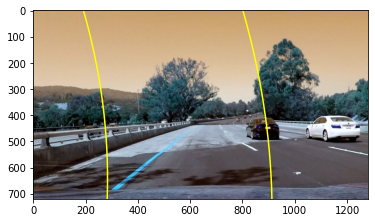

In [25]:
video1_output = 'videos_output/video1_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("project_video.mp4").subclip(0,1)
clip1 = VideoFileClip("project_video.mp4")
video1_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time video1_clip.write_videofile(video1_output, audio=False)

In [26]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video1_output))